# SWR

A framework for determining safe withdrawal rates, designed to generalize to:

- Any generator of historical asset returns (historical, Monte Carlo, roll your own market environment)
- Any asset allocation strategy (fixed weights, glidepath schedules, roll your own based on any parameters)
- Any withdrawal strategy (fixed withdrawal, variable percentage, combinations, glidepaths)
- Any metrics to evaluate retirement cohort outcomes (e.g. total spending, certainty equivalent spending, roll your own. Support for survival tables, i.e. calculate expected metric for living retirees taking into account retirement age and survivorship)
- Any (gradient-free) optimizer to find optimal parameters (e.g. asset allocation, withdrawal parameters) to maximize a metric in the given market environment


# Setup and load historical data

In [1]:
from datetime import datetime
from functools import partial
import pytest

import numpy as np
import pandas as pd
# import pandas_datareader as pdr

from SWRsimulation.crra_ce import crra_ce
from SWRsimulation import SWRsimulationCE


In [2]:
def datestr():
    return datetime.strftime(datetime.now(), "%Y-%m-%d %H:%M:%S")


In [3]:
# load Damodaran data from pickle (via http://people.stern.nyu.edu/adamodar/New_Home_Page/datafile/histretSP.html )
# update / create pickle with download_returns.ipynb

RETURN_FILE = 'histretSP'
def load_returns():
    return pd.read_pickle('%s.pickle' % RETURN_FILE)

download_df = load_returns()
return_df = download_df.iloc[:, [0, 3, 12]]
return_df.columns=['stocks', 'bonds', 'cpi']

return_df

stocks     bonds       cpi
Year                              
1928  0.438112  0.032196 -0.011522
1929 -0.082979  0.030179  0.000000
1930 -0.251236  0.005398 -0.026712
1931 -0.438375 -0.156808 -0.089321
1932 -0.086424  0.235896 -0.103014
...        ...       ...       ...
2016  0.117731  0.103651  0.012616
2017  0.216055  0.097239  0.021301
2018 -0.042269 -0.027626  0.024426
2019  0.312117  0.153295  0.022900
2020  0.180139  0.104115  0.012000

[93 rows x 3 columns]

In [4]:
# should adjust CPI to year-ending also but leave it for now
real_return_df = return_df.copy()
# real_return_df.loc[1948:, 'cpi'] = cpi_test['cpi_fred']
# adjust returns for inflation
real_return_df['stocks'] = (1 + real_return_df['stocks']) / (1 + real_return_df['cpi']) - 1
real_return_df['bonds'] = (1 + real_return_df['bonds']) / (1 + real_return_df['cpi']) - 1
real_return_df.drop('cpi', axis=1, inplace=True)
real_return_df.to_pickle('real_return_df.pickle')

real_return_df

stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns]

In [5]:
# check values per appendix of Bengen paper https://www.retailinvestor.org/pdf/Bengen1.pdf
# nominal return 10% for stocks, 5% for bonds
# inflation 3%
# fixed spending of 4% of orig port
STOCK_RETURN = (1.1 / 1.03) - 1
BOND_RETURN = (1.05 / 1.03) - 1
VARIABLE_SPEND = 0.0
FIXED_SPEND = 4.0
N_RET_YEARS = 30

returns_df = pd.DataFrame(index=range(1928, 2021), 
                          data={'stocks': STOCK_RETURN, 
                                'bonds': BOND_RETURN})
 
s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': returns_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {}, # no args, default = number of years to exhaustion
    'visualization': {}
})

print(s)

# a single trial starting in 1928
z = s.simulate_trial(next(s.simulation['trials']))

# match figures in appendix
# example uses nominal vals with 3% inflation, we use real vals
assert z.iloc[0]['before_spend'] * 1.03 == pytest.approx(107.5, 0.000001)
assert z.iloc[0]['spend'] * 1.03 == 4.12, "spend does not match Bengen"
assert z.iloc[0]['end_port'] * 1.03 == pytest.approx(103.38, 0.000001), "ending port does not match Bengen"

z

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
1928  0.067961  0.019417
1929  0.067961  0.019417
1930  0.067961  0.019417
1931  0.067961  0.019417
1932  0.067961  0.019417
...        ...       ...
2016  0.067961  0.019417
2017  0.067961  0.019417
2018  0.067961  0.019417
2019  0.067961  0.019417
2020  0.067961  0.019417

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff67b2e9cf0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


start_port  port_return  before_spend  spend    end_port  alloc_0  \
1928  100.000000     0.043689    104.368932    4.0  100.368932      0.5   
1929  100.368932     0.043689    104.753982    4.0  100.753982      0.5   
1930  100.753982     0.043689    105.155855    4.0  101.155855      0.5   
1931  101.155855     0.043689    105.575286    4.0  101.575286      0.5   
1932  101.575286     0.043689    106.013041    4.0  102.013041      0.5   
1933  102.013041     0.043689    106.469922    4.0  102.469922      0.5   
1934  102.469922     0.043689    106.946763    4.0  102.946763      0.5   
1935  102.946763     0.043689    107.444437    4.0  103.444437      0.5   
1936  103.444437     0.043689    107.963854    4.0  103.963854      0.5   
1937  103.963854     0.043689    108.505964    4.0  104.505964      0.5   
1938  104.505964     0.043689    109.071759    4.0  105.071759      0.5   
1939  105.071759     0.043689    109.662273    4.0  105.662273      0.5   
1940  105.662273     0.043689    110.278586    4.0  106.278586      0.5   
1941  106.278586     0.043689    110.921825    4.0  106.921825      0.5   
1942  106.921825     0.043689    111.593167    4.0  107.593167      0.5   
1943  107.593167     0.043689    112.293839    4.0  108.293839      0.5   
1944  108.293839     0.043689    113.025123    4.0  109.025123      0.5   
1945  109.025123     0.043689    113.788357    4.0  109.788357      0.5   
1946  109.788357     0.043689    114.584935    4.0  110.584935      0.5   
1947  110.584935     0.043689    115.416316    4.0  111.416316      0.5   
1948  111.416316     0.043689    116.284019    4.0  112.284019      0.5   
1949  112.284019     0.043689    117.189632    4.0  113.189632      0.5   
1950  113.189632     0.043689    118.134810    4.0  114.134810      0.5   
1951  114.134810     0.043689    119.121282    4.0  115.121282      0.5   
1952  115.121282     0.043689    120.150853    4.0  116.150853      0.5   
1953  116.150853     0.043689    121.225404    4.0  117.225404      0.5   
1954  117.225404     0.043689    122.346903    4.0  118.346903      0.5   
1955  118.346903     0.043689    123.517398    4.0  119.517398      0.5   
1956  119.517398     0.043689    124.739032    4.0  120.739032      0.5   
1957  120.739032     0.043689    126.014039    4.0  122.014039      0.5   

      alloc_1  
1928      0.5  
1929      0.5  
1930      0.5  
1931      0.5  
1932      0.5  
1933      0.5  
1934      0.5  
1935      0.5  
1936      0.5  
1937      0.5  
1938      0.5  
1939      0.5  
1940      0.5  
1941      0.5  
1942      0.5  
1943      0.5  
1944      0.5  
1945      0.5  
1946      0.5  
1947      0.5  
1948      0.5  
1949      0.5  
1950      0.5  
1951      0.5  
1952      0.5  
1953      0.5  
1954      0.5  
1955      0.5  
1956      0.5  
1957      0.5

Simulation:
{'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.historical_trials at 0x7ff67b2a34a0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


metric       value
0              mean annual spending over all cohorts         4.0
1  mean within-cohort standard deviation of spending         0.0
2            lowest annual spending over all cohorts         4.0
3          minimum ending portfolio over all cohorts  2.21140264
4                  minimum ending portfolio in years      [1966]
5        % cohort portfolios exhausted by final year         0.0

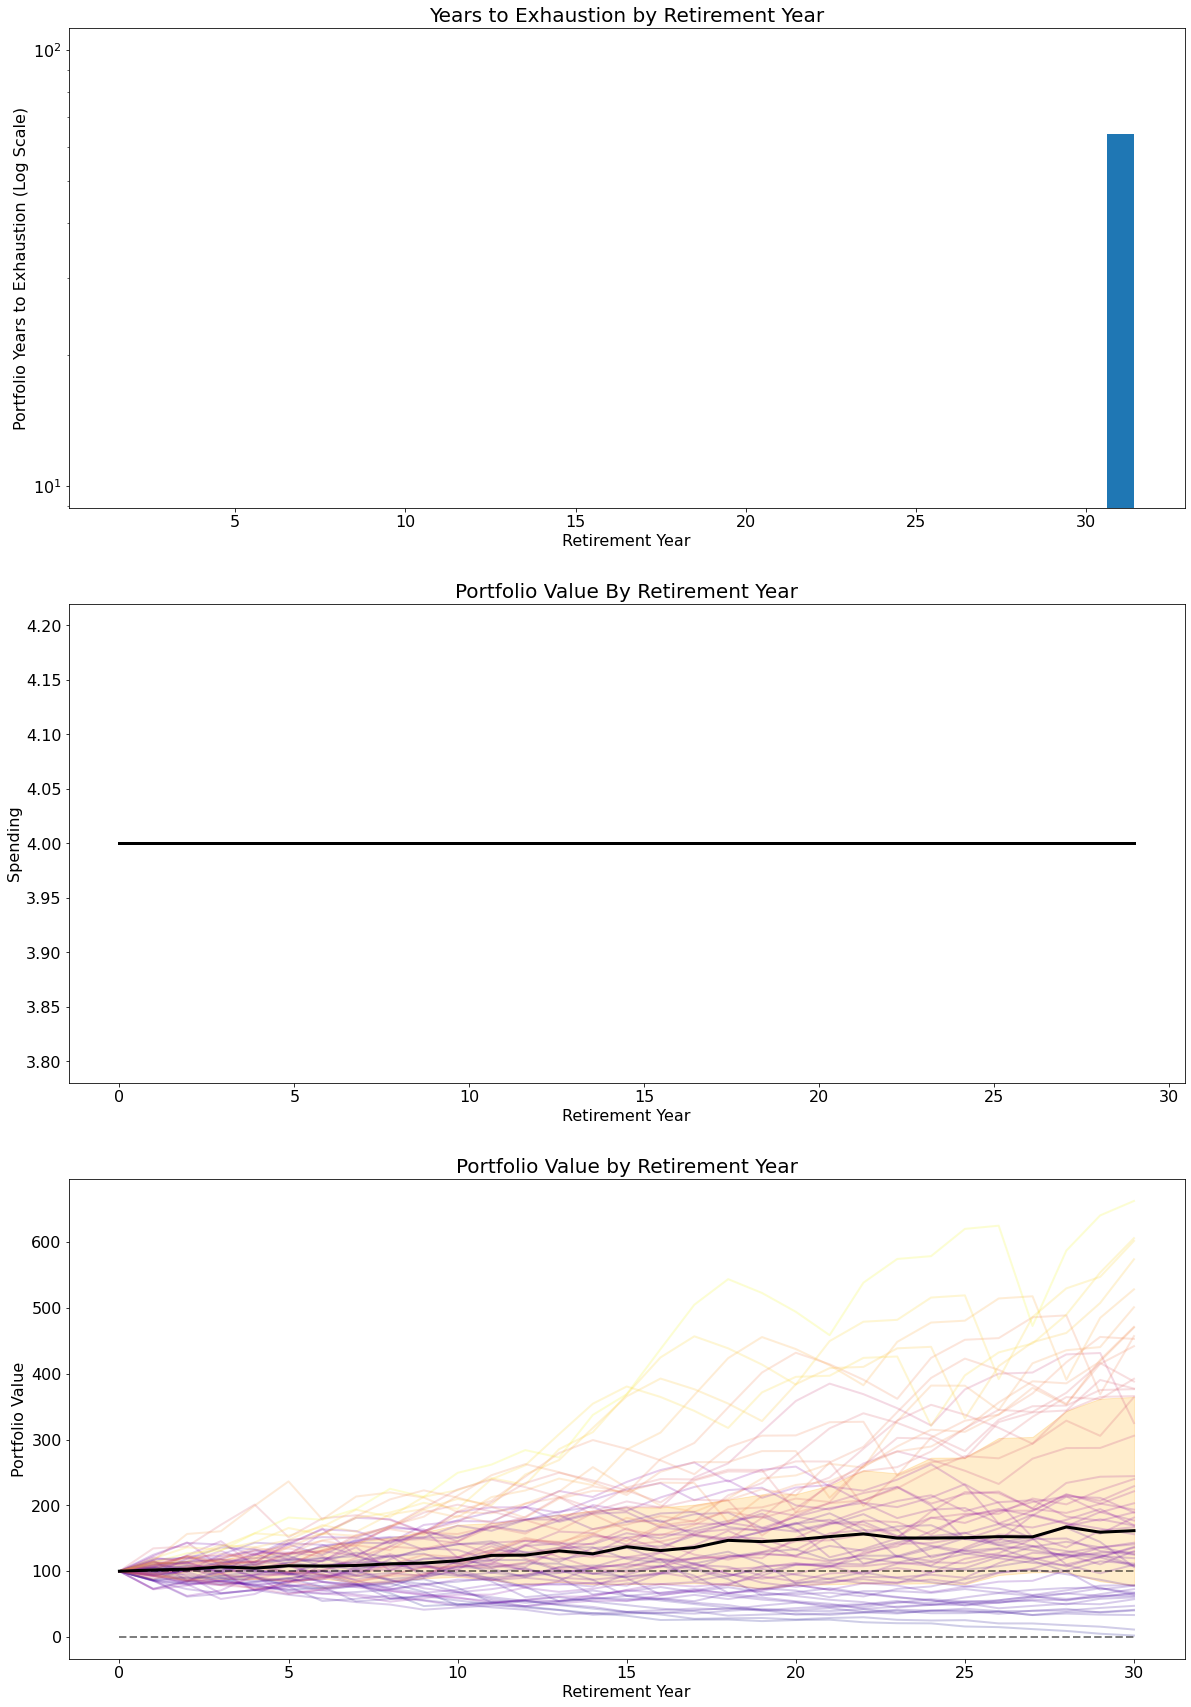

In [6]:
# Bengen 4% rule
VARIABLE_SPEND = 0.0
FIXED_SPEND = 4.0
N_RET_YEARS = 30

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED_SPEND,
                   'variable_pct': VARIABLE_SPEND},
    'evaluation': {'gamma': 1}, 
    'visualization': {'histogram': True,
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Spending By Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Value By Retirement Year'},
                }    # chart options etc.
})

print(s)
s.simulate() # returns array of trials (by default all historical retirement periods)
s.visualize()  # chart of latest simulation

In [7]:
# instead of historical, do 1000 montecarlo trials
# for each year of retirement, draw a random year from history to generate performance

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.montecarlo_trials at 0x7ff6fe6ff6d0>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


metric  \
0              mean annual spending over all cohorts   
1  mean within-cohort standard deviation of spending   
2            lowest annual spending over all cohorts   
3          minimum ending portfolio over all cohorts   
4                  minimum ending portfolio in years   
5        % cohort portfolios exhausted by final year   

                                               value  
0                                         3.95900862  
1                                         0.08223345  
2                                                0.0  
3                                                0.0  
4  [1957, 1934, 1964, 1995, 1963, 2010, 1974, 200...  
5                                                6.0

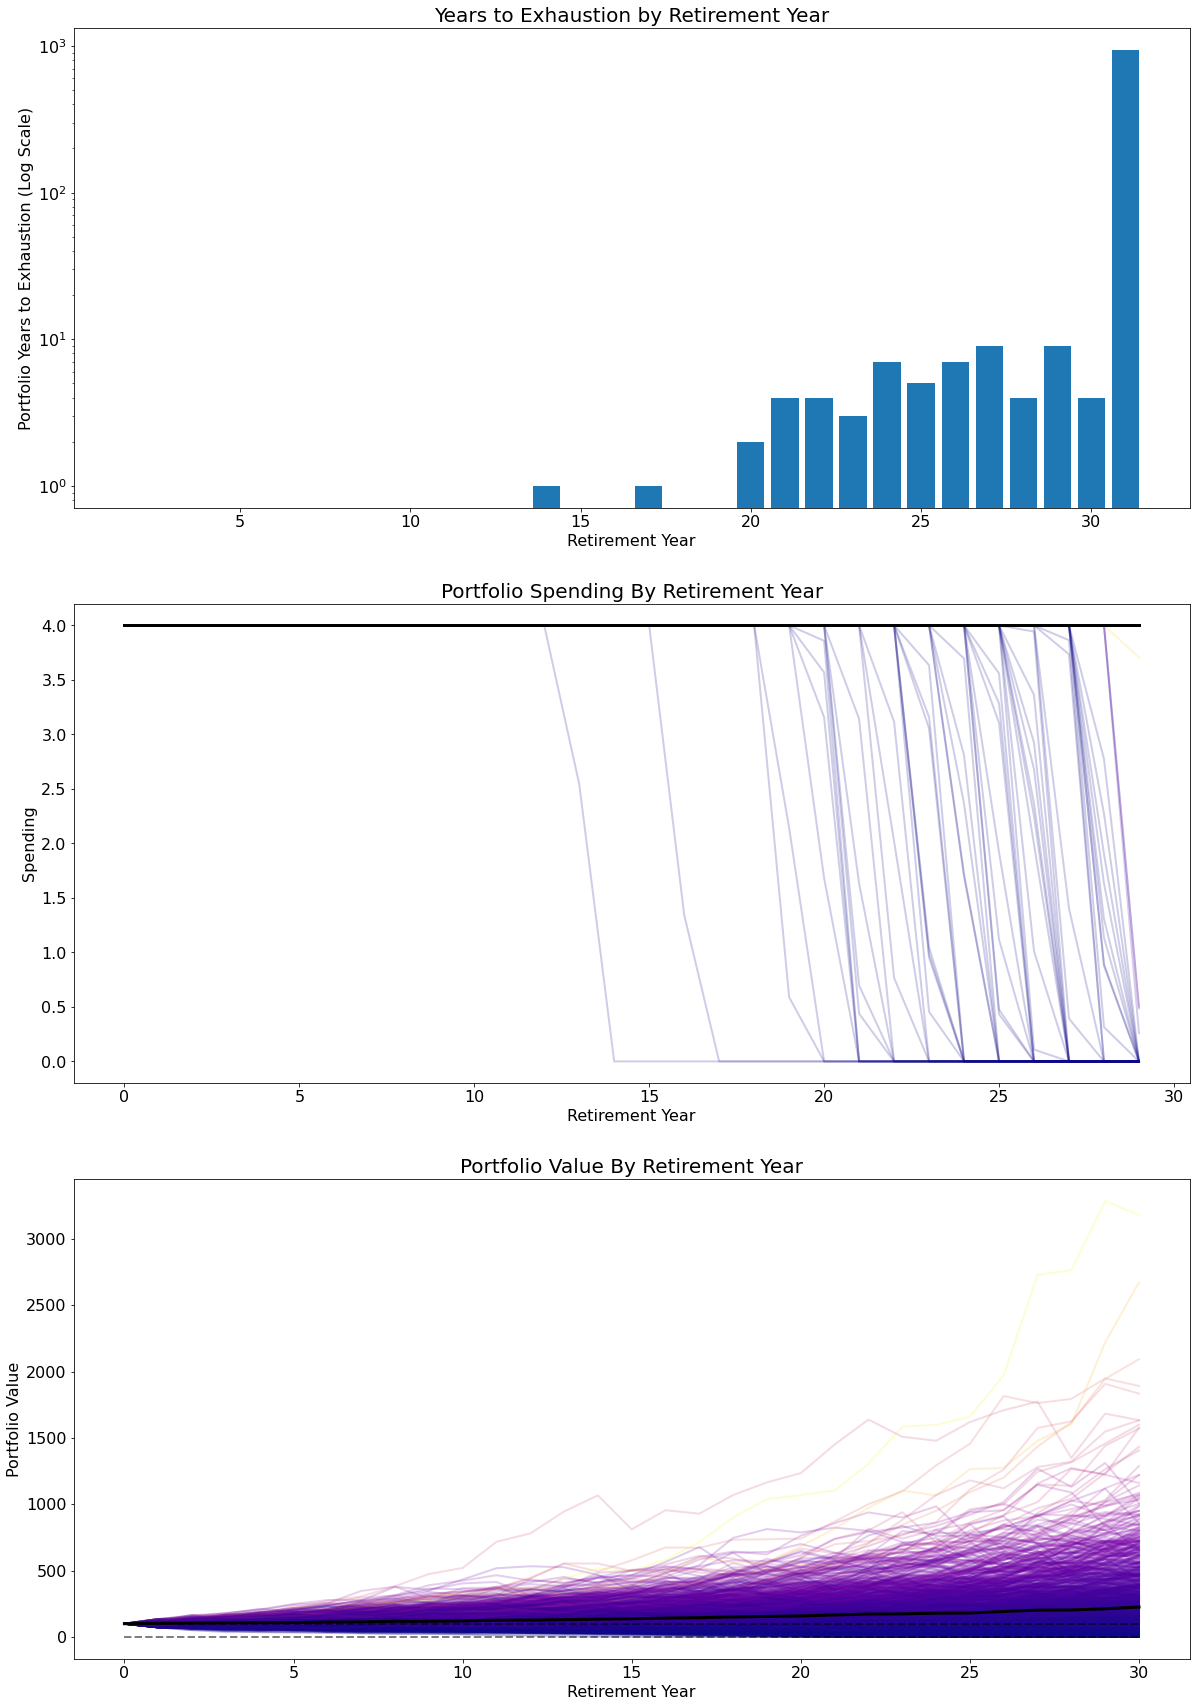

In [8]:
VARIABLE = 0.0
FIXED = 4.0
N_RET_YEARS = 30
NTRIALS = 1000

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {'gamma': 1}, 
    'visualization': {'histogram': True,
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Spending By Retirement Year'},
                      'chart_3' : {'title': 'Portfolio Value By Retirement Year'},
                     }    # chart options etc.
})

print(s)

# don't keep 1000 historical arrays, just return a single eval for each trial
# eval is the years to exhaustion (30 if never exhausted)
s.simulate()
s.visualize()  # chart of latest simulation

In [9]:
# bengen rule

# update to what I did before 

# here's a dataviz 3 parameters, with presets ... output a table, just chart of spending , history/montecarlo?
# review prior

# can do a bit better with latest tools, in terms of optimization and dataviz
# tried to build flexible toolkit, if you don't like these rules for allocation, withdrawal, 
# want different/more parameters just override, just override

# implementation
# - allocation rule
# - withdrawal rule
# evaluation 
# optimization
# visualization

# 'relaxed' bengen rule
# suppose portfolio goes up, by induction if 4% is good for 30 years you can safely increase
# if portfolio goes down it's safer to do 4% of new value. if you spend 4% of value instead of fixed you could never go broke since you adjust on the way down
# so 4% seems like a pretty good number in the sense that in the long run you do OK
# 'normal' bengen rule = 4% of original port
# 'relaxed' bengen rule = max(4% of original port, 4% current port)

# in other words, 4% of original portfolio is the floor. if portfolio goes above starting value, you can spend 4% of the current valeu
# if portfolio goes below starting value, you can always spend at least 4%.

# confirm that it works same way

# montecarlo bengen, relaxed bengen

# so 4% historically has been an OK rule
# next, can we improve on it using optimization?

# part 1 implementation, of bengen rule, historical and montecarlo, relaxed historical and monte carlo
# part 2 variable % . point being, you can never go broke
# part 3 fixed + variable and optimization
# part 4 utility
# part 5 other things you can do ... more strategies, look at kitces, others ... 
# glidepath with a glide param or asset alloc , spend by year. mortality. anyway if it's useful, use it, extend it

# maximizing CE withdrawal is one optimization approach but there are certainly others. 
# one could minimize expected shortfall subject to a desired spending constraint, one could use different utility
# functions such as a prospect-theory loss-aversion function. hopefully, people may find this framework useful 
# for studying different approaches,by subclassing and overriding methods for withdrawal,
# allocation, and utility metrics.


In [10]:
# have github CI run tests automatically

# .analyze() ... run the 2 plots
# analyze_plotly, analyze
# use montecarlo to find a bad example with 4%
# use a fixture to test the eval code, clean up tests

# function to return ce value based on strategy
# ce value of a stream
# ce value of many ce streams
# run bayesian optimizaton, optuna etc.
# ce value of a set of streams over a mortality curve
# try convex optimization
# go through the scikit optimizers and see if there are other global optimizers that might work eg simulated annealing
# accept an arbitrary schedule, utility function, optimizer


# certainty_equivalent_mortality(k_list, mortality_table)
# calculate probability of being alive in years 1...k
# so now you have k lists with associated probabilities
#    certainty_adjust cash flow streams
#    not just full cash flow but range(nyears) cash flows 
#    then certainty adjust over the probability distribution of each sequence of cash flows
    

Simulation:
{'montecarlo': 1000,
 'montecarlo_replacement': True,
 'n_asset_years': 93,
 'n_assets': 2,
 'n_ret_years': 30,
 'returns_df':         stocks     bonds
Year                    
1928  0.454874  0.044227
1929 -0.082979  0.030179
1930 -0.230686  0.032991
1931 -0.383290 -0.074106
1932  0.018495  0.377832
...        ...       ...
2016  0.103805  0.089901
2017  0.190692  0.074354
2018 -0.065104 -0.050811
2019  0.282742  0.127475
2020  0.166145  0.091023

[93 rows x 2 columns],
 'trials': <generator object SWRsimulationCE.montecarlo_trials at 0x7ff671289740>}

Allocation:
{'asset_weights': array([0.5, 0.5])}

Withdrawal:
{'fixed': 4.0, 'fixed_pct': 4.0, 'variable': 0.0, 'variable_pct': 0.0}


metric  \
0              mean annual spending over all cohorts   
1  mean within-cohort standard deviation of spending   
2            lowest annual spending over all cohorts   
3          minimum ending portfolio over all cohorts   
4                  minimum ending portfolio in years   
5        % cohort portfolios exhausted by final year   

                                               value  
0                                           3.949473  
1                                         0.08425854  
2                                                0.0  
3                                                0.0  
4  [1974, 1987, 1959, 1942, 1930, 1974, 1946, 195...  
5                                                5.7

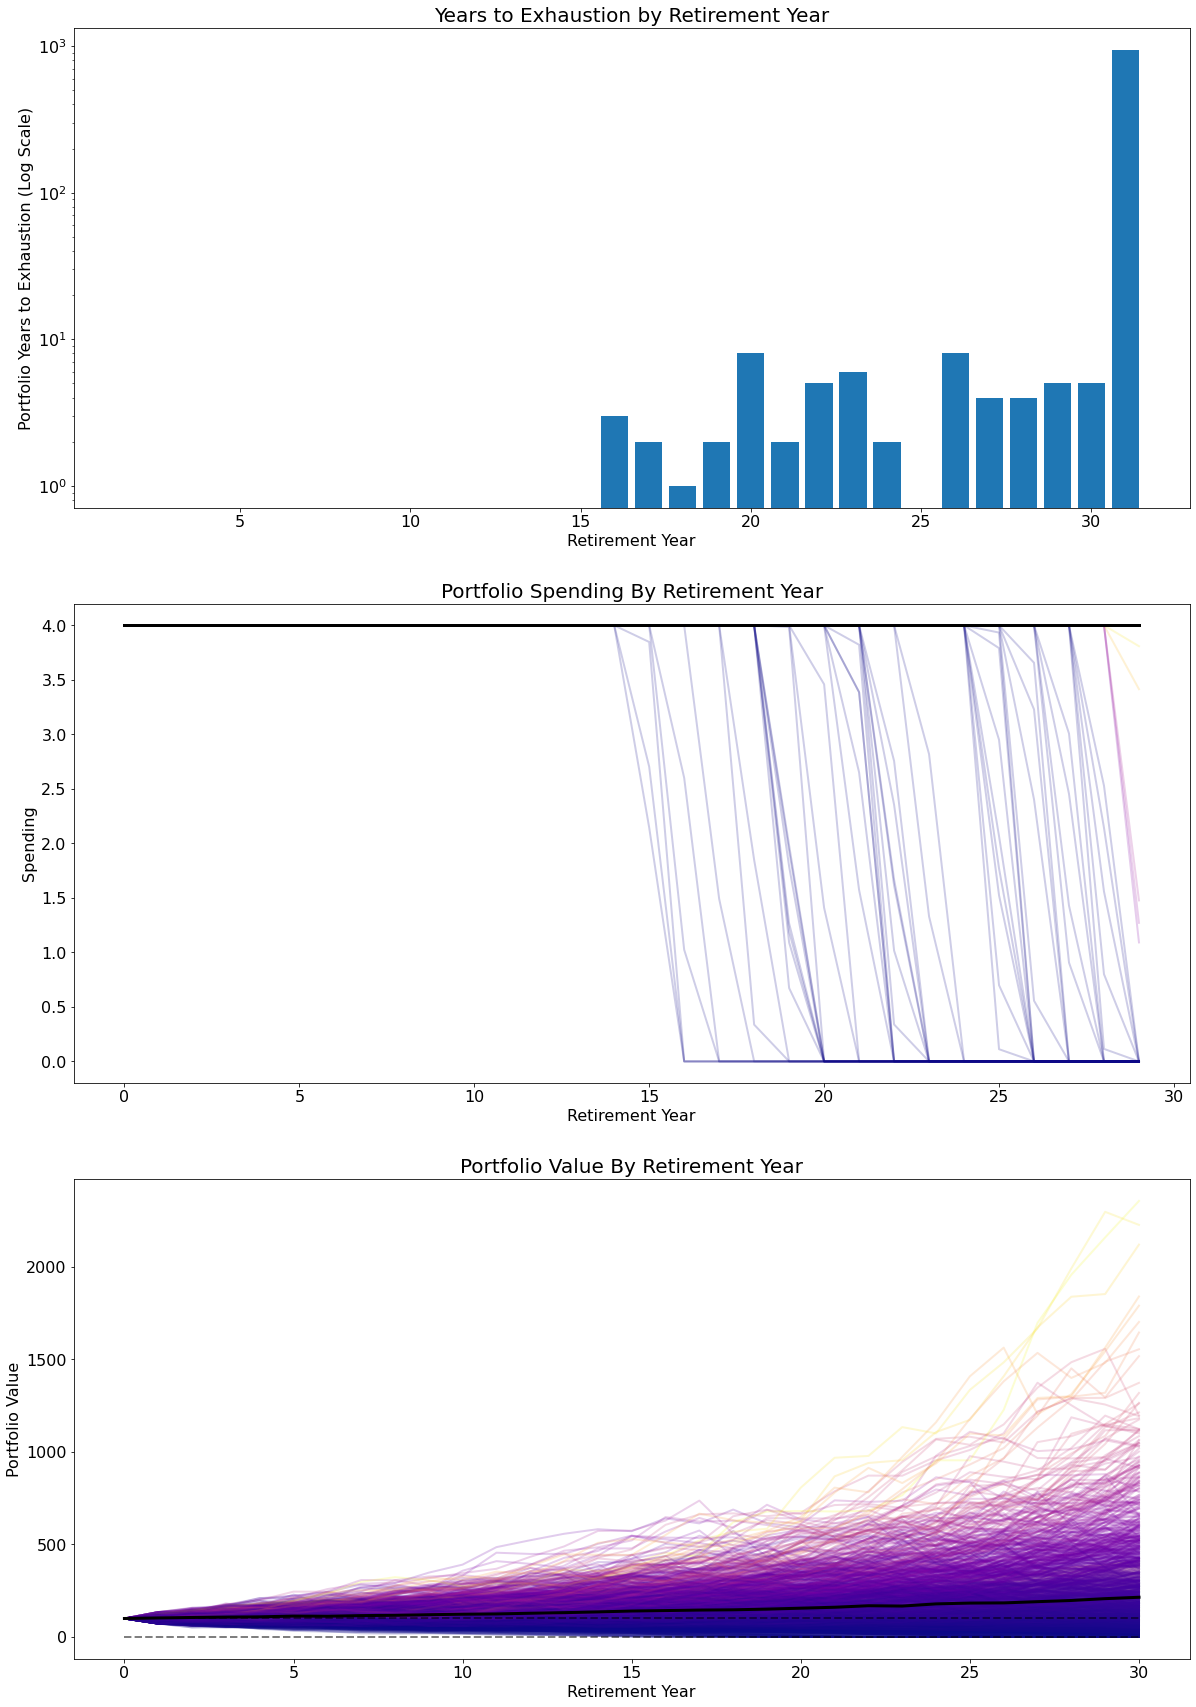

In [11]:
VARIABLE = 0.0
FIXED = 4.0
N_RET_YEARS = 30
NTRIALS = 1000

s = SWRsimulationCE.SWRsimulationCE({
    'simulation': {'returns_df': real_return_df,
                   'montecarlo': NTRIALS,
                   'montecarlo_replacement': True,
                   'n_ret_years': N_RET_YEARS,
                  },
    'allocation': {'asset_weights': np.array([0.5, 0.5])}, # default is equal-weight 
    'withdrawal': {'fixed_pct': FIXED,
                   'variable_pct': VARIABLE},
    'evaluation': {'gamma': 1}, 
    'visualization': {'histogram': True,
                      'chart_1' : {'title': 'Years to Exhaustion by Retirement Year'},
                      'chart_2' : {'title': 'Portfolio Spending By Retirement Year'},
                      'chart_3' : {'title': 'Portfolio Value By Retirement Year'},
                     }    # chart options etc.
})

print(s)
s.simulate()
s.visualize()  # chart of latest simulation

In [12]:
FIXED_SPEND = 2
VARIABLE_SPEND = 2
ALLOC_STOCKS = 0.6
ALLOC_BONDS = 0.4
N_RET_YEARS = 30

def ce_experiment(n_ret_years, gamma, *params):
    # some optimizers pass an array, some pass a dict, some pass indiv unpacked params
    # global s   # for debugging keep last
    if len(params) == 1:   # unpack
        params = params[0]
        
    if type(params) == dict:
        fixed_spend = params['fixed_spend']
        variable_spend = params['variable_spend']
        alloc_stocks = params['alloc_stocks']
        n_ret_years = N_RET_YEARS
    elif type(params) == list or type(params) == tuple:
        fixed_spend, variable_spend, alloc_stocks = params     
        n_ret_years = N_RET_YEARS
    elif type(params) == np.ndarray:
        fixed_spend, variable_spend, alloc_stocks = params.tolist()
        n_ret_years = N_RET_YEARS
    else:
        raise Exception('bad argument to ce_experiment', type(params), params)
        
    if alloc_stocks > 1.0:
        return 0
    if alloc_stocks < 0.0:
        return 0
    
    alloc_bonds = 1.0 - alloc_stocks

    s = SWRsimulationCE.SWRsimulationCE({
        'simulation': {'returns_df': real_return_df,
                       'n_ret_years': n_ret_years,
#                        'montecarlo': N_TRIALS,
#                        'montecarlo_replacement': False,
                      },
        'allocation': {'asset_weights': np.array([alloc_stocks, alloc_bonds])}, 
        'withdrawal': {'fixed_pct': fixed_spend,
                       'variable_pct': variable_spend,
                       'smoothing_factor': 1.0,
                      },
        'evaluation': {'gamma': gamma},
        'visualization': {}    
    })
    s.simulate()
    return -crra_ce(np.array([z['ce_spend'] for z in s.latest_simulation]), gamma)

# freeze first 2 args with functools.partial
ce_experiment_1 = partial(ce_experiment, N_RET_YEARS, 1)

# unpacked args
print(ce_experiment_1(FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS))

# list arg
print(ce_experiment_1([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS]))

# ndarray arg
print(ce_experiment_1(np.array([FIXED_SPEND, VARIABLE_SPEND, ALLOC_STOCKS])))

# dict arg
print(ce_experiment_1({'fixed_spend': FIXED_SPEND, 
                       'variable_spend': VARIABLE_SPEND, 
                       'alloc_stocks': ALLOC_STOCKS}))


-9352.440807153926
-9352.440807153926
-9352.440807153926
-9352.440807153926


In [13]:
import math
gamma=4
crra_utility = lambda x: (x ** (1 - gamma) - 1) / (1 - gamma)
print(crra_utility (1000000000))
winbet = 110
losebet = 100
w = 1000

win_utils = crra_utility(w + winbet) - crra_utility(w)
loss_utils = crra_utility(w) - crra_utility(w - losebet)
print ('win', win_utils)
print ('loss', loss_utils)
print('edge', win_utils-loss_utils)


0.3333333333333333
win 8.960288067072497e-11
loss 1.2391404569100928e-10
edge -3.4311165020284307e-11


In [14]:
winbet = 2000
losebet = 1000
w = 4000

win_utils = crra_utility(w + winbet) - crra_utility(w)
loss_utils = crra_utility(w) - crra_utility(w - losebet)
print ('win', win_utils)
print ('loss', loss_utils)
print('edge', win_utils-loss_utils)


win 3.665068248892567e-12
loss 7.137401780710206e-12
edge -3.4723335318176396e-12


In [15]:
def general_ce(cashflows, gamma):
    cashflows = np.longdouble(cashflows)
    if gamma == 1:
        u = np.mean(np.log(cashflows))
        ce = np.exp(u)
    else:
        u = np.mean((cashflows ** (1 - gamma) - 1) / (1 - gamma))
        ce = (1 + u * (1 - gamma)) ** (1 / (1 - gamma))
    ce = np.float(ce)
    return ce * len(cashflows)

In [67]:
import pickle

for stock_alloc in np.linspace(50,100, 11):
    for fixed_spend in np.linspace(0,5,51):
        for variable_spend in np.linspace(0,10,101):
            stock_alloc = np.round(stock_alloc, 0)
            fixed_spend = np.round(fixed_spend, 1)
            variable_spend = np.round(variable_spend, 1)
            stock_fraction = stock_alloc/100
            bond_fraction = 1-stock_fraction
            s = SWRsimulationCE.SWRsimulationCE({
                'simulation': {'returns_df': returns_df,
                               'n_ret_years': N_RET_YEARS,
                              },
                'allocation': {'asset_weights': np.array([stock_fraction, bond_fraction])}, 
                'withdrawal': {'fixed_pct': FIXED_SPEND,
                               'variable_pct': VARIABLE_SPEND},
                'evaluation': {'gamma': 0},
                'visualization': {}
            })
            s.simulate()
            picklefile = "data/sim_%03.0f_%04.1f_%04.1f.pickle" % (stock_alloc, fixed_spend, variable_spend)
            pickle.dump(s.latest_simulation, open(picklefile, "wb"))
            print(picklefile)


data/sim_050_00.0_00.0.pickle
data/sim_050_00.0_00.1.pickle
data/sim_050_00.0_00.2.pickle
data/sim_050_00.0_00.3.pickle
data/sim_050_00.0_00.4.pickle
data/sim_050_00.0_00.5.pickle
data/sim_050_00.0_00.6.pickle
data/sim_050_00.0_00.7.pickle
data/sim_050_00.0_00.8.pickle
data/sim_050_00.0_00.9.pickle
data/sim_050_00.0_01.0.pickle
data/sim_050_00.0_01.1.pickle
data/sim_050_00.0_01.2.pickle
data/sim_050_00.0_01.3.pickle
data/sim_050_00.0_01.4.pickle
data/sim_050_00.0_01.5.pickle
data/sim_050_00.0_01.6.pickle
data/sim_050_00.0_01.7.pickle
data/sim_050_00.0_01.8.pickle
data/sim_050_00.0_01.9.pickle
data/sim_050_00.0_02.0.pickle
data/sim_050_00.0_02.1.pickle
data/sim_050_00.0_02.2.pickle
data/sim_050_00.0_02.3.pickle
data/sim_050_00.0_02.4.pickle
data/sim_050_00.0_02.5.pickle
data/sim_050_00.0_02.6.pickle
data/sim_050_00.0_02.7.pickle
data/sim_050_00.0_02.8.pickle
data/sim_050_00.0_02.9.pickle
data/sim_050_00.0_03.0.pickle
data/sim_050_00.0_03.1.pickle
data/sim_050_00.0_03.2.pickle
data/sim_0

data/sim_050_00.2_07.4.pickle
data/sim_050_00.2_07.5.pickle
data/sim_050_00.2_07.6.pickle
data/sim_050_00.2_07.7.pickle
data/sim_050_00.2_07.8.pickle
data/sim_050_00.2_07.9.pickle
data/sim_050_00.2_08.0.pickle
data/sim_050_00.2_08.1.pickle
data/sim_050_00.2_08.2.pickle
data/sim_050_00.2_08.3.pickle
data/sim_050_00.2_08.4.pickle
data/sim_050_00.2_08.5.pickle
data/sim_050_00.2_08.6.pickle
data/sim_050_00.2_08.7.pickle
data/sim_050_00.2_08.8.pickle
data/sim_050_00.2_08.9.pickle
data/sim_050_00.2_09.0.pickle
data/sim_050_00.2_09.1.pickle
data/sim_050_00.2_09.2.pickle
data/sim_050_00.2_09.3.pickle
data/sim_050_00.2_09.4.pickle
data/sim_050_00.2_09.5.pickle
data/sim_050_00.2_09.6.pickle
data/sim_050_00.2_09.7.pickle
data/sim_050_00.2_09.8.pickle
data/sim_050_00.2_09.9.pickle
data/sim_050_00.2_10.0.pickle
data/sim_050_00.3_00.0.pickle
data/sim_050_00.3_00.1.pickle
data/sim_050_00.3_00.2.pickle
data/sim_050_00.3_00.3.pickle
data/sim_050_00.3_00.4.pickle
data/sim_050_00.3_00.5.pickle
data/sim_0

data/sim_050_00.5_04.5.pickle
data/sim_050_00.5_04.6.pickle
data/sim_050_00.5_04.7.pickle
data/sim_050_00.5_04.8.pickle
data/sim_050_00.5_04.9.pickle
data/sim_050_00.5_05.0.pickle
data/sim_050_00.5_05.1.pickle
data/sim_050_00.5_05.2.pickle
data/sim_050_00.5_05.3.pickle
data/sim_050_00.5_05.4.pickle
data/sim_050_00.5_05.5.pickle
data/sim_050_00.5_05.6.pickle
data/sim_050_00.5_05.7.pickle
data/sim_050_00.5_05.8.pickle
data/sim_050_00.5_05.9.pickle
data/sim_050_00.5_06.0.pickle
data/sim_050_00.5_06.1.pickle
data/sim_050_00.5_06.2.pickle
data/sim_050_00.5_06.3.pickle
data/sim_050_00.5_06.4.pickle
data/sim_050_00.5_06.5.pickle
data/sim_050_00.5_06.6.pickle
data/sim_050_00.5_06.7.pickle
data/sim_050_00.5_06.8.pickle
data/sim_050_00.5_06.9.pickle
data/sim_050_00.5_07.0.pickle
data/sim_050_00.5_07.1.pickle
data/sim_050_00.5_07.2.pickle
data/sim_050_00.5_07.3.pickle
data/sim_050_00.5_07.4.pickle
data/sim_050_00.5_07.5.pickle
data/sim_050_00.5_07.6.pickle
data/sim_050_00.5_07.7.pickle
data/sim_0

data/sim_050_00.8_01.8.pickle
data/sim_050_00.8_01.9.pickle
data/sim_050_00.8_02.0.pickle
data/sim_050_00.8_02.1.pickle
data/sim_050_00.8_02.2.pickle
data/sim_050_00.8_02.3.pickle
data/sim_050_00.8_02.4.pickle
data/sim_050_00.8_02.5.pickle
data/sim_050_00.8_02.6.pickle
data/sim_050_00.8_02.7.pickle
data/sim_050_00.8_02.8.pickle
data/sim_050_00.8_02.9.pickle
data/sim_050_00.8_03.0.pickle
data/sim_050_00.8_03.1.pickle
data/sim_050_00.8_03.2.pickle
data/sim_050_00.8_03.3.pickle
data/sim_050_00.8_03.4.pickle
data/sim_050_00.8_03.5.pickle
data/sim_050_00.8_03.6.pickle
data/sim_050_00.8_03.7.pickle
data/sim_050_00.8_03.8.pickle
data/sim_050_00.8_03.9.pickle
data/sim_050_00.8_04.0.pickle
data/sim_050_00.8_04.1.pickle
data/sim_050_00.8_04.2.pickle
data/sim_050_00.8_04.3.pickle
data/sim_050_00.8_04.4.pickle
data/sim_050_00.8_04.5.pickle
data/sim_050_00.8_04.6.pickle
data/sim_050_00.8_04.7.pickle
data/sim_050_00.8_04.8.pickle
data/sim_050_00.8_04.9.pickle
data/sim_050_00.8_05.0.pickle
data/sim_0

data/sim_050_01.0_09.2.pickle
data/sim_050_01.0_09.3.pickle
data/sim_050_01.0_09.4.pickle
data/sim_050_01.0_09.5.pickle
data/sim_050_01.0_09.6.pickle
data/sim_050_01.0_09.7.pickle
data/sim_050_01.0_09.8.pickle
data/sim_050_01.0_09.9.pickle
data/sim_050_01.0_10.0.pickle
data/sim_050_01.1_00.0.pickle
data/sim_050_01.1_00.1.pickle
data/sim_050_01.1_00.2.pickle
data/sim_050_01.1_00.3.pickle
data/sim_050_01.1_00.4.pickle
data/sim_050_01.1_00.5.pickle
data/sim_050_01.1_00.6.pickle
data/sim_050_01.1_00.7.pickle
data/sim_050_01.1_00.8.pickle
data/sim_050_01.1_00.9.pickle
data/sim_050_01.1_01.0.pickle
data/sim_050_01.1_01.1.pickle
data/sim_050_01.1_01.2.pickle
data/sim_050_01.1_01.3.pickle
data/sim_050_01.1_01.4.pickle
data/sim_050_01.1_01.5.pickle
data/sim_050_01.1_01.6.pickle
data/sim_050_01.1_01.7.pickle
data/sim_050_01.1_01.8.pickle
data/sim_050_01.1_01.9.pickle
data/sim_050_01.1_02.0.pickle
data/sim_050_01.1_02.1.pickle
data/sim_050_01.1_02.2.pickle
data/sim_050_01.1_02.3.pickle
data/sim_0

data/sim_050_01.3_06.4.pickle
data/sim_050_01.3_06.5.pickle
data/sim_050_01.3_06.6.pickle
data/sim_050_01.3_06.7.pickle
data/sim_050_01.3_06.8.pickle
data/sim_050_01.3_06.9.pickle
data/sim_050_01.3_07.0.pickle
data/sim_050_01.3_07.1.pickle
data/sim_050_01.3_07.2.pickle
data/sim_050_01.3_07.3.pickle
data/sim_050_01.3_07.4.pickle
data/sim_050_01.3_07.5.pickle
data/sim_050_01.3_07.6.pickle
data/sim_050_01.3_07.7.pickle
data/sim_050_01.3_07.8.pickle
data/sim_050_01.3_07.9.pickle
data/sim_050_01.3_08.0.pickle
data/sim_050_01.3_08.1.pickle
data/sim_050_01.3_08.2.pickle
data/sim_050_01.3_08.3.pickle
data/sim_050_01.3_08.4.pickle
data/sim_050_01.3_08.5.pickle
data/sim_050_01.3_08.6.pickle
data/sim_050_01.3_08.7.pickle
data/sim_050_01.3_08.8.pickle
data/sim_050_01.3_08.9.pickle
data/sim_050_01.3_09.0.pickle
data/sim_050_01.3_09.1.pickle
data/sim_050_01.3_09.2.pickle
data/sim_050_01.3_09.3.pickle
data/sim_050_01.3_09.4.pickle
data/sim_050_01.3_09.5.pickle
data/sim_050_01.3_09.6.pickle
data/sim_0

data/sim_050_01.6_03.6.pickle
data/sim_050_01.6_03.7.pickle
data/sim_050_01.6_03.8.pickle
data/sim_050_01.6_03.9.pickle
data/sim_050_01.6_04.0.pickle
data/sim_050_01.6_04.1.pickle
data/sim_050_01.6_04.2.pickle
data/sim_050_01.6_04.3.pickle
data/sim_050_01.6_04.4.pickle
data/sim_050_01.6_04.5.pickle
data/sim_050_01.6_04.6.pickle
data/sim_050_01.6_04.7.pickle
data/sim_050_01.6_04.8.pickle
data/sim_050_01.6_04.9.pickle
data/sim_050_01.6_05.0.pickle
data/sim_050_01.6_05.1.pickle
data/sim_050_01.6_05.2.pickle
data/sim_050_01.6_05.3.pickle
data/sim_050_01.6_05.4.pickle
data/sim_050_01.6_05.5.pickle
data/sim_050_01.6_05.6.pickle
data/sim_050_01.6_05.7.pickle
data/sim_050_01.6_05.8.pickle
data/sim_050_01.6_05.9.pickle
data/sim_050_01.6_06.0.pickle
data/sim_050_01.6_06.1.pickle
data/sim_050_01.6_06.2.pickle
data/sim_050_01.6_06.3.pickle
data/sim_050_01.6_06.4.pickle
data/sim_050_01.6_06.5.pickle
data/sim_050_01.6_06.6.pickle
data/sim_050_01.6_06.7.pickle
data/sim_050_01.6_06.8.pickle
data/sim_0

data/sim_050_01.9_00.8.pickle
data/sim_050_01.9_00.9.pickle
data/sim_050_01.9_01.0.pickle
data/sim_050_01.9_01.1.pickle
data/sim_050_01.9_01.2.pickle
data/sim_050_01.9_01.3.pickle
data/sim_050_01.9_01.4.pickle
data/sim_050_01.9_01.5.pickle
data/sim_050_01.9_01.6.pickle
data/sim_050_01.9_01.7.pickle
data/sim_050_01.9_01.8.pickle
data/sim_050_01.9_01.9.pickle
data/sim_050_01.9_02.0.pickle
data/sim_050_01.9_02.1.pickle
data/sim_050_01.9_02.2.pickle
data/sim_050_01.9_02.3.pickle
data/sim_050_01.9_02.4.pickle
data/sim_050_01.9_02.5.pickle
data/sim_050_01.9_02.6.pickle
data/sim_050_01.9_02.7.pickle
data/sim_050_01.9_02.8.pickle
data/sim_050_01.9_02.9.pickle
data/sim_050_01.9_03.0.pickle
data/sim_050_01.9_03.1.pickle
data/sim_050_01.9_03.2.pickle
data/sim_050_01.9_03.3.pickle
data/sim_050_01.9_03.4.pickle
data/sim_050_01.9_03.5.pickle
data/sim_050_01.9_03.6.pickle
data/sim_050_01.9_03.7.pickle
data/sim_050_01.9_03.8.pickle
data/sim_050_01.9_03.9.pickle
data/sim_050_01.9_04.0.pickle
data/sim_0

data/sim_050_02.1_08.2.pickle
data/sim_050_02.1_08.3.pickle
data/sim_050_02.1_08.4.pickle
data/sim_050_02.1_08.5.pickle
data/sim_050_02.1_08.6.pickle
data/sim_050_02.1_08.7.pickle
data/sim_050_02.1_08.8.pickle
data/sim_050_02.1_08.9.pickle
data/sim_050_02.1_09.0.pickle
data/sim_050_02.1_09.1.pickle
data/sim_050_02.1_09.2.pickle
data/sim_050_02.1_09.3.pickle
data/sim_050_02.1_09.4.pickle
data/sim_050_02.1_09.5.pickle
data/sim_050_02.1_09.6.pickle
data/sim_050_02.1_09.7.pickle
data/sim_050_02.1_09.8.pickle
data/sim_050_02.1_09.9.pickle
data/sim_050_02.1_10.0.pickle
data/sim_050_02.2_00.0.pickle
data/sim_050_02.2_00.1.pickle
data/sim_050_02.2_00.2.pickle
data/sim_050_02.2_00.3.pickle
data/sim_050_02.2_00.4.pickle
data/sim_050_02.2_00.5.pickle
data/sim_050_02.2_00.6.pickle
data/sim_050_02.2_00.7.pickle
data/sim_050_02.2_00.8.pickle
data/sim_050_02.2_00.9.pickle
data/sim_050_02.2_01.0.pickle
data/sim_050_02.2_01.1.pickle
data/sim_050_02.2_01.2.pickle
data/sim_050_02.2_01.3.pickle
data/sim_0

data/sim_050_02.4_05.4.pickle
data/sim_050_02.4_05.5.pickle
data/sim_050_02.4_05.6.pickle
data/sim_050_02.4_05.7.pickle
data/sim_050_02.4_05.8.pickle
data/sim_050_02.4_05.9.pickle
data/sim_050_02.4_06.0.pickle
data/sim_050_02.4_06.1.pickle
data/sim_050_02.4_06.2.pickle
data/sim_050_02.4_06.3.pickle
data/sim_050_02.4_06.4.pickle
data/sim_050_02.4_06.5.pickle
data/sim_050_02.4_06.6.pickle
data/sim_050_02.4_06.7.pickle
data/sim_050_02.4_06.8.pickle
data/sim_050_02.4_06.9.pickle
data/sim_050_02.4_07.0.pickle
data/sim_050_02.4_07.1.pickle
data/sim_050_02.4_07.2.pickle
data/sim_050_02.4_07.3.pickle
data/sim_050_02.4_07.4.pickle
data/sim_050_02.4_07.5.pickle
data/sim_050_02.4_07.6.pickle
data/sim_050_02.4_07.7.pickle
data/sim_050_02.4_07.8.pickle
data/sim_050_02.4_07.9.pickle
data/sim_050_02.4_08.0.pickle
data/sim_050_02.4_08.1.pickle
data/sim_050_02.4_08.2.pickle
data/sim_050_02.4_08.3.pickle
data/sim_050_02.4_08.4.pickle
data/sim_050_02.4_08.5.pickle
data/sim_050_02.4_08.6.pickle
data/sim_0

data/sim_050_02.7_02.6.pickle
data/sim_050_02.7_02.7.pickle
data/sim_050_02.7_02.8.pickle
data/sim_050_02.7_02.9.pickle
data/sim_050_02.7_03.0.pickle
data/sim_050_02.7_03.1.pickle
data/sim_050_02.7_03.2.pickle
data/sim_050_02.7_03.3.pickle
data/sim_050_02.7_03.4.pickle
data/sim_050_02.7_03.5.pickle
data/sim_050_02.7_03.6.pickle
data/sim_050_02.7_03.7.pickle
data/sim_050_02.7_03.8.pickle
data/sim_050_02.7_03.9.pickle
data/sim_050_02.7_04.0.pickle
data/sim_050_02.7_04.1.pickle
data/sim_050_02.7_04.2.pickle
data/sim_050_02.7_04.3.pickle
data/sim_050_02.7_04.4.pickle
data/sim_050_02.7_04.5.pickle
data/sim_050_02.7_04.6.pickle
data/sim_050_02.7_04.7.pickle
data/sim_050_02.7_04.8.pickle
data/sim_050_02.7_04.9.pickle
data/sim_050_02.7_05.0.pickle
data/sim_050_02.7_05.1.pickle
data/sim_050_02.7_05.2.pickle
data/sim_050_02.7_05.3.pickle
data/sim_050_02.7_05.4.pickle
data/sim_050_02.7_05.5.pickle
data/sim_050_02.7_05.6.pickle
data/sim_050_02.7_05.7.pickle
data/sim_050_02.7_05.8.pickle
data/sim_0

data/sim_050_02.9_10.0.pickle
data/sim_050_03.0_00.0.pickle
data/sim_050_03.0_00.1.pickle
data/sim_050_03.0_00.2.pickle
data/sim_050_03.0_00.3.pickle
data/sim_050_03.0_00.4.pickle
data/sim_050_03.0_00.5.pickle
data/sim_050_03.0_00.6.pickle
data/sim_050_03.0_00.7.pickle
data/sim_050_03.0_00.8.pickle
data/sim_050_03.0_00.9.pickle
data/sim_050_03.0_01.0.pickle
data/sim_050_03.0_01.1.pickle
data/sim_050_03.0_01.2.pickle
data/sim_050_03.0_01.3.pickle
data/sim_050_03.0_01.4.pickle
data/sim_050_03.0_01.5.pickle
data/sim_050_03.0_01.6.pickle
data/sim_050_03.0_01.7.pickle
data/sim_050_03.0_01.8.pickle
data/sim_050_03.0_01.9.pickle
data/sim_050_03.0_02.0.pickle
data/sim_050_03.0_02.1.pickle
data/sim_050_03.0_02.2.pickle
data/sim_050_03.0_02.3.pickle
data/sim_050_03.0_02.4.pickle
data/sim_050_03.0_02.5.pickle
data/sim_050_03.0_02.6.pickle
data/sim_050_03.0_02.7.pickle
data/sim_050_03.0_02.8.pickle
data/sim_050_03.0_02.9.pickle
data/sim_050_03.0_03.0.pickle
data/sim_050_03.0_03.1.pickle
data/sim_0

data/sim_050_03.2_07.3.pickle
data/sim_050_03.2_07.4.pickle
data/sim_050_03.2_07.5.pickle
data/sim_050_03.2_07.6.pickle
data/sim_050_03.2_07.7.pickle
data/sim_050_03.2_07.8.pickle
data/sim_050_03.2_07.9.pickle
data/sim_050_03.2_08.0.pickle
data/sim_050_03.2_08.1.pickle
data/sim_050_03.2_08.2.pickle
data/sim_050_03.2_08.3.pickle
data/sim_050_03.2_08.4.pickle
data/sim_050_03.2_08.5.pickle
data/sim_050_03.2_08.6.pickle
data/sim_050_03.2_08.7.pickle
data/sim_050_03.2_08.8.pickle
data/sim_050_03.2_08.9.pickle
data/sim_050_03.2_09.0.pickle
data/sim_050_03.2_09.1.pickle
data/sim_050_03.2_09.2.pickle
data/sim_050_03.2_09.3.pickle
data/sim_050_03.2_09.4.pickle
data/sim_050_03.2_09.5.pickle
data/sim_050_03.2_09.6.pickle
data/sim_050_03.2_09.7.pickle
data/sim_050_03.2_09.8.pickle
data/sim_050_03.2_09.9.pickle
data/sim_050_03.2_10.0.pickle
data/sim_050_03.3_00.0.pickle
data/sim_050_03.3_00.1.pickle
data/sim_050_03.3_00.2.pickle
data/sim_050_03.3_00.3.pickle
data/sim_050_03.3_00.4.pickle
data/sim_0

data/sim_050_03.5_04.6.pickle
data/sim_050_03.5_04.7.pickle
data/sim_050_03.5_04.8.pickle
data/sim_050_03.5_04.9.pickle
data/sim_050_03.5_05.0.pickle
data/sim_050_03.5_05.1.pickle
data/sim_050_03.5_05.2.pickle
data/sim_050_03.5_05.3.pickle
data/sim_050_03.5_05.4.pickle
data/sim_050_03.5_05.5.pickle
data/sim_050_03.5_05.6.pickle
data/sim_050_03.5_05.7.pickle
data/sim_050_03.5_05.8.pickle
data/sim_050_03.5_05.9.pickle
data/sim_050_03.5_06.0.pickle
data/sim_050_03.5_06.1.pickle
data/sim_050_03.5_06.2.pickle
data/sim_050_03.5_06.3.pickle
data/sim_050_03.5_06.4.pickle
data/sim_050_03.5_06.5.pickle
data/sim_050_03.5_06.6.pickle
data/sim_050_03.5_06.7.pickle
data/sim_050_03.5_06.8.pickle
data/sim_050_03.5_06.9.pickle
data/sim_050_03.5_07.0.pickle
data/sim_050_03.5_07.1.pickle
data/sim_050_03.5_07.2.pickle
data/sim_050_03.5_07.3.pickle
data/sim_050_03.5_07.4.pickle
data/sim_050_03.5_07.5.pickle
data/sim_050_03.5_07.6.pickle
data/sim_050_03.5_07.7.pickle
data/sim_050_03.5_07.8.pickle
data/sim_0

data/sim_050_03.8_01.9.pickle
data/sim_050_03.8_02.0.pickle
data/sim_050_03.8_02.1.pickle
data/sim_050_03.8_02.2.pickle
data/sim_050_03.8_02.3.pickle
data/sim_050_03.8_02.4.pickle
data/sim_050_03.8_02.5.pickle
data/sim_050_03.8_02.6.pickle
data/sim_050_03.8_02.7.pickle
data/sim_050_03.8_02.8.pickle
data/sim_050_03.8_02.9.pickle
data/sim_050_03.8_03.0.pickle
data/sim_050_03.8_03.1.pickle
data/sim_050_03.8_03.2.pickle
data/sim_050_03.8_03.3.pickle
data/sim_050_03.8_03.4.pickle
data/sim_050_03.8_03.5.pickle
data/sim_050_03.8_03.6.pickle
data/sim_050_03.8_03.7.pickle
data/sim_050_03.8_03.8.pickle
data/sim_050_03.8_03.9.pickle
data/sim_050_03.8_04.0.pickle
data/sim_050_03.8_04.1.pickle
data/sim_050_03.8_04.2.pickle
data/sim_050_03.8_04.3.pickle
data/sim_050_03.8_04.4.pickle
data/sim_050_03.8_04.5.pickle
data/sim_050_03.8_04.6.pickle
data/sim_050_03.8_04.7.pickle
data/sim_050_03.8_04.8.pickle
data/sim_050_03.8_04.9.pickle
data/sim_050_03.8_05.0.pickle
data/sim_050_03.8_05.1.pickle
data/sim_0

data/sim_050_04.0_09.1.pickle
data/sim_050_04.0_09.2.pickle
data/sim_050_04.0_09.3.pickle
data/sim_050_04.0_09.4.pickle
data/sim_050_04.0_09.5.pickle
data/sim_050_04.0_09.6.pickle
data/sim_050_04.0_09.7.pickle
data/sim_050_04.0_09.8.pickle
data/sim_050_04.0_09.9.pickle
data/sim_050_04.0_10.0.pickle
data/sim_050_04.1_00.0.pickle
data/sim_050_04.1_00.1.pickle
data/sim_050_04.1_00.2.pickle
data/sim_050_04.1_00.3.pickle
data/sim_050_04.1_00.4.pickle
data/sim_050_04.1_00.5.pickle
data/sim_050_04.1_00.6.pickle
data/sim_050_04.1_00.7.pickle
data/sim_050_04.1_00.8.pickle
data/sim_050_04.1_00.9.pickle
data/sim_050_04.1_01.0.pickle
data/sim_050_04.1_01.1.pickle
data/sim_050_04.1_01.2.pickle
data/sim_050_04.1_01.3.pickle
data/sim_050_04.1_01.4.pickle
data/sim_050_04.1_01.5.pickle
data/sim_050_04.1_01.6.pickle
data/sim_050_04.1_01.7.pickle
data/sim_050_04.1_01.8.pickle
data/sim_050_04.1_01.9.pickle
data/sim_050_04.1_02.0.pickle
data/sim_050_04.1_02.1.pickle
data/sim_050_04.1_02.2.pickle
data/sim_0

data/sim_050_04.3_06.4.pickle
data/sim_050_04.3_06.5.pickle
data/sim_050_04.3_06.6.pickle
data/sim_050_04.3_06.7.pickle
data/sim_050_04.3_06.8.pickle
data/sim_050_04.3_06.9.pickle
data/sim_050_04.3_07.0.pickle
data/sim_050_04.3_07.1.pickle
data/sim_050_04.3_07.2.pickle
data/sim_050_04.3_07.3.pickle
data/sim_050_04.3_07.4.pickle
data/sim_050_04.3_07.5.pickle
data/sim_050_04.3_07.6.pickle
data/sim_050_04.3_07.7.pickle
data/sim_050_04.3_07.8.pickle
data/sim_050_04.3_07.9.pickle
data/sim_050_04.3_08.0.pickle
data/sim_050_04.3_08.1.pickle
data/sim_050_04.3_08.2.pickle
data/sim_050_04.3_08.3.pickle
data/sim_050_04.3_08.4.pickle
data/sim_050_04.3_08.5.pickle
data/sim_050_04.3_08.6.pickle
data/sim_050_04.3_08.7.pickle
data/sim_050_04.3_08.8.pickle
data/sim_050_04.3_08.9.pickle
data/sim_050_04.3_09.0.pickle
data/sim_050_04.3_09.1.pickle
data/sim_050_04.3_09.2.pickle
data/sim_050_04.3_09.3.pickle
data/sim_050_04.3_09.4.pickle
data/sim_050_04.3_09.5.pickle
data/sim_050_04.3_09.6.pickle
data/sim_0

data/sim_050_04.6_03.6.pickle
data/sim_050_04.6_03.7.pickle
data/sim_050_04.6_03.8.pickle
data/sim_050_04.6_03.9.pickle
data/sim_050_04.6_04.0.pickle
data/sim_050_04.6_04.1.pickle
data/sim_050_04.6_04.2.pickle
data/sim_050_04.6_04.3.pickle
data/sim_050_04.6_04.4.pickle
data/sim_050_04.6_04.5.pickle
data/sim_050_04.6_04.6.pickle
data/sim_050_04.6_04.7.pickle
data/sim_050_04.6_04.8.pickle
data/sim_050_04.6_04.9.pickle
data/sim_050_04.6_05.0.pickle
data/sim_050_04.6_05.1.pickle
data/sim_050_04.6_05.2.pickle
data/sim_050_04.6_05.3.pickle
data/sim_050_04.6_05.4.pickle
data/sim_050_04.6_05.5.pickle
data/sim_050_04.6_05.6.pickle
data/sim_050_04.6_05.7.pickle
data/sim_050_04.6_05.8.pickle
data/sim_050_04.6_05.9.pickle
data/sim_050_04.6_06.0.pickle
data/sim_050_04.6_06.1.pickle
data/sim_050_04.6_06.2.pickle
data/sim_050_04.6_06.3.pickle
data/sim_050_04.6_06.4.pickle
data/sim_050_04.6_06.5.pickle
data/sim_050_04.6_06.6.pickle
data/sim_050_04.6_06.7.pickle
data/sim_050_04.6_06.8.pickle
data/sim_0

data/sim_050_04.9_00.8.pickle
data/sim_050_04.9_00.9.pickle
data/sim_050_04.9_01.0.pickle
data/sim_050_04.9_01.1.pickle
data/sim_050_04.9_01.2.pickle
data/sim_050_04.9_01.3.pickle
data/sim_050_04.9_01.4.pickle
data/sim_050_04.9_01.5.pickle
data/sim_050_04.9_01.6.pickle
data/sim_050_04.9_01.7.pickle
data/sim_050_04.9_01.8.pickle
data/sim_050_04.9_01.9.pickle
data/sim_050_04.9_02.0.pickle
data/sim_050_04.9_02.1.pickle
data/sim_050_04.9_02.2.pickle
data/sim_050_04.9_02.3.pickle
data/sim_050_04.9_02.4.pickle
data/sim_050_04.9_02.5.pickle
data/sim_050_04.9_02.6.pickle
data/sim_050_04.9_02.7.pickle
data/sim_050_04.9_02.8.pickle
data/sim_050_04.9_02.9.pickle
data/sim_050_04.9_03.0.pickle
data/sim_050_04.9_03.1.pickle
data/sim_050_04.9_03.2.pickle
data/sim_050_04.9_03.3.pickle
data/sim_050_04.9_03.4.pickle
data/sim_050_04.9_03.5.pickle
data/sim_050_04.9_03.6.pickle
data/sim_050_04.9_03.7.pickle
data/sim_050_04.9_03.8.pickle
data/sim_050_04.9_03.9.pickle
data/sim_050_04.9_04.0.pickle
data/sim_0

data/sim_055_00.0_08.0.pickle
data/sim_055_00.0_08.1.pickle
data/sim_055_00.0_08.2.pickle
data/sim_055_00.0_08.3.pickle
data/sim_055_00.0_08.4.pickle
data/sim_055_00.0_08.5.pickle
data/sim_055_00.0_08.6.pickle
data/sim_055_00.0_08.7.pickle
data/sim_055_00.0_08.8.pickle
data/sim_055_00.0_08.9.pickle
data/sim_055_00.0_09.0.pickle
data/sim_055_00.0_09.1.pickle
data/sim_055_00.0_09.2.pickle
data/sim_055_00.0_09.3.pickle
data/sim_055_00.0_09.4.pickle
data/sim_055_00.0_09.5.pickle
data/sim_055_00.0_09.6.pickle
data/sim_055_00.0_09.7.pickle
data/sim_055_00.0_09.8.pickle
data/sim_055_00.0_09.9.pickle
data/sim_055_00.0_10.0.pickle
data/sim_055_00.1_00.0.pickle
data/sim_055_00.1_00.1.pickle
data/sim_055_00.1_00.2.pickle
data/sim_055_00.1_00.3.pickle
data/sim_055_00.1_00.4.pickle
data/sim_055_00.1_00.5.pickle
data/sim_055_00.1_00.6.pickle
data/sim_055_00.1_00.7.pickle
data/sim_055_00.1_00.8.pickle
data/sim_055_00.1_00.9.pickle
data/sim_055_00.1_01.0.pickle
data/sim_055_00.1_01.1.pickle
data/sim_0

data/sim_055_00.3_05.1.pickle
data/sim_055_00.3_05.2.pickle
data/sim_055_00.3_05.3.pickle
data/sim_055_00.3_05.4.pickle
data/sim_055_00.3_05.5.pickle
data/sim_055_00.3_05.6.pickle
data/sim_055_00.3_05.7.pickle
data/sim_055_00.3_05.8.pickle
data/sim_055_00.3_05.9.pickle
data/sim_055_00.3_06.0.pickle
data/sim_055_00.3_06.1.pickle
data/sim_055_00.3_06.2.pickle
data/sim_055_00.3_06.3.pickle
data/sim_055_00.3_06.4.pickle
data/sim_055_00.3_06.5.pickle
data/sim_055_00.3_06.6.pickle
data/sim_055_00.3_06.7.pickle
data/sim_055_00.3_06.8.pickle
data/sim_055_00.3_06.9.pickle
data/sim_055_00.3_07.0.pickle
data/sim_055_00.3_07.1.pickle
data/sim_055_00.3_07.2.pickle
data/sim_055_00.3_07.3.pickle
data/sim_055_00.3_07.4.pickle
data/sim_055_00.3_07.5.pickle
data/sim_055_00.3_07.6.pickle
data/sim_055_00.3_07.7.pickle
data/sim_055_00.3_07.8.pickle
data/sim_055_00.3_07.9.pickle
data/sim_055_00.3_08.0.pickle
data/sim_055_00.3_08.1.pickle
data/sim_055_00.3_08.2.pickle
data/sim_055_00.3_08.3.pickle
data/sim_0

data/sim_055_00.6_02.3.pickle
data/sim_055_00.6_02.4.pickle
data/sim_055_00.6_02.5.pickle
data/sim_055_00.6_02.6.pickle
data/sim_055_00.6_02.7.pickle
data/sim_055_00.6_02.8.pickle
data/sim_055_00.6_02.9.pickle
data/sim_055_00.6_03.0.pickle
data/sim_055_00.6_03.1.pickle
data/sim_055_00.6_03.2.pickle
data/sim_055_00.6_03.3.pickle
data/sim_055_00.6_03.4.pickle
data/sim_055_00.6_03.5.pickle
data/sim_055_00.6_03.6.pickle
data/sim_055_00.6_03.7.pickle
data/sim_055_00.6_03.8.pickle
data/sim_055_00.6_03.9.pickle
data/sim_055_00.6_04.0.pickle
data/sim_055_00.6_04.1.pickle
data/sim_055_00.6_04.2.pickle
data/sim_055_00.6_04.3.pickle
data/sim_055_00.6_04.4.pickle
data/sim_055_00.6_04.5.pickle
data/sim_055_00.6_04.6.pickle
data/sim_055_00.6_04.7.pickle
data/sim_055_00.6_04.8.pickle
data/sim_055_00.6_04.9.pickle
data/sim_055_00.6_05.0.pickle
data/sim_055_00.6_05.1.pickle
data/sim_055_00.6_05.2.pickle
data/sim_055_00.6_05.3.pickle
data/sim_055_00.6_05.4.pickle
data/sim_055_00.6_05.5.pickle
data/sim_0

data/sim_055_00.8_09.5.pickle
data/sim_055_00.8_09.6.pickle
data/sim_055_00.8_09.7.pickle
data/sim_055_00.8_09.8.pickle
data/sim_055_00.8_09.9.pickle
data/sim_055_00.8_10.0.pickle
data/sim_055_00.9_00.0.pickle
data/sim_055_00.9_00.1.pickle
data/sim_055_00.9_00.2.pickle
data/sim_055_00.9_00.3.pickle
data/sim_055_00.9_00.4.pickle
data/sim_055_00.9_00.5.pickle
data/sim_055_00.9_00.6.pickle
data/sim_055_00.9_00.7.pickle
data/sim_055_00.9_00.8.pickle
data/sim_055_00.9_00.9.pickle
data/sim_055_00.9_01.0.pickle
data/sim_055_00.9_01.1.pickle
data/sim_055_00.9_01.2.pickle
data/sim_055_00.9_01.3.pickle
data/sim_055_00.9_01.4.pickle
data/sim_055_00.9_01.5.pickle
data/sim_055_00.9_01.6.pickle
data/sim_055_00.9_01.7.pickle
data/sim_055_00.9_01.8.pickle
data/sim_055_00.9_01.9.pickle
data/sim_055_00.9_02.0.pickle
data/sim_055_00.9_02.1.pickle
data/sim_055_00.9_02.2.pickle
data/sim_055_00.9_02.3.pickle
data/sim_055_00.9_02.4.pickle
data/sim_055_00.9_02.5.pickle
data/sim_055_00.9_02.6.pickle
data/sim_0

data/sim_055_01.1_06.6.pickle
data/sim_055_01.1_06.7.pickle
data/sim_055_01.1_06.8.pickle
data/sim_055_01.1_06.9.pickle
data/sim_055_01.1_07.0.pickle
data/sim_055_01.1_07.1.pickle
data/sim_055_01.1_07.2.pickle
data/sim_055_01.1_07.3.pickle
data/sim_055_01.1_07.4.pickle
data/sim_055_01.1_07.5.pickle
data/sim_055_01.1_07.6.pickle
data/sim_055_01.1_07.7.pickle
data/sim_055_01.1_07.8.pickle
data/sim_055_01.1_07.9.pickle
data/sim_055_01.1_08.0.pickle
data/sim_055_01.1_08.1.pickle
data/sim_055_01.1_08.2.pickle
data/sim_055_01.1_08.3.pickle
data/sim_055_01.1_08.4.pickle
data/sim_055_01.1_08.5.pickle
data/sim_055_01.1_08.6.pickle
data/sim_055_01.1_08.7.pickle
data/sim_055_01.1_08.8.pickle
data/sim_055_01.1_08.9.pickle
data/sim_055_01.1_09.0.pickle
data/sim_055_01.1_09.1.pickle
data/sim_055_01.1_09.2.pickle
data/sim_055_01.1_09.3.pickle
data/sim_055_01.1_09.4.pickle
data/sim_055_01.1_09.5.pickle
data/sim_055_01.1_09.6.pickle
data/sim_055_01.1_09.7.pickle
data/sim_055_01.1_09.8.pickle
data/sim_0

data/sim_055_01.4_03.9.pickle
data/sim_055_01.4_04.0.pickle
data/sim_055_01.4_04.1.pickle
data/sim_055_01.4_04.2.pickle
data/sim_055_01.4_04.3.pickle
data/sim_055_01.4_04.4.pickle
data/sim_055_01.4_04.5.pickle
data/sim_055_01.4_04.6.pickle
data/sim_055_01.4_04.7.pickle
data/sim_055_01.4_04.8.pickle
data/sim_055_01.4_04.9.pickle
data/sim_055_01.4_05.0.pickle
data/sim_055_01.4_05.1.pickle
data/sim_055_01.4_05.2.pickle
data/sim_055_01.4_05.3.pickle
data/sim_055_01.4_05.4.pickle
data/sim_055_01.4_05.5.pickle
data/sim_055_01.4_05.6.pickle
data/sim_055_01.4_05.7.pickle
data/sim_055_01.4_05.8.pickle
data/sim_055_01.4_05.9.pickle
data/sim_055_01.4_06.0.pickle
data/sim_055_01.4_06.1.pickle
data/sim_055_01.4_06.2.pickle
data/sim_055_01.4_06.3.pickle
data/sim_055_01.4_06.4.pickle
data/sim_055_01.4_06.5.pickle
data/sim_055_01.4_06.6.pickle
data/sim_055_01.4_06.7.pickle
data/sim_055_01.4_06.8.pickle
data/sim_055_01.4_06.9.pickle
data/sim_055_01.4_07.0.pickle
data/sim_055_01.4_07.1.pickle
data/sim_0

data/sim_055_01.7_01.2.pickle
data/sim_055_01.7_01.3.pickle
data/sim_055_01.7_01.4.pickle
data/sim_055_01.7_01.5.pickle
data/sim_055_01.7_01.6.pickle
data/sim_055_01.7_01.7.pickle
data/sim_055_01.7_01.8.pickle
data/sim_055_01.7_01.9.pickle
data/sim_055_01.7_02.0.pickle
data/sim_055_01.7_02.1.pickle
data/sim_055_01.7_02.2.pickle
data/sim_055_01.7_02.3.pickle
data/sim_055_01.7_02.4.pickle
data/sim_055_01.7_02.5.pickle
data/sim_055_01.7_02.6.pickle
data/sim_055_01.7_02.7.pickle
data/sim_055_01.7_02.8.pickle
data/sim_055_01.7_02.9.pickle
data/sim_055_01.7_03.0.pickle
data/sim_055_01.7_03.1.pickle
data/sim_055_01.7_03.2.pickle
data/sim_055_01.7_03.3.pickle
data/sim_055_01.7_03.4.pickle
data/sim_055_01.7_03.5.pickle
data/sim_055_01.7_03.6.pickle
data/sim_055_01.7_03.7.pickle
data/sim_055_01.7_03.8.pickle
data/sim_055_01.7_03.9.pickle
data/sim_055_01.7_04.0.pickle
data/sim_055_01.7_04.1.pickle
data/sim_055_01.7_04.2.pickle
data/sim_055_01.7_04.3.pickle
data/sim_055_01.7_04.4.pickle
data/sim_0

data/sim_055_01.9_08.4.pickle
data/sim_055_01.9_08.5.pickle
data/sim_055_01.9_08.6.pickle
data/sim_055_01.9_08.7.pickle
data/sim_055_01.9_08.8.pickle
data/sim_055_01.9_08.9.pickle
data/sim_055_01.9_09.0.pickle
data/sim_055_01.9_09.1.pickle
data/sim_055_01.9_09.2.pickle
data/sim_055_01.9_09.3.pickle
data/sim_055_01.9_09.4.pickle
data/sim_055_01.9_09.5.pickle
data/sim_055_01.9_09.6.pickle
data/sim_055_01.9_09.7.pickle
data/sim_055_01.9_09.8.pickle
data/sim_055_01.9_09.9.pickle
data/sim_055_01.9_10.0.pickle
data/sim_055_02.0_00.0.pickle
data/sim_055_02.0_00.1.pickle
data/sim_055_02.0_00.2.pickle
data/sim_055_02.0_00.3.pickle
data/sim_055_02.0_00.4.pickle
data/sim_055_02.0_00.5.pickle
data/sim_055_02.0_00.6.pickle
data/sim_055_02.0_00.7.pickle
data/sim_055_02.0_00.8.pickle
data/sim_055_02.0_00.9.pickle
data/sim_055_02.0_01.0.pickle
data/sim_055_02.0_01.1.pickle
data/sim_055_02.0_01.2.pickle
data/sim_055_02.0_01.3.pickle
data/sim_055_02.0_01.4.pickle
data/sim_055_02.0_01.5.pickle
data/sim_0

data/sim_055_02.2_05.5.pickle
data/sim_055_02.2_05.6.pickle
data/sim_055_02.2_05.7.pickle
data/sim_055_02.2_05.8.pickle
data/sim_055_02.2_05.9.pickle
data/sim_055_02.2_06.0.pickle
data/sim_055_02.2_06.1.pickle
data/sim_055_02.2_06.2.pickle
data/sim_055_02.2_06.3.pickle
data/sim_055_02.2_06.4.pickle
data/sim_055_02.2_06.5.pickle
data/sim_055_02.2_06.6.pickle
data/sim_055_02.2_06.7.pickle
data/sim_055_02.2_06.8.pickle
data/sim_055_02.2_06.9.pickle
data/sim_055_02.2_07.0.pickle
data/sim_055_02.2_07.1.pickle
data/sim_055_02.2_07.2.pickle
data/sim_055_02.2_07.3.pickle
data/sim_055_02.2_07.4.pickle
data/sim_055_02.2_07.5.pickle
data/sim_055_02.2_07.6.pickle
data/sim_055_02.2_07.7.pickle
data/sim_055_02.2_07.8.pickle
data/sim_055_02.2_07.9.pickle
data/sim_055_02.2_08.0.pickle
data/sim_055_02.2_08.1.pickle
data/sim_055_02.2_08.2.pickle
data/sim_055_02.2_08.3.pickle
data/sim_055_02.2_08.4.pickle
data/sim_055_02.2_08.5.pickle
data/sim_055_02.2_08.6.pickle
data/sim_055_02.2_08.7.pickle
data/sim_0

data/sim_055_02.5_02.7.pickle
data/sim_055_02.5_02.8.pickle
data/sim_055_02.5_02.9.pickle
data/sim_055_02.5_03.0.pickle
data/sim_055_02.5_03.1.pickle
data/sim_055_02.5_03.2.pickle
data/sim_055_02.5_03.3.pickle
data/sim_055_02.5_03.4.pickle
data/sim_055_02.5_03.5.pickle
data/sim_055_02.5_03.6.pickle
data/sim_055_02.5_03.7.pickle
data/sim_055_02.5_03.8.pickle
data/sim_055_02.5_03.9.pickle
data/sim_055_02.5_04.0.pickle
data/sim_055_02.5_04.1.pickle
data/sim_055_02.5_04.2.pickle
data/sim_055_02.5_04.3.pickle
data/sim_055_02.5_04.4.pickle
data/sim_055_02.5_04.5.pickle
data/sim_055_02.5_04.6.pickle
data/sim_055_02.5_04.7.pickle
data/sim_055_02.5_04.8.pickle
data/sim_055_02.5_04.9.pickle
data/sim_055_02.5_05.0.pickle
data/sim_055_02.5_05.1.pickle
data/sim_055_02.5_05.2.pickle
data/sim_055_02.5_05.3.pickle
data/sim_055_02.5_05.4.pickle
data/sim_055_02.5_05.5.pickle
data/sim_055_02.5_05.6.pickle
data/sim_055_02.5_05.7.pickle
data/sim_055_02.5_05.8.pickle
data/sim_055_02.5_05.9.pickle
data/sim_0

data/sim_055_02.7_10.0.pickle
data/sim_055_02.8_00.0.pickle
data/sim_055_02.8_00.1.pickle
data/sim_055_02.8_00.2.pickle
data/sim_055_02.8_00.3.pickle
data/sim_055_02.8_00.4.pickle
data/sim_055_02.8_00.5.pickle
data/sim_055_02.8_00.6.pickle
data/sim_055_02.8_00.7.pickle
data/sim_055_02.8_00.8.pickle
data/sim_055_02.8_00.9.pickle
data/sim_055_02.8_01.0.pickle
data/sim_055_02.8_01.1.pickle
data/sim_055_02.8_01.2.pickle
data/sim_055_02.8_01.3.pickle
data/sim_055_02.8_01.4.pickle
data/sim_055_02.8_01.5.pickle
data/sim_055_02.8_01.6.pickle
data/sim_055_02.8_01.7.pickle
data/sim_055_02.8_01.8.pickle
data/sim_055_02.8_01.9.pickle
data/sim_055_02.8_02.0.pickle
data/sim_055_02.8_02.1.pickle
data/sim_055_02.8_02.2.pickle
data/sim_055_02.8_02.3.pickle
data/sim_055_02.8_02.4.pickle
data/sim_055_02.8_02.5.pickle
data/sim_055_02.8_02.6.pickle
data/sim_055_02.8_02.7.pickle
data/sim_055_02.8_02.8.pickle
data/sim_055_02.8_02.9.pickle
data/sim_055_02.8_03.0.pickle
data/sim_055_02.8_03.1.pickle
data/sim_0

data/sim_055_03.0_07.2.pickle
data/sim_055_03.0_07.3.pickle
data/sim_055_03.0_07.4.pickle
data/sim_055_03.0_07.5.pickle
data/sim_055_03.0_07.6.pickle
data/sim_055_03.0_07.7.pickle
data/sim_055_03.0_07.8.pickle
data/sim_055_03.0_07.9.pickle
data/sim_055_03.0_08.0.pickle
data/sim_055_03.0_08.1.pickle
data/sim_055_03.0_08.2.pickle
data/sim_055_03.0_08.3.pickle
data/sim_055_03.0_08.4.pickle
data/sim_055_03.0_08.5.pickle
data/sim_055_03.0_08.6.pickle
data/sim_055_03.0_08.7.pickle
data/sim_055_03.0_08.8.pickle
data/sim_055_03.0_08.9.pickle
data/sim_055_03.0_09.0.pickle
data/sim_055_03.0_09.1.pickle
data/sim_055_03.0_09.2.pickle
data/sim_055_03.0_09.3.pickle
data/sim_055_03.0_09.4.pickle
data/sim_055_03.0_09.5.pickle
data/sim_055_03.0_09.6.pickle
data/sim_055_03.0_09.7.pickle
data/sim_055_03.0_09.8.pickle
data/sim_055_03.0_09.9.pickle
data/sim_055_03.0_10.0.pickle
data/sim_055_03.1_00.0.pickle
data/sim_055_03.1_00.1.pickle
data/sim_055_03.1_00.2.pickle
data/sim_055_03.1_00.3.pickle
data/sim_0

data/sim_055_03.3_04.5.pickle
data/sim_055_03.3_04.6.pickle
data/sim_055_03.3_04.7.pickle
data/sim_055_03.3_04.8.pickle
data/sim_055_03.3_04.9.pickle
data/sim_055_03.3_05.0.pickle
data/sim_055_03.3_05.1.pickle
data/sim_055_03.3_05.2.pickle
data/sim_055_03.3_05.3.pickle
data/sim_055_03.3_05.4.pickle
data/sim_055_03.3_05.5.pickle
data/sim_055_03.3_05.6.pickle
data/sim_055_03.3_05.7.pickle
data/sim_055_03.3_05.8.pickle
data/sim_055_03.3_05.9.pickle
data/sim_055_03.3_06.0.pickle
data/sim_055_03.3_06.1.pickle
data/sim_055_03.3_06.2.pickle
data/sim_055_03.3_06.3.pickle
data/sim_055_03.3_06.4.pickle
data/sim_055_03.3_06.5.pickle
data/sim_055_03.3_06.6.pickle
data/sim_055_03.3_06.7.pickle
data/sim_055_03.3_06.8.pickle
data/sim_055_03.3_06.9.pickle
data/sim_055_03.3_07.0.pickle
data/sim_055_03.3_07.1.pickle
data/sim_055_03.3_07.2.pickle
data/sim_055_03.3_07.3.pickle
data/sim_055_03.3_07.4.pickle
data/sim_055_03.3_07.5.pickle
data/sim_055_03.3_07.6.pickle
data/sim_055_03.3_07.7.pickle
data/sim_0

data/sim_055_03.6_01.8.pickle
data/sim_055_03.6_01.9.pickle
data/sim_055_03.6_02.0.pickle
data/sim_055_03.6_02.1.pickle
data/sim_055_03.6_02.2.pickle
data/sim_055_03.6_02.3.pickle
data/sim_055_03.6_02.4.pickle
data/sim_055_03.6_02.5.pickle
data/sim_055_03.6_02.6.pickle
data/sim_055_03.6_02.7.pickle
data/sim_055_03.6_02.8.pickle
data/sim_055_03.6_02.9.pickle
data/sim_055_03.6_03.0.pickle
data/sim_055_03.6_03.1.pickle
data/sim_055_03.6_03.2.pickle
data/sim_055_03.6_03.3.pickle
data/sim_055_03.6_03.4.pickle
data/sim_055_03.6_03.5.pickle
data/sim_055_03.6_03.6.pickle
data/sim_055_03.6_03.7.pickle
data/sim_055_03.6_03.8.pickle
data/sim_055_03.6_03.9.pickle
data/sim_055_03.6_04.0.pickle
data/sim_055_03.6_04.1.pickle
data/sim_055_03.6_04.2.pickle
data/sim_055_03.6_04.3.pickle
data/sim_055_03.6_04.4.pickle
data/sim_055_03.6_04.5.pickle
data/sim_055_03.6_04.6.pickle
data/sim_055_03.6_04.7.pickle
data/sim_055_03.6_04.8.pickle
data/sim_055_03.6_04.9.pickle
data/sim_055_03.6_05.0.pickle
data/sim_0

data/sim_055_03.8_09.1.pickle
data/sim_055_03.8_09.2.pickle
data/sim_055_03.8_09.3.pickle
data/sim_055_03.8_09.4.pickle
data/sim_055_03.8_09.5.pickle
data/sim_055_03.8_09.6.pickle
data/sim_055_03.8_09.7.pickle
data/sim_055_03.8_09.8.pickle
data/sim_055_03.8_09.9.pickle
data/sim_055_03.8_10.0.pickle
data/sim_055_03.9_00.0.pickle
data/sim_055_03.9_00.1.pickle
data/sim_055_03.9_00.2.pickle
data/sim_055_03.9_00.3.pickle
data/sim_055_03.9_00.4.pickle
data/sim_055_03.9_00.5.pickle
data/sim_055_03.9_00.6.pickle
data/sim_055_03.9_00.7.pickle
data/sim_055_03.9_00.8.pickle
data/sim_055_03.9_00.9.pickle
data/sim_055_03.9_01.0.pickle
data/sim_055_03.9_01.1.pickle
data/sim_055_03.9_01.2.pickle
data/sim_055_03.9_01.3.pickle
data/sim_055_03.9_01.4.pickle
data/sim_055_03.9_01.5.pickle
data/sim_055_03.9_01.6.pickle
data/sim_055_03.9_01.7.pickle
data/sim_055_03.9_01.8.pickle
data/sim_055_03.9_01.9.pickle
data/sim_055_03.9_02.0.pickle
data/sim_055_03.9_02.1.pickle
data/sim_055_03.9_02.2.pickle
data/sim_0

data/sim_055_04.1_06.3.pickle
data/sim_055_04.1_06.4.pickle
data/sim_055_04.1_06.5.pickle
data/sim_055_04.1_06.6.pickle
data/sim_055_04.1_06.7.pickle
data/sim_055_04.1_06.8.pickle
data/sim_055_04.1_06.9.pickle
data/sim_055_04.1_07.0.pickle
data/sim_055_04.1_07.1.pickle
data/sim_055_04.1_07.2.pickle
data/sim_055_04.1_07.3.pickle
data/sim_055_04.1_07.4.pickle
data/sim_055_04.1_07.5.pickle
data/sim_055_04.1_07.6.pickle
data/sim_055_04.1_07.7.pickle
data/sim_055_04.1_07.8.pickle
data/sim_055_04.1_07.9.pickle
data/sim_055_04.1_08.0.pickle
data/sim_055_04.1_08.1.pickle
data/sim_055_04.1_08.2.pickle
data/sim_055_04.1_08.3.pickle
data/sim_055_04.1_08.4.pickle
data/sim_055_04.1_08.5.pickle
data/sim_055_04.1_08.6.pickle
data/sim_055_04.1_08.7.pickle
data/sim_055_04.1_08.8.pickle
data/sim_055_04.1_08.9.pickle
data/sim_055_04.1_09.0.pickle
data/sim_055_04.1_09.1.pickle
data/sim_055_04.1_09.2.pickle
data/sim_055_04.1_09.3.pickle
data/sim_055_04.1_09.4.pickle
data/sim_055_04.1_09.5.pickle
data/sim_0

data/sim_055_04.4_03.4.pickle
data/sim_055_04.4_03.5.pickle
data/sim_055_04.4_03.6.pickle
data/sim_055_04.4_03.7.pickle
data/sim_055_04.4_03.8.pickle
data/sim_055_04.4_03.9.pickle
data/sim_055_04.4_04.0.pickle
data/sim_055_04.4_04.1.pickle
data/sim_055_04.4_04.2.pickle
data/sim_055_04.4_04.3.pickle
data/sim_055_04.4_04.4.pickle
data/sim_055_04.4_04.5.pickle
data/sim_055_04.4_04.6.pickle
data/sim_055_04.4_04.7.pickle
data/sim_055_04.4_04.8.pickle
data/sim_055_04.4_04.9.pickle
data/sim_055_04.4_05.0.pickle
data/sim_055_04.4_05.1.pickle
data/sim_055_04.4_05.2.pickle
data/sim_055_04.4_05.3.pickle
data/sim_055_04.4_05.4.pickle
data/sim_055_04.4_05.5.pickle
data/sim_055_04.4_05.6.pickle
data/sim_055_04.4_05.7.pickle
data/sim_055_04.4_05.8.pickle
data/sim_055_04.4_05.9.pickle
data/sim_055_04.4_06.0.pickle
data/sim_055_04.4_06.1.pickle
data/sim_055_04.4_06.2.pickle
data/sim_055_04.4_06.3.pickle
data/sim_055_04.4_06.4.pickle
data/sim_055_04.4_06.5.pickle
data/sim_055_04.4_06.6.pickle
data/sim_0

data/sim_055_04.7_00.5.pickle
data/sim_055_04.7_00.6.pickle
data/sim_055_04.7_00.7.pickle
data/sim_055_04.7_00.8.pickle
data/sim_055_04.7_00.9.pickle
data/sim_055_04.7_01.0.pickle
data/sim_055_04.7_01.1.pickle
data/sim_055_04.7_01.2.pickle
data/sim_055_04.7_01.3.pickle
data/sim_055_04.7_01.4.pickle
data/sim_055_04.7_01.5.pickle
data/sim_055_04.7_01.6.pickle
data/sim_055_04.7_01.7.pickle
data/sim_055_04.7_01.8.pickle
data/sim_055_04.7_01.9.pickle
data/sim_055_04.7_02.0.pickle
data/sim_055_04.7_02.1.pickle
data/sim_055_04.7_02.2.pickle
data/sim_055_04.7_02.3.pickle
data/sim_055_04.7_02.4.pickle
data/sim_055_04.7_02.5.pickle
data/sim_055_04.7_02.6.pickle
data/sim_055_04.7_02.7.pickle
data/sim_055_04.7_02.8.pickle
data/sim_055_04.7_02.9.pickle
data/sim_055_04.7_03.0.pickle
data/sim_055_04.7_03.1.pickle
data/sim_055_04.7_03.2.pickle
data/sim_055_04.7_03.3.pickle
data/sim_055_04.7_03.4.pickle
data/sim_055_04.7_03.5.pickle
data/sim_055_04.7_03.6.pickle
data/sim_055_04.7_03.7.pickle
data/sim_0

data/sim_055_04.9_07.8.pickle
data/sim_055_04.9_07.9.pickle
data/sim_055_04.9_08.0.pickle
data/sim_055_04.9_08.1.pickle
data/sim_055_04.9_08.2.pickle
data/sim_055_04.9_08.3.pickle
data/sim_055_04.9_08.4.pickle
data/sim_055_04.9_08.5.pickle
data/sim_055_04.9_08.6.pickle
data/sim_055_04.9_08.7.pickle
data/sim_055_04.9_08.8.pickle
data/sim_055_04.9_08.9.pickle
data/sim_055_04.9_09.0.pickle
data/sim_055_04.9_09.1.pickle
data/sim_055_04.9_09.2.pickle
data/sim_055_04.9_09.3.pickle
data/sim_055_04.9_09.4.pickle
data/sim_055_04.9_09.5.pickle
data/sim_055_04.9_09.6.pickle
data/sim_055_04.9_09.7.pickle
data/sim_055_04.9_09.8.pickle
data/sim_055_04.9_09.9.pickle
data/sim_055_04.9_10.0.pickle
data/sim_055_05.0_00.0.pickle
data/sim_055_05.0_00.1.pickle
data/sim_055_05.0_00.2.pickle
data/sim_055_05.0_00.3.pickle
data/sim_055_05.0_00.4.pickle
data/sim_055_05.0_00.5.pickle
data/sim_055_05.0_00.6.pickle
data/sim_055_05.0_00.7.pickle
data/sim_055_05.0_00.8.pickle
data/sim_055_05.0_00.9.pickle
data/sim_0

data/sim_060_00.1_05.0.pickle
data/sim_060_00.1_05.1.pickle
data/sim_060_00.1_05.2.pickle
data/sim_060_00.1_05.3.pickle
data/sim_060_00.1_05.4.pickle
data/sim_060_00.1_05.5.pickle
data/sim_060_00.1_05.6.pickle
data/sim_060_00.1_05.7.pickle
data/sim_060_00.1_05.8.pickle
data/sim_060_00.1_05.9.pickle
data/sim_060_00.1_06.0.pickle
data/sim_060_00.1_06.1.pickle
data/sim_060_00.1_06.2.pickle
data/sim_060_00.1_06.3.pickle
data/sim_060_00.1_06.4.pickle
data/sim_060_00.1_06.5.pickle
data/sim_060_00.1_06.6.pickle
data/sim_060_00.1_06.7.pickle
data/sim_060_00.1_06.8.pickle
data/sim_060_00.1_06.9.pickle
data/sim_060_00.1_07.0.pickle
data/sim_060_00.1_07.1.pickle
data/sim_060_00.1_07.2.pickle
data/sim_060_00.1_07.3.pickle
data/sim_060_00.1_07.4.pickle
data/sim_060_00.1_07.5.pickle
data/sim_060_00.1_07.6.pickle
data/sim_060_00.1_07.7.pickle
data/sim_060_00.1_07.8.pickle
data/sim_060_00.1_07.9.pickle
data/sim_060_00.1_08.0.pickle
data/sim_060_00.1_08.1.pickle
data/sim_060_00.1_08.2.pickle
data/sim_0

data/sim_060_00.4_02.1.pickle
data/sim_060_00.4_02.2.pickle
data/sim_060_00.4_02.3.pickle
data/sim_060_00.4_02.4.pickle
data/sim_060_00.4_02.5.pickle
data/sim_060_00.4_02.6.pickle
data/sim_060_00.4_02.7.pickle
data/sim_060_00.4_02.8.pickle
data/sim_060_00.4_02.9.pickle
data/sim_060_00.4_03.0.pickle
data/sim_060_00.4_03.1.pickle
data/sim_060_00.4_03.2.pickle
data/sim_060_00.4_03.3.pickle
data/sim_060_00.4_03.4.pickle
data/sim_060_00.4_03.5.pickle
data/sim_060_00.4_03.6.pickle
data/sim_060_00.4_03.7.pickle
data/sim_060_00.4_03.8.pickle
data/sim_060_00.4_03.9.pickle
data/sim_060_00.4_04.0.pickle
data/sim_060_00.4_04.1.pickle
data/sim_060_00.4_04.2.pickle
data/sim_060_00.4_04.3.pickle
data/sim_060_00.4_04.4.pickle
data/sim_060_00.4_04.5.pickle
data/sim_060_00.4_04.6.pickle
data/sim_060_00.4_04.7.pickle
data/sim_060_00.4_04.8.pickle
data/sim_060_00.4_04.9.pickle
data/sim_060_00.4_05.0.pickle
data/sim_060_00.4_05.1.pickle
data/sim_060_00.4_05.2.pickle
data/sim_060_00.4_05.3.pickle
data/sim_0

data/sim_060_00.6_09.5.pickle
data/sim_060_00.6_09.6.pickle
data/sim_060_00.6_09.7.pickle
data/sim_060_00.6_09.8.pickle
data/sim_060_00.6_09.9.pickle
data/sim_060_00.6_10.0.pickle
data/sim_060_00.7_00.0.pickle
data/sim_060_00.7_00.1.pickle
data/sim_060_00.7_00.2.pickle
data/sim_060_00.7_00.3.pickle
data/sim_060_00.7_00.4.pickle
data/sim_060_00.7_00.5.pickle
data/sim_060_00.7_00.6.pickle
data/sim_060_00.7_00.7.pickle
data/sim_060_00.7_00.8.pickle
data/sim_060_00.7_00.9.pickle
data/sim_060_00.7_01.0.pickle
data/sim_060_00.7_01.1.pickle
data/sim_060_00.7_01.2.pickle
data/sim_060_00.7_01.3.pickle
data/sim_060_00.7_01.4.pickle
data/sim_060_00.7_01.5.pickle
data/sim_060_00.7_01.6.pickle
data/sim_060_00.7_01.7.pickle
data/sim_060_00.7_01.8.pickle
data/sim_060_00.7_01.9.pickle
data/sim_060_00.7_02.0.pickle
data/sim_060_00.7_02.1.pickle
data/sim_060_00.7_02.2.pickle
data/sim_060_00.7_02.3.pickle
data/sim_060_00.7_02.4.pickle
data/sim_060_00.7_02.5.pickle
data/sim_060_00.7_02.6.pickle
data/sim_0

data/sim_060_00.9_06.6.pickle
data/sim_060_00.9_06.7.pickle
data/sim_060_00.9_06.8.pickle
data/sim_060_00.9_06.9.pickle
data/sim_060_00.9_07.0.pickle
data/sim_060_00.9_07.1.pickle
data/sim_060_00.9_07.2.pickle
data/sim_060_00.9_07.3.pickle
data/sim_060_00.9_07.4.pickle
data/sim_060_00.9_07.5.pickle
data/sim_060_00.9_07.6.pickle
data/sim_060_00.9_07.7.pickle
data/sim_060_00.9_07.8.pickle
data/sim_060_00.9_07.9.pickle
data/sim_060_00.9_08.0.pickle
data/sim_060_00.9_08.1.pickle
data/sim_060_00.9_08.2.pickle
data/sim_060_00.9_08.3.pickle
data/sim_060_00.9_08.4.pickle
data/sim_060_00.9_08.5.pickle
data/sim_060_00.9_08.6.pickle
data/sim_060_00.9_08.7.pickle
data/sim_060_00.9_08.8.pickle
data/sim_060_00.9_08.9.pickle
data/sim_060_00.9_09.0.pickle
data/sim_060_00.9_09.1.pickle
data/sim_060_00.9_09.2.pickle
data/sim_060_00.9_09.3.pickle
data/sim_060_00.9_09.4.pickle
data/sim_060_00.9_09.5.pickle
data/sim_060_00.9_09.6.pickle
data/sim_060_00.9_09.7.pickle
data/sim_060_00.9_09.8.pickle
data/sim_0

data/sim_060_01.2_03.9.pickle
data/sim_060_01.2_04.0.pickle
data/sim_060_01.2_04.1.pickle
data/sim_060_01.2_04.2.pickle
data/sim_060_01.2_04.3.pickle
data/sim_060_01.2_04.4.pickle
data/sim_060_01.2_04.5.pickle
data/sim_060_01.2_04.6.pickle
data/sim_060_01.2_04.7.pickle
data/sim_060_01.2_04.8.pickle
data/sim_060_01.2_04.9.pickle
data/sim_060_01.2_05.0.pickle
data/sim_060_01.2_05.1.pickle
data/sim_060_01.2_05.2.pickle
data/sim_060_01.2_05.3.pickle
data/sim_060_01.2_05.4.pickle
data/sim_060_01.2_05.5.pickle
data/sim_060_01.2_05.6.pickle
data/sim_060_01.2_05.7.pickle
data/sim_060_01.2_05.8.pickle
data/sim_060_01.2_05.9.pickle
data/sim_060_01.2_06.0.pickle
data/sim_060_01.2_06.1.pickle
data/sim_060_01.2_06.2.pickle
data/sim_060_01.2_06.3.pickle
data/sim_060_01.2_06.4.pickle
data/sim_060_01.2_06.5.pickle
data/sim_060_01.2_06.6.pickle
data/sim_060_01.2_06.7.pickle
data/sim_060_01.2_06.8.pickle
data/sim_060_01.2_06.9.pickle
data/sim_060_01.2_07.0.pickle
data/sim_060_01.2_07.1.pickle
data/sim_0

data/sim_060_01.5_01.0.pickle
data/sim_060_01.5_01.1.pickle
data/sim_060_01.5_01.2.pickle
data/sim_060_01.5_01.3.pickle
data/sim_060_01.5_01.4.pickle
data/sim_060_01.5_01.5.pickle
data/sim_060_01.5_01.6.pickle
data/sim_060_01.5_01.7.pickle
data/sim_060_01.5_01.8.pickle
data/sim_060_01.5_01.9.pickle
data/sim_060_01.5_02.0.pickle
data/sim_060_01.5_02.1.pickle
data/sim_060_01.5_02.2.pickle
data/sim_060_01.5_02.3.pickle
data/sim_060_01.5_02.4.pickle
data/sim_060_01.5_02.5.pickle
data/sim_060_01.5_02.6.pickle
data/sim_060_01.5_02.7.pickle
data/sim_060_01.5_02.8.pickle
data/sim_060_01.5_02.9.pickle
data/sim_060_01.5_03.0.pickle
data/sim_060_01.5_03.1.pickle
data/sim_060_01.5_03.2.pickle
data/sim_060_01.5_03.3.pickle
data/sim_060_01.5_03.4.pickle
data/sim_060_01.5_03.5.pickle
data/sim_060_01.5_03.6.pickle
data/sim_060_01.5_03.7.pickle
data/sim_060_01.5_03.8.pickle
data/sim_060_01.5_03.9.pickle
data/sim_060_01.5_04.0.pickle
data/sim_060_01.5_04.1.pickle
data/sim_060_01.5_04.2.pickle
data/sim_0

data/sim_060_01.7_08.3.pickle
data/sim_060_01.7_08.4.pickle
data/sim_060_01.7_08.5.pickle
data/sim_060_01.7_08.6.pickle
data/sim_060_01.7_08.7.pickle
data/sim_060_01.7_08.8.pickle
data/sim_060_01.7_08.9.pickle
data/sim_060_01.7_09.0.pickle
data/sim_060_01.7_09.1.pickle
data/sim_060_01.7_09.2.pickle
data/sim_060_01.7_09.3.pickle
data/sim_060_01.7_09.4.pickle
data/sim_060_01.7_09.5.pickle
data/sim_060_01.7_09.6.pickle
data/sim_060_01.7_09.7.pickle
data/sim_060_01.7_09.8.pickle
data/sim_060_01.7_09.9.pickle
data/sim_060_01.7_10.0.pickle
data/sim_060_01.8_00.0.pickle
data/sim_060_01.8_00.1.pickle
data/sim_060_01.8_00.2.pickle
data/sim_060_01.8_00.3.pickle
data/sim_060_01.8_00.4.pickle
data/sim_060_01.8_00.5.pickle
data/sim_060_01.8_00.6.pickle
data/sim_060_01.8_00.7.pickle
data/sim_060_01.8_00.8.pickle
data/sim_060_01.8_00.9.pickle
data/sim_060_01.8_01.0.pickle
data/sim_060_01.8_01.1.pickle
data/sim_060_01.8_01.2.pickle
data/sim_060_01.8_01.3.pickle
data/sim_060_01.8_01.4.pickle
data/sim_0

data/sim_060_02.0_05.5.pickle
data/sim_060_02.0_05.6.pickle
data/sim_060_02.0_05.7.pickle
data/sim_060_02.0_05.8.pickle
data/sim_060_02.0_05.9.pickle
data/sim_060_02.0_06.0.pickle
data/sim_060_02.0_06.1.pickle
data/sim_060_02.0_06.2.pickle
data/sim_060_02.0_06.3.pickle
data/sim_060_02.0_06.4.pickle
data/sim_060_02.0_06.5.pickle
data/sim_060_02.0_06.6.pickle
data/sim_060_02.0_06.7.pickle
data/sim_060_02.0_06.8.pickle
data/sim_060_02.0_06.9.pickle
data/sim_060_02.0_07.0.pickle
data/sim_060_02.0_07.1.pickle
data/sim_060_02.0_07.2.pickle
data/sim_060_02.0_07.3.pickle
data/sim_060_02.0_07.4.pickle
data/sim_060_02.0_07.5.pickle
data/sim_060_02.0_07.6.pickle
data/sim_060_02.0_07.7.pickle
data/sim_060_02.0_07.8.pickle
data/sim_060_02.0_07.9.pickle
data/sim_060_02.0_08.0.pickle
data/sim_060_02.0_08.1.pickle
data/sim_060_02.0_08.2.pickle
data/sim_060_02.0_08.3.pickle
data/sim_060_02.0_08.4.pickle
data/sim_060_02.0_08.5.pickle
data/sim_060_02.0_08.6.pickle
data/sim_060_02.0_08.7.pickle
data/sim_0

data/sim_060_02.3_02.7.pickle
data/sim_060_02.3_02.8.pickle
data/sim_060_02.3_02.9.pickle
data/sim_060_02.3_03.0.pickle
data/sim_060_02.3_03.1.pickle
data/sim_060_02.3_03.2.pickle
data/sim_060_02.3_03.3.pickle
data/sim_060_02.3_03.4.pickle
data/sim_060_02.3_03.5.pickle
data/sim_060_02.3_03.6.pickle
data/sim_060_02.3_03.7.pickle
data/sim_060_02.3_03.8.pickle
data/sim_060_02.3_03.9.pickle
data/sim_060_02.3_04.0.pickle
data/sim_060_02.3_04.1.pickle
data/sim_060_02.3_04.2.pickle
data/sim_060_02.3_04.3.pickle
data/sim_060_02.3_04.4.pickle
data/sim_060_02.3_04.5.pickle
data/sim_060_02.3_04.6.pickle
data/sim_060_02.3_04.7.pickle
data/sim_060_02.3_04.8.pickle
data/sim_060_02.3_04.9.pickle
data/sim_060_02.3_05.0.pickle
data/sim_060_02.3_05.1.pickle
data/sim_060_02.3_05.2.pickle
data/sim_060_02.3_05.3.pickle
data/sim_060_02.3_05.4.pickle
data/sim_060_02.3_05.5.pickle
data/sim_060_02.3_05.6.pickle
data/sim_060_02.3_05.7.pickle
data/sim_060_02.3_05.8.pickle
data/sim_060_02.3_05.9.pickle
data/sim_0

data/sim_060_02.5_09.9.pickle
data/sim_060_02.5_10.0.pickle
data/sim_060_02.6_00.0.pickle
data/sim_060_02.6_00.1.pickle
data/sim_060_02.6_00.2.pickle
data/sim_060_02.6_00.3.pickle
data/sim_060_02.6_00.4.pickle
data/sim_060_02.6_00.5.pickle
data/sim_060_02.6_00.6.pickle
data/sim_060_02.6_00.7.pickle
data/sim_060_02.6_00.8.pickle
data/sim_060_02.6_00.9.pickle
data/sim_060_02.6_01.0.pickle
data/sim_060_02.6_01.1.pickle
data/sim_060_02.6_01.2.pickle
data/sim_060_02.6_01.3.pickle
data/sim_060_02.6_01.4.pickle
data/sim_060_02.6_01.5.pickle
data/sim_060_02.6_01.6.pickle
data/sim_060_02.6_01.7.pickle
data/sim_060_02.6_01.8.pickle
data/sim_060_02.6_01.9.pickle
data/sim_060_02.6_02.0.pickle
data/sim_060_02.6_02.1.pickle
data/sim_060_02.6_02.2.pickle
data/sim_060_02.6_02.3.pickle
data/sim_060_02.6_02.4.pickle
data/sim_060_02.6_02.5.pickle
data/sim_060_02.6_02.6.pickle
data/sim_060_02.6_02.7.pickle
data/sim_060_02.6_02.8.pickle
data/sim_060_02.6_02.9.pickle
data/sim_060_02.6_03.0.pickle
data/sim_0

data/sim_060_02.8_07.1.pickle
data/sim_060_02.8_07.2.pickle
data/sim_060_02.8_07.3.pickle
data/sim_060_02.8_07.4.pickle
data/sim_060_02.8_07.5.pickle
data/sim_060_02.8_07.6.pickle
data/sim_060_02.8_07.7.pickle
data/sim_060_02.8_07.8.pickle
data/sim_060_02.8_07.9.pickle
data/sim_060_02.8_08.0.pickle
data/sim_060_02.8_08.1.pickle
data/sim_060_02.8_08.2.pickle
data/sim_060_02.8_08.3.pickle
data/sim_060_02.8_08.4.pickle
data/sim_060_02.8_08.5.pickle
data/sim_060_02.8_08.6.pickle
data/sim_060_02.8_08.7.pickle
data/sim_060_02.8_08.8.pickle
data/sim_060_02.8_08.9.pickle
data/sim_060_02.8_09.0.pickle
data/sim_060_02.8_09.1.pickle
data/sim_060_02.8_09.2.pickle
data/sim_060_02.8_09.3.pickle
data/sim_060_02.8_09.4.pickle
data/sim_060_02.8_09.5.pickle
data/sim_060_02.8_09.6.pickle
data/sim_060_02.8_09.7.pickle
data/sim_060_02.8_09.8.pickle
data/sim_060_02.8_09.9.pickle
data/sim_060_02.8_10.0.pickle
data/sim_060_02.9_00.0.pickle
data/sim_060_02.9_00.1.pickle
data/sim_060_02.9_00.2.pickle
data/sim_0

data/sim_060_03.1_04.4.pickle
data/sim_060_03.1_04.5.pickle
data/sim_060_03.1_04.6.pickle
data/sim_060_03.1_04.7.pickle
data/sim_060_03.1_04.8.pickle
data/sim_060_03.1_04.9.pickle
data/sim_060_03.1_05.0.pickle
data/sim_060_03.1_05.1.pickle
data/sim_060_03.1_05.2.pickle
data/sim_060_03.1_05.3.pickle
data/sim_060_03.1_05.4.pickle
data/sim_060_03.1_05.5.pickle
data/sim_060_03.1_05.6.pickle
data/sim_060_03.1_05.7.pickle
data/sim_060_03.1_05.8.pickle
data/sim_060_03.1_05.9.pickle
data/sim_060_03.1_06.0.pickle
data/sim_060_03.1_06.1.pickle
data/sim_060_03.1_06.2.pickle
data/sim_060_03.1_06.3.pickle
data/sim_060_03.1_06.4.pickle
data/sim_060_03.1_06.5.pickle
data/sim_060_03.1_06.6.pickle
data/sim_060_03.1_06.7.pickle
data/sim_060_03.1_06.8.pickle
data/sim_060_03.1_06.9.pickle
data/sim_060_03.1_07.0.pickle
data/sim_060_03.1_07.1.pickle
data/sim_060_03.1_07.2.pickle
data/sim_060_03.1_07.3.pickle
data/sim_060_03.1_07.4.pickle
data/sim_060_03.1_07.5.pickle
data/sim_060_03.1_07.6.pickle
data/sim_0

data/sim_060_03.4_01.7.pickle
data/sim_060_03.4_01.8.pickle
data/sim_060_03.4_01.9.pickle
data/sim_060_03.4_02.0.pickle
data/sim_060_03.4_02.1.pickle
data/sim_060_03.4_02.2.pickle
data/sim_060_03.4_02.3.pickle
data/sim_060_03.4_02.4.pickle
data/sim_060_03.4_02.5.pickle
data/sim_060_03.4_02.6.pickle
data/sim_060_03.4_02.7.pickle
data/sim_060_03.4_02.8.pickle
data/sim_060_03.4_02.9.pickle
data/sim_060_03.4_03.0.pickle
data/sim_060_03.4_03.1.pickle
data/sim_060_03.4_03.2.pickle
data/sim_060_03.4_03.3.pickle
data/sim_060_03.4_03.4.pickle
data/sim_060_03.4_03.5.pickle
data/sim_060_03.4_03.6.pickle
data/sim_060_03.4_03.7.pickle
data/sim_060_03.4_03.8.pickle
data/sim_060_03.4_03.9.pickle
data/sim_060_03.4_04.0.pickle
data/sim_060_03.4_04.1.pickle
data/sim_060_03.4_04.2.pickle
data/sim_060_03.4_04.3.pickle
data/sim_060_03.4_04.4.pickle
data/sim_060_03.4_04.5.pickle
data/sim_060_03.4_04.6.pickle
data/sim_060_03.4_04.7.pickle
data/sim_060_03.4_04.8.pickle
data/sim_060_03.4_04.9.pickle
data/sim_0

data/sim_060_03.6_09.0.pickle
data/sim_060_03.6_09.1.pickle
data/sim_060_03.6_09.2.pickle
data/sim_060_03.6_09.3.pickle
data/sim_060_03.6_09.4.pickle
data/sim_060_03.6_09.5.pickle
data/sim_060_03.6_09.6.pickle
data/sim_060_03.6_09.7.pickle
data/sim_060_03.6_09.8.pickle
data/sim_060_03.6_09.9.pickle
data/sim_060_03.6_10.0.pickle
data/sim_060_03.7_00.0.pickle
data/sim_060_03.7_00.1.pickle
data/sim_060_03.7_00.2.pickle
data/sim_060_03.7_00.3.pickle
data/sim_060_03.7_00.4.pickle
data/sim_060_03.7_00.5.pickle
data/sim_060_03.7_00.6.pickle
data/sim_060_03.7_00.7.pickle
data/sim_060_03.7_00.8.pickle
data/sim_060_03.7_00.9.pickle
data/sim_060_03.7_01.0.pickle
data/sim_060_03.7_01.1.pickle
data/sim_060_03.7_01.2.pickle
data/sim_060_03.7_01.3.pickle
data/sim_060_03.7_01.4.pickle
data/sim_060_03.7_01.5.pickle
data/sim_060_03.7_01.6.pickle
data/sim_060_03.7_01.7.pickle
data/sim_060_03.7_01.8.pickle
data/sim_060_03.7_01.9.pickle
data/sim_060_03.7_02.0.pickle
data/sim_060_03.7_02.1.pickle
data/sim_0

data/sim_060_03.9_06.2.pickle
data/sim_060_03.9_06.3.pickle
data/sim_060_03.9_06.4.pickle
data/sim_060_03.9_06.5.pickle
data/sim_060_03.9_06.6.pickle
data/sim_060_03.9_06.7.pickle
data/sim_060_03.9_06.8.pickle
data/sim_060_03.9_06.9.pickle
data/sim_060_03.9_07.0.pickle
data/sim_060_03.9_07.1.pickle
data/sim_060_03.9_07.2.pickle
data/sim_060_03.9_07.3.pickle
data/sim_060_03.9_07.4.pickle
data/sim_060_03.9_07.5.pickle
data/sim_060_03.9_07.6.pickle
data/sim_060_03.9_07.7.pickle
data/sim_060_03.9_07.8.pickle
data/sim_060_03.9_07.9.pickle
data/sim_060_03.9_08.0.pickle
data/sim_060_03.9_08.1.pickle
data/sim_060_03.9_08.2.pickle
data/sim_060_03.9_08.3.pickle
data/sim_060_03.9_08.4.pickle
data/sim_060_03.9_08.5.pickle
data/sim_060_03.9_08.6.pickle
data/sim_060_03.9_08.7.pickle
data/sim_060_03.9_08.8.pickle
data/sim_060_03.9_08.9.pickle
data/sim_060_03.9_09.0.pickle
data/sim_060_03.9_09.1.pickle
data/sim_060_03.9_09.2.pickle
data/sim_060_03.9_09.3.pickle
data/sim_060_03.9_09.4.pickle
data/sim_0

data/sim_060_04.2_03.3.pickle
data/sim_060_04.2_03.4.pickle
data/sim_060_04.2_03.5.pickle
data/sim_060_04.2_03.6.pickle
data/sim_060_04.2_03.7.pickle
data/sim_060_04.2_03.8.pickle
data/sim_060_04.2_03.9.pickle
data/sim_060_04.2_04.0.pickle
data/sim_060_04.2_04.1.pickle
data/sim_060_04.2_04.2.pickle
data/sim_060_04.2_04.3.pickle
data/sim_060_04.2_04.4.pickle
data/sim_060_04.2_04.5.pickle
data/sim_060_04.2_04.6.pickle
data/sim_060_04.2_04.7.pickle
data/sim_060_04.2_04.8.pickle
data/sim_060_04.2_04.9.pickle
data/sim_060_04.2_05.0.pickle
data/sim_060_04.2_05.1.pickle
data/sim_060_04.2_05.2.pickle
data/sim_060_04.2_05.3.pickle
data/sim_060_04.2_05.4.pickle
data/sim_060_04.2_05.5.pickle
data/sim_060_04.2_05.6.pickle
data/sim_060_04.2_05.7.pickle
data/sim_060_04.2_05.8.pickle
data/sim_060_04.2_05.9.pickle
data/sim_060_04.2_06.0.pickle
data/sim_060_04.2_06.1.pickle
data/sim_060_04.2_06.2.pickle
data/sim_060_04.2_06.3.pickle
data/sim_060_04.2_06.4.pickle
data/sim_060_04.2_06.5.pickle
data/sim_0

data/sim_060_04.5_00.5.pickle
data/sim_060_04.5_00.6.pickle
data/sim_060_04.5_00.7.pickle
data/sim_060_04.5_00.8.pickle
data/sim_060_04.5_00.9.pickle
data/sim_060_04.5_01.0.pickle
data/sim_060_04.5_01.1.pickle
data/sim_060_04.5_01.2.pickle
data/sim_060_04.5_01.3.pickle
data/sim_060_04.5_01.4.pickle
data/sim_060_04.5_01.5.pickle
data/sim_060_04.5_01.6.pickle
data/sim_060_04.5_01.7.pickle
data/sim_060_04.5_01.8.pickle
data/sim_060_04.5_01.9.pickle
data/sim_060_04.5_02.0.pickle
data/sim_060_04.5_02.1.pickle
data/sim_060_04.5_02.2.pickle
data/sim_060_04.5_02.3.pickle
data/sim_060_04.5_02.4.pickle
data/sim_060_04.5_02.5.pickle
data/sim_060_04.5_02.6.pickle
data/sim_060_04.5_02.7.pickle
data/sim_060_04.5_02.8.pickle
data/sim_060_04.5_02.9.pickle
data/sim_060_04.5_03.0.pickle
data/sim_060_04.5_03.1.pickle
data/sim_060_04.5_03.2.pickle
data/sim_060_04.5_03.3.pickle
data/sim_060_04.5_03.4.pickle
data/sim_060_04.5_03.5.pickle
data/sim_060_04.5_03.6.pickle
data/sim_060_04.5_03.7.pickle
data/sim_0

data/sim_060_04.7_07.8.pickle
data/sim_060_04.7_07.9.pickle
data/sim_060_04.7_08.0.pickle
data/sim_060_04.7_08.1.pickle
data/sim_060_04.7_08.2.pickle
data/sim_060_04.7_08.3.pickle
data/sim_060_04.7_08.4.pickle
data/sim_060_04.7_08.5.pickle
data/sim_060_04.7_08.6.pickle
data/sim_060_04.7_08.7.pickle
data/sim_060_04.7_08.8.pickle
data/sim_060_04.7_08.9.pickle
data/sim_060_04.7_09.0.pickle
data/sim_060_04.7_09.1.pickle
data/sim_060_04.7_09.2.pickle
data/sim_060_04.7_09.3.pickle
data/sim_060_04.7_09.4.pickle
data/sim_060_04.7_09.5.pickle
data/sim_060_04.7_09.6.pickle
data/sim_060_04.7_09.7.pickle
data/sim_060_04.7_09.8.pickle
data/sim_060_04.7_09.9.pickle
data/sim_060_04.7_10.0.pickle
data/sim_060_04.8_00.0.pickle
data/sim_060_04.8_00.1.pickle
data/sim_060_04.8_00.2.pickle
data/sim_060_04.8_00.3.pickle
data/sim_060_04.8_00.4.pickle
data/sim_060_04.8_00.5.pickle
data/sim_060_04.8_00.6.pickle
data/sim_060_04.8_00.7.pickle
data/sim_060_04.8_00.8.pickle
data/sim_060_04.8_00.9.pickle
data/sim_0

data/sim_060_05.0_05.0.pickle
data/sim_060_05.0_05.1.pickle
data/sim_060_05.0_05.2.pickle
data/sim_060_05.0_05.3.pickle
data/sim_060_05.0_05.4.pickle
data/sim_060_05.0_05.5.pickle
data/sim_060_05.0_05.6.pickle
data/sim_060_05.0_05.7.pickle
data/sim_060_05.0_05.8.pickle
data/sim_060_05.0_05.9.pickle
data/sim_060_05.0_06.0.pickle
data/sim_060_05.0_06.1.pickle
data/sim_060_05.0_06.2.pickle
data/sim_060_05.0_06.3.pickle
data/sim_060_05.0_06.4.pickle
data/sim_060_05.0_06.5.pickle
data/sim_060_05.0_06.6.pickle
data/sim_060_05.0_06.7.pickle
data/sim_060_05.0_06.8.pickle
data/sim_060_05.0_06.9.pickle
data/sim_060_05.0_07.0.pickle
data/sim_060_05.0_07.1.pickle
data/sim_060_05.0_07.2.pickle
data/sim_060_05.0_07.3.pickle
data/sim_060_05.0_07.4.pickle
data/sim_060_05.0_07.5.pickle
data/sim_060_05.0_07.6.pickle
data/sim_060_05.0_07.7.pickle
data/sim_060_05.0_07.8.pickle
data/sim_060_05.0_07.9.pickle
data/sim_060_05.0_08.0.pickle
data/sim_060_05.0_08.1.pickle
data/sim_060_05.0_08.2.pickle
data/sim_0

data/sim_065_00.2_02.1.pickle
data/sim_065_00.2_02.2.pickle
data/sim_065_00.2_02.3.pickle
data/sim_065_00.2_02.4.pickle
data/sim_065_00.2_02.5.pickle
data/sim_065_00.2_02.6.pickle
data/sim_065_00.2_02.7.pickle
data/sim_065_00.2_02.8.pickle
data/sim_065_00.2_02.9.pickle
data/sim_065_00.2_03.0.pickle
data/sim_065_00.2_03.1.pickle
data/sim_065_00.2_03.2.pickle
data/sim_065_00.2_03.3.pickle
data/sim_065_00.2_03.4.pickle
data/sim_065_00.2_03.5.pickle
data/sim_065_00.2_03.6.pickle
data/sim_065_00.2_03.7.pickle
data/sim_065_00.2_03.8.pickle
data/sim_065_00.2_03.9.pickle
data/sim_065_00.2_04.0.pickle
data/sim_065_00.2_04.1.pickle
data/sim_065_00.2_04.2.pickle
data/sim_065_00.2_04.3.pickle
data/sim_065_00.2_04.4.pickle
data/sim_065_00.2_04.5.pickle
data/sim_065_00.2_04.6.pickle
data/sim_065_00.2_04.7.pickle
data/sim_065_00.2_04.8.pickle
data/sim_065_00.2_04.9.pickle
data/sim_065_00.2_05.0.pickle
data/sim_065_00.2_05.1.pickle
data/sim_065_00.2_05.2.pickle
data/sim_065_00.2_05.3.pickle
data/sim_0

data/sim_065_00.4_09.4.pickle
data/sim_065_00.4_09.5.pickle
data/sim_065_00.4_09.6.pickle
data/sim_065_00.4_09.7.pickle
data/sim_065_00.4_09.8.pickle
data/sim_065_00.4_09.9.pickle
data/sim_065_00.4_10.0.pickle
data/sim_065_00.5_00.0.pickle
data/sim_065_00.5_00.1.pickle
data/sim_065_00.5_00.2.pickle
data/sim_065_00.5_00.3.pickle
data/sim_065_00.5_00.4.pickle
data/sim_065_00.5_00.5.pickle
data/sim_065_00.5_00.6.pickle
data/sim_065_00.5_00.7.pickle
data/sim_065_00.5_00.8.pickle
data/sim_065_00.5_00.9.pickle
data/sim_065_00.5_01.0.pickle
data/sim_065_00.5_01.1.pickle
data/sim_065_00.5_01.2.pickle
data/sim_065_00.5_01.3.pickle
data/sim_065_00.5_01.4.pickle
data/sim_065_00.5_01.5.pickle
data/sim_065_00.5_01.6.pickle
data/sim_065_00.5_01.7.pickle
data/sim_065_00.5_01.8.pickle
data/sim_065_00.5_01.9.pickle
data/sim_065_00.5_02.0.pickle
data/sim_065_00.5_02.1.pickle
data/sim_065_00.5_02.2.pickle
data/sim_065_00.5_02.3.pickle
data/sim_065_00.5_02.4.pickle
data/sim_065_00.5_02.5.pickle
data/sim_0

data/sim_065_00.7_06.5.pickle
data/sim_065_00.7_06.6.pickle
data/sim_065_00.7_06.7.pickle
data/sim_065_00.7_06.8.pickle
data/sim_065_00.7_06.9.pickle
data/sim_065_00.7_07.0.pickle
data/sim_065_00.7_07.1.pickle
data/sim_065_00.7_07.2.pickle
data/sim_065_00.7_07.3.pickle
data/sim_065_00.7_07.4.pickle
data/sim_065_00.7_07.5.pickle
data/sim_065_00.7_07.6.pickle
data/sim_065_00.7_07.7.pickle
data/sim_065_00.7_07.8.pickle
data/sim_065_00.7_07.9.pickle
data/sim_065_00.7_08.0.pickle
data/sim_065_00.7_08.1.pickle
data/sim_065_00.7_08.2.pickle
data/sim_065_00.7_08.3.pickle
data/sim_065_00.7_08.4.pickle
data/sim_065_00.7_08.5.pickle
data/sim_065_00.7_08.6.pickle
data/sim_065_00.7_08.7.pickle
data/sim_065_00.7_08.8.pickle
data/sim_065_00.7_08.9.pickle
data/sim_065_00.7_09.0.pickle
data/sim_065_00.7_09.1.pickle
data/sim_065_00.7_09.2.pickle
data/sim_065_00.7_09.3.pickle
data/sim_065_00.7_09.4.pickle
data/sim_065_00.7_09.5.pickle
data/sim_065_00.7_09.6.pickle
data/sim_065_00.7_09.7.pickle
data/sim_0

data/sim_065_01.0_03.7.pickle
data/sim_065_01.0_03.8.pickle
data/sim_065_01.0_03.9.pickle
data/sim_065_01.0_04.0.pickle
data/sim_065_01.0_04.1.pickle
data/sim_065_01.0_04.2.pickle
data/sim_065_01.0_04.3.pickle
data/sim_065_01.0_04.4.pickle
data/sim_065_01.0_04.5.pickle
data/sim_065_01.0_04.6.pickle
data/sim_065_01.0_04.7.pickle
data/sim_065_01.0_04.8.pickle
data/sim_065_01.0_04.9.pickle
data/sim_065_01.0_05.0.pickle
data/sim_065_01.0_05.1.pickle
data/sim_065_01.0_05.2.pickle
data/sim_065_01.0_05.3.pickle
data/sim_065_01.0_05.4.pickle
data/sim_065_01.0_05.5.pickle
data/sim_065_01.0_05.6.pickle
data/sim_065_01.0_05.7.pickle
data/sim_065_01.0_05.8.pickle
data/sim_065_01.0_05.9.pickle
data/sim_065_01.0_06.0.pickle
data/sim_065_01.0_06.1.pickle
data/sim_065_01.0_06.2.pickle
data/sim_065_01.0_06.3.pickle
data/sim_065_01.0_06.4.pickle
data/sim_065_01.0_06.5.pickle
data/sim_065_01.0_06.6.pickle
data/sim_065_01.0_06.7.pickle
data/sim_065_01.0_06.8.pickle
data/sim_065_01.0_06.9.pickle
data/sim_0

data/sim_065_01.3_00.9.pickle
data/sim_065_01.3_01.0.pickle
data/sim_065_01.3_01.1.pickle
data/sim_065_01.3_01.2.pickle
data/sim_065_01.3_01.3.pickle
data/sim_065_01.3_01.4.pickle
data/sim_065_01.3_01.5.pickle
data/sim_065_01.3_01.6.pickle
data/sim_065_01.3_01.7.pickle
data/sim_065_01.3_01.8.pickle
data/sim_065_01.3_01.9.pickle
data/sim_065_01.3_02.0.pickle
data/sim_065_01.3_02.1.pickle
data/sim_065_01.3_02.2.pickle
data/sim_065_01.3_02.3.pickle
data/sim_065_01.3_02.4.pickle
data/sim_065_01.3_02.5.pickle
data/sim_065_01.3_02.6.pickle
data/sim_065_01.3_02.7.pickle
data/sim_065_01.3_02.8.pickle
data/sim_065_01.3_02.9.pickle
data/sim_065_01.3_03.0.pickle
data/sim_065_01.3_03.1.pickle
data/sim_065_01.3_03.2.pickle
data/sim_065_01.3_03.3.pickle
data/sim_065_01.3_03.4.pickle
data/sim_065_01.3_03.5.pickle
data/sim_065_01.3_03.6.pickle
data/sim_065_01.3_03.7.pickle
data/sim_065_01.3_03.8.pickle
data/sim_065_01.3_03.9.pickle
data/sim_065_01.3_04.0.pickle
data/sim_065_01.3_04.1.pickle
data/sim_0

data/sim_065_01.5_08.2.pickle
data/sim_065_01.5_08.3.pickle
data/sim_065_01.5_08.4.pickle
data/sim_065_01.5_08.5.pickle
data/sim_065_01.5_08.6.pickle
data/sim_065_01.5_08.7.pickle
data/sim_065_01.5_08.8.pickle
data/sim_065_01.5_08.9.pickle
data/sim_065_01.5_09.0.pickle
data/sim_065_01.5_09.1.pickle
data/sim_065_01.5_09.2.pickle
data/sim_065_01.5_09.3.pickle
data/sim_065_01.5_09.4.pickle
data/sim_065_01.5_09.5.pickle
data/sim_065_01.5_09.6.pickle
data/sim_065_01.5_09.7.pickle
data/sim_065_01.5_09.8.pickle
data/sim_065_01.5_09.9.pickle
data/sim_065_01.5_10.0.pickle
data/sim_065_01.6_00.0.pickle
data/sim_065_01.6_00.1.pickle
data/sim_065_01.6_00.2.pickle
data/sim_065_01.6_00.3.pickle
data/sim_065_01.6_00.4.pickle
data/sim_065_01.6_00.5.pickle
data/sim_065_01.6_00.6.pickle
data/sim_065_01.6_00.7.pickle
data/sim_065_01.6_00.8.pickle
data/sim_065_01.6_00.9.pickle
data/sim_065_01.6_01.0.pickle
data/sim_065_01.6_01.1.pickle
data/sim_065_01.6_01.2.pickle
data/sim_065_01.6_01.3.pickle
data/sim_0

data/sim_065_01.8_05.3.pickle
data/sim_065_01.8_05.4.pickle
data/sim_065_01.8_05.5.pickle
data/sim_065_01.8_05.6.pickle
data/sim_065_01.8_05.7.pickle
data/sim_065_01.8_05.8.pickle
data/sim_065_01.8_05.9.pickle
data/sim_065_01.8_06.0.pickle
data/sim_065_01.8_06.1.pickle
data/sim_065_01.8_06.2.pickle
data/sim_065_01.8_06.3.pickle
data/sim_065_01.8_06.4.pickle
data/sim_065_01.8_06.5.pickle
data/sim_065_01.8_06.6.pickle
data/sim_065_01.8_06.7.pickle
data/sim_065_01.8_06.8.pickle
data/sim_065_01.8_06.9.pickle
data/sim_065_01.8_07.0.pickle
data/sim_065_01.8_07.1.pickle
data/sim_065_01.8_07.2.pickle
data/sim_065_01.8_07.3.pickle
data/sim_065_01.8_07.4.pickle
data/sim_065_01.8_07.5.pickle
data/sim_065_01.8_07.6.pickle
data/sim_065_01.8_07.7.pickle
data/sim_065_01.8_07.8.pickle
data/sim_065_01.8_07.9.pickle
data/sim_065_01.8_08.0.pickle
data/sim_065_01.8_08.1.pickle
data/sim_065_01.8_08.2.pickle
data/sim_065_01.8_08.3.pickle
data/sim_065_01.8_08.4.pickle
data/sim_065_01.8_08.5.pickle
data/sim_0

data/sim_065_02.1_02.4.pickle
data/sim_065_02.1_02.5.pickle
data/sim_065_02.1_02.6.pickle
data/sim_065_02.1_02.7.pickle
data/sim_065_02.1_02.8.pickle
data/sim_065_02.1_02.9.pickle
data/sim_065_02.1_03.0.pickle
data/sim_065_02.1_03.1.pickle
data/sim_065_02.1_03.2.pickle
data/sim_065_02.1_03.3.pickle
data/sim_065_02.1_03.4.pickle
data/sim_065_02.1_03.5.pickle
data/sim_065_02.1_03.6.pickle
data/sim_065_02.1_03.7.pickle
data/sim_065_02.1_03.8.pickle
data/sim_065_02.1_03.9.pickle
data/sim_065_02.1_04.0.pickle
data/sim_065_02.1_04.1.pickle
data/sim_065_02.1_04.2.pickle
data/sim_065_02.1_04.3.pickle
data/sim_065_02.1_04.4.pickle
data/sim_065_02.1_04.5.pickle
data/sim_065_02.1_04.6.pickle
data/sim_065_02.1_04.7.pickle
data/sim_065_02.1_04.8.pickle
data/sim_065_02.1_04.9.pickle
data/sim_065_02.1_05.0.pickle
data/sim_065_02.1_05.1.pickle
data/sim_065_02.1_05.2.pickle
data/sim_065_02.1_05.3.pickle
data/sim_065_02.1_05.4.pickle
data/sim_065_02.1_05.5.pickle
data/sim_065_02.1_05.6.pickle
data/sim_0

data/sim_065_02.3_09.6.pickle
data/sim_065_02.3_09.7.pickle
data/sim_065_02.3_09.8.pickle
data/sim_065_02.3_09.9.pickle
data/sim_065_02.3_10.0.pickle
data/sim_065_02.4_00.0.pickle
data/sim_065_02.4_00.1.pickle
data/sim_065_02.4_00.2.pickle
data/sim_065_02.4_00.3.pickle
data/sim_065_02.4_00.4.pickle
data/sim_065_02.4_00.5.pickle
data/sim_065_02.4_00.6.pickle
data/sim_065_02.4_00.7.pickle
data/sim_065_02.4_00.8.pickle
data/sim_065_02.4_00.9.pickle
data/sim_065_02.4_01.0.pickle
data/sim_065_02.4_01.1.pickle
data/sim_065_02.4_01.2.pickle
data/sim_065_02.4_01.3.pickle
data/sim_065_02.4_01.4.pickle
data/sim_065_02.4_01.5.pickle
data/sim_065_02.4_01.6.pickle
data/sim_065_02.4_01.7.pickle
data/sim_065_02.4_01.8.pickle
data/sim_065_02.4_01.9.pickle
data/sim_065_02.4_02.0.pickle
data/sim_065_02.4_02.1.pickle
data/sim_065_02.4_02.2.pickle
data/sim_065_02.4_02.3.pickle
data/sim_065_02.4_02.4.pickle
data/sim_065_02.4_02.5.pickle
data/sim_065_02.4_02.6.pickle
data/sim_065_02.4_02.7.pickle
data/sim_0

data/sim_065_02.6_06.7.pickle
data/sim_065_02.6_06.8.pickle
data/sim_065_02.6_06.9.pickle
data/sim_065_02.6_07.0.pickle
data/sim_065_02.6_07.1.pickle
data/sim_065_02.6_07.2.pickle
data/sim_065_02.6_07.3.pickle
data/sim_065_02.6_07.4.pickle
data/sim_065_02.6_07.5.pickle
data/sim_065_02.6_07.6.pickle
data/sim_065_02.6_07.7.pickle
data/sim_065_02.6_07.8.pickle
data/sim_065_02.6_07.9.pickle
data/sim_065_02.6_08.0.pickle
data/sim_065_02.6_08.1.pickle
data/sim_065_02.6_08.2.pickle
data/sim_065_02.6_08.3.pickle
data/sim_065_02.6_08.4.pickle
data/sim_065_02.6_08.5.pickle
data/sim_065_02.6_08.6.pickle
data/sim_065_02.6_08.7.pickle
data/sim_065_02.6_08.8.pickle
data/sim_065_02.6_08.9.pickle
data/sim_065_02.6_09.0.pickle
data/sim_065_02.6_09.1.pickle
data/sim_065_02.6_09.2.pickle
data/sim_065_02.6_09.3.pickle
data/sim_065_02.6_09.4.pickle
data/sim_065_02.6_09.5.pickle
data/sim_065_02.6_09.6.pickle
data/sim_065_02.6_09.7.pickle
data/sim_065_02.6_09.8.pickle
data/sim_065_02.6_09.9.pickle
data/sim_0

data/sim_065_02.9_04.0.pickle
data/sim_065_02.9_04.1.pickle
data/sim_065_02.9_04.2.pickle
data/sim_065_02.9_04.3.pickle
data/sim_065_02.9_04.4.pickle
data/sim_065_02.9_04.5.pickle
data/sim_065_02.9_04.6.pickle
data/sim_065_02.9_04.7.pickle
data/sim_065_02.9_04.8.pickle
data/sim_065_02.9_04.9.pickle
data/sim_065_02.9_05.0.pickle
data/sim_065_02.9_05.1.pickle
data/sim_065_02.9_05.2.pickle
data/sim_065_02.9_05.3.pickle
data/sim_065_02.9_05.4.pickle
data/sim_065_02.9_05.5.pickle
data/sim_065_02.9_05.6.pickle
data/sim_065_02.9_05.7.pickle
data/sim_065_02.9_05.8.pickle
data/sim_065_02.9_05.9.pickle
data/sim_065_02.9_06.0.pickle
data/sim_065_02.9_06.1.pickle
data/sim_065_02.9_06.2.pickle
data/sim_065_02.9_06.3.pickle
data/sim_065_02.9_06.4.pickle
data/sim_065_02.9_06.5.pickle
data/sim_065_02.9_06.6.pickle
data/sim_065_02.9_06.7.pickle
data/sim_065_02.9_06.8.pickle
data/sim_065_02.9_06.9.pickle
data/sim_065_02.9_07.0.pickle
data/sim_065_02.9_07.1.pickle
data/sim_065_02.9_07.2.pickle
data/sim_0

data/sim_065_03.2_01.1.pickle
data/sim_065_03.2_01.2.pickle
data/sim_065_03.2_01.3.pickle
data/sim_065_03.2_01.4.pickle
data/sim_065_03.2_01.5.pickle
data/sim_065_03.2_01.6.pickle
data/sim_065_03.2_01.7.pickle
data/sim_065_03.2_01.8.pickle
data/sim_065_03.2_01.9.pickle
data/sim_065_03.2_02.0.pickle
data/sim_065_03.2_02.1.pickle
data/sim_065_03.2_02.2.pickle
data/sim_065_03.2_02.3.pickle
data/sim_065_03.2_02.4.pickle
data/sim_065_03.2_02.5.pickle
data/sim_065_03.2_02.6.pickle
data/sim_065_03.2_02.7.pickle
data/sim_065_03.2_02.8.pickle
data/sim_065_03.2_02.9.pickle
data/sim_065_03.2_03.0.pickle
data/sim_065_03.2_03.1.pickle
data/sim_065_03.2_03.2.pickle
data/sim_065_03.2_03.3.pickle
data/sim_065_03.2_03.4.pickle
data/sim_065_03.2_03.5.pickle
data/sim_065_03.2_03.6.pickle
data/sim_065_03.2_03.7.pickle
data/sim_065_03.2_03.8.pickle
data/sim_065_03.2_03.9.pickle
data/sim_065_03.2_04.0.pickle
data/sim_065_03.2_04.1.pickle
data/sim_065_03.2_04.2.pickle
data/sim_065_03.2_04.3.pickle
data/sim_0

data/sim_065_03.4_08.4.pickle
data/sim_065_03.4_08.5.pickle
data/sim_065_03.4_08.6.pickle
data/sim_065_03.4_08.7.pickle
data/sim_065_03.4_08.8.pickle
data/sim_065_03.4_08.9.pickle
data/sim_065_03.4_09.0.pickle
data/sim_065_03.4_09.1.pickle
data/sim_065_03.4_09.2.pickle
data/sim_065_03.4_09.3.pickle
data/sim_065_03.4_09.4.pickle
data/sim_065_03.4_09.5.pickle
data/sim_065_03.4_09.6.pickle
data/sim_065_03.4_09.7.pickle
data/sim_065_03.4_09.8.pickle
data/sim_065_03.4_09.9.pickle
data/sim_065_03.4_10.0.pickle
data/sim_065_03.5_00.0.pickle
data/sim_065_03.5_00.1.pickle
data/sim_065_03.5_00.2.pickle
data/sim_065_03.5_00.3.pickle
data/sim_065_03.5_00.4.pickle
data/sim_065_03.5_00.5.pickle
data/sim_065_03.5_00.6.pickle
data/sim_065_03.5_00.7.pickle
data/sim_065_03.5_00.8.pickle
data/sim_065_03.5_00.9.pickle
data/sim_065_03.5_01.0.pickle
data/sim_065_03.5_01.1.pickle
data/sim_065_03.5_01.2.pickle
data/sim_065_03.5_01.3.pickle
data/sim_065_03.5_01.4.pickle
data/sim_065_03.5_01.5.pickle
data/sim_0

data/sim_065_03.7_05.6.pickle
data/sim_065_03.7_05.7.pickle
data/sim_065_03.7_05.8.pickle
data/sim_065_03.7_05.9.pickle
data/sim_065_03.7_06.0.pickle
data/sim_065_03.7_06.1.pickle
data/sim_065_03.7_06.2.pickle
data/sim_065_03.7_06.3.pickle
data/sim_065_03.7_06.4.pickle
data/sim_065_03.7_06.5.pickle
data/sim_065_03.7_06.6.pickle
data/sim_065_03.7_06.7.pickle
data/sim_065_03.7_06.8.pickle
data/sim_065_03.7_06.9.pickle
data/sim_065_03.7_07.0.pickle
data/sim_065_03.7_07.1.pickle
data/sim_065_03.7_07.2.pickle
data/sim_065_03.7_07.3.pickle
data/sim_065_03.7_07.4.pickle
data/sim_065_03.7_07.5.pickle
data/sim_065_03.7_07.6.pickle
data/sim_065_03.7_07.7.pickle
data/sim_065_03.7_07.8.pickle
data/sim_065_03.7_07.9.pickle
data/sim_065_03.7_08.0.pickle
data/sim_065_03.7_08.1.pickle
data/sim_065_03.7_08.2.pickle
data/sim_065_03.7_08.3.pickle
data/sim_065_03.7_08.4.pickle
data/sim_065_03.7_08.5.pickle
data/sim_065_03.7_08.6.pickle
data/sim_065_03.7_08.7.pickle
data/sim_065_03.7_08.8.pickle
data/sim_0

data/sim_065_04.0_02.8.pickle
data/sim_065_04.0_02.9.pickle
data/sim_065_04.0_03.0.pickle
data/sim_065_04.0_03.1.pickle
data/sim_065_04.0_03.2.pickle
data/sim_065_04.0_03.3.pickle
data/sim_065_04.0_03.4.pickle
data/sim_065_04.0_03.5.pickle
data/sim_065_04.0_03.6.pickle
data/sim_065_04.0_03.7.pickle
data/sim_065_04.0_03.8.pickle
data/sim_065_04.0_03.9.pickle
data/sim_065_04.0_04.0.pickle
data/sim_065_04.0_04.1.pickle
data/sim_065_04.0_04.2.pickle
data/sim_065_04.0_04.3.pickle
data/sim_065_04.0_04.4.pickle
data/sim_065_04.0_04.5.pickle
data/sim_065_04.0_04.6.pickle
data/sim_065_04.0_04.7.pickle
data/sim_065_04.0_04.8.pickle
data/sim_065_04.0_04.9.pickle
data/sim_065_04.0_05.0.pickle
data/sim_065_04.0_05.1.pickle
data/sim_065_04.0_05.2.pickle
data/sim_065_04.0_05.3.pickle
data/sim_065_04.0_05.4.pickle
data/sim_065_04.0_05.5.pickle
data/sim_065_04.0_05.6.pickle
data/sim_065_04.0_05.7.pickle
data/sim_065_04.0_05.8.pickle
data/sim_065_04.0_05.9.pickle
data/sim_065_04.0_06.0.pickle
data/sim_0

data/sim_065_04.3_00.1.pickle
data/sim_065_04.3_00.2.pickle
data/sim_065_04.3_00.3.pickle
data/sim_065_04.3_00.4.pickle
data/sim_065_04.3_00.5.pickle
data/sim_065_04.3_00.6.pickle
data/sim_065_04.3_00.7.pickle
data/sim_065_04.3_00.8.pickle
data/sim_065_04.3_00.9.pickle
data/sim_065_04.3_01.0.pickle
data/sim_065_04.3_01.1.pickle
data/sim_065_04.3_01.2.pickle
data/sim_065_04.3_01.3.pickle
data/sim_065_04.3_01.4.pickle
data/sim_065_04.3_01.5.pickle
data/sim_065_04.3_01.6.pickle
data/sim_065_04.3_01.7.pickle
data/sim_065_04.3_01.8.pickle
data/sim_065_04.3_01.9.pickle
data/sim_065_04.3_02.0.pickle
data/sim_065_04.3_02.1.pickle
data/sim_065_04.3_02.2.pickle
data/sim_065_04.3_02.3.pickle
data/sim_065_04.3_02.4.pickle
data/sim_065_04.3_02.5.pickle
data/sim_065_04.3_02.6.pickle
data/sim_065_04.3_02.7.pickle
data/sim_065_04.3_02.8.pickle
data/sim_065_04.3_02.9.pickle
data/sim_065_04.3_03.0.pickle
data/sim_065_04.3_03.1.pickle
data/sim_065_04.3_03.2.pickle
data/sim_065_04.3_03.3.pickle
data/sim_0

data/sim_065_04.5_07.4.pickle
data/sim_065_04.5_07.5.pickle
data/sim_065_04.5_07.6.pickle
data/sim_065_04.5_07.7.pickle
data/sim_065_04.5_07.8.pickle
data/sim_065_04.5_07.9.pickle
data/sim_065_04.5_08.0.pickle
data/sim_065_04.5_08.1.pickle
data/sim_065_04.5_08.2.pickle
data/sim_065_04.5_08.3.pickle
data/sim_065_04.5_08.4.pickle
data/sim_065_04.5_08.5.pickle
data/sim_065_04.5_08.6.pickle
data/sim_065_04.5_08.7.pickle
data/sim_065_04.5_08.8.pickle
data/sim_065_04.5_08.9.pickle
data/sim_065_04.5_09.0.pickle
data/sim_065_04.5_09.1.pickle
data/sim_065_04.5_09.2.pickle
data/sim_065_04.5_09.3.pickle
data/sim_065_04.5_09.4.pickle
data/sim_065_04.5_09.5.pickle
data/sim_065_04.5_09.6.pickle
data/sim_065_04.5_09.7.pickle
data/sim_065_04.5_09.8.pickle
data/sim_065_04.5_09.9.pickle
data/sim_065_04.5_10.0.pickle
data/sim_065_04.6_00.0.pickle
data/sim_065_04.6_00.1.pickle
data/sim_065_04.6_00.2.pickle
data/sim_065_04.6_00.3.pickle
data/sim_065_04.6_00.4.pickle
data/sim_065_04.6_00.5.pickle
data/sim_0

data/sim_065_04.8_04.6.pickle
data/sim_065_04.8_04.7.pickle
data/sim_065_04.8_04.8.pickle
data/sim_065_04.8_04.9.pickle
data/sim_065_04.8_05.0.pickle
data/sim_065_04.8_05.1.pickle
data/sim_065_04.8_05.2.pickle
data/sim_065_04.8_05.3.pickle
data/sim_065_04.8_05.4.pickle
data/sim_065_04.8_05.5.pickle
data/sim_065_04.8_05.6.pickle
data/sim_065_04.8_05.7.pickle
data/sim_065_04.8_05.8.pickle
data/sim_065_04.8_05.9.pickle
data/sim_065_04.8_06.0.pickle
data/sim_065_04.8_06.1.pickle
data/sim_065_04.8_06.2.pickle
data/sim_065_04.8_06.3.pickle
data/sim_065_04.8_06.4.pickle
data/sim_065_04.8_06.5.pickle
data/sim_065_04.8_06.6.pickle
data/sim_065_04.8_06.7.pickle
data/sim_065_04.8_06.8.pickle
data/sim_065_04.8_06.9.pickle
data/sim_065_04.8_07.0.pickle
data/sim_065_04.8_07.1.pickle
data/sim_065_04.8_07.2.pickle
data/sim_065_04.8_07.3.pickle
data/sim_065_04.8_07.4.pickle
data/sim_065_04.8_07.5.pickle
data/sim_065_04.8_07.6.pickle
data/sim_065_04.8_07.7.pickle
data/sim_065_04.8_07.8.pickle
data/sim_0

data/sim_070_00.0_01.7.pickle
data/sim_070_00.0_01.8.pickle
data/sim_070_00.0_01.9.pickle
data/sim_070_00.0_02.0.pickle
data/sim_070_00.0_02.1.pickle
data/sim_070_00.0_02.2.pickle
data/sim_070_00.0_02.3.pickle
data/sim_070_00.0_02.4.pickle
data/sim_070_00.0_02.5.pickle
data/sim_070_00.0_02.6.pickle
data/sim_070_00.0_02.7.pickle
data/sim_070_00.0_02.8.pickle
data/sim_070_00.0_02.9.pickle
data/sim_070_00.0_03.0.pickle
data/sim_070_00.0_03.1.pickle
data/sim_070_00.0_03.2.pickle
data/sim_070_00.0_03.3.pickle
data/sim_070_00.0_03.4.pickle
data/sim_070_00.0_03.5.pickle
data/sim_070_00.0_03.6.pickle
data/sim_070_00.0_03.7.pickle
data/sim_070_00.0_03.8.pickle
data/sim_070_00.0_03.9.pickle
data/sim_070_00.0_04.0.pickle
data/sim_070_00.0_04.1.pickle
data/sim_070_00.0_04.2.pickle
data/sim_070_00.0_04.3.pickle
data/sim_070_00.0_04.4.pickle
data/sim_070_00.0_04.5.pickle
data/sim_070_00.0_04.6.pickle
data/sim_070_00.0_04.7.pickle
data/sim_070_00.0_04.8.pickle
data/sim_070_00.0_04.9.pickle
data/sim_0

data/sim_070_00.2_09.0.pickle
data/sim_070_00.2_09.1.pickle
data/sim_070_00.2_09.2.pickle
data/sim_070_00.2_09.3.pickle
data/sim_070_00.2_09.4.pickle
data/sim_070_00.2_09.5.pickle
data/sim_070_00.2_09.6.pickle
data/sim_070_00.2_09.7.pickle
data/sim_070_00.2_09.8.pickle
data/sim_070_00.2_09.9.pickle
data/sim_070_00.2_10.0.pickle
data/sim_070_00.3_00.0.pickle
data/sim_070_00.3_00.1.pickle
data/sim_070_00.3_00.2.pickle
data/sim_070_00.3_00.3.pickle
data/sim_070_00.3_00.4.pickle
data/sim_070_00.3_00.5.pickle
data/sim_070_00.3_00.6.pickle
data/sim_070_00.3_00.7.pickle
data/sim_070_00.3_00.8.pickle
data/sim_070_00.3_00.9.pickle
data/sim_070_00.3_01.0.pickle
data/sim_070_00.3_01.1.pickle
data/sim_070_00.3_01.2.pickle
data/sim_070_00.3_01.3.pickle
data/sim_070_00.3_01.4.pickle
data/sim_070_00.3_01.5.pickle
data/sim_070_00.3_01.6.pickle
data/sim_070_00.3_01.7.pickle
data/sim_070_00.3_01.8.pickle
data/sim_070_00.3_01.9.pickle
data/sim_070_00.3_02.0.pickle
data/sim_070_00.3_02.1.pickle
data/sim_0

data/sim_070_00.5_06.2.pickle
data/sim_070_00.5_06.3.pickle
data/sim_070_00.5_06.4.pickle
data/sim_070_00.5_06.5.pickle
data/sim_070_00.5_06.6.pickle
data/sim_070_00.5_06.7.pickle
data/sim_070_00.5_06.8.pickle
data/sim_070_00.5_06.9.pickle
data/sim_070_00.5_07.0.pickle
data/sim_070_00.5_07.1.pickle
data/sim_070_00.5_07.2.pickle
data/sim_070_00.5_07.3.pickle
data/sim_070_00.5_07.4.pickle
data/sim_070_00.5_07.5.pickle
data/sim_070_00.5_07.6.pickle
data/sim_070_00.5_07.7.pickle
data/sim_070_00.5_07.8.pickle
data/sim_070_00.5_07.9.pickle
data/sim_070_00.5_08.0.pickle
data/sim_070_00.5_08.1.pickle
data/sim_070_00.5_08.2.pickle
data/sim_070_00.5_08.3.pickle
data/sim_070_00.5_08.4.pickle
data/sim_070_00.5_08.5.pickle
data/sim_070_00.5_08.6.pickle
data/sim_070_00.5_08.7.pickle
data/sim_070_00.5_08.8.pickle
data/sim_070_00.5_08.9.pickle
data/sim_070_00.5_09.0.pickle
data/sim_070_00.5_09.1.pickle
data/sim_070_00.5_09.2.pickle
data/sim_070_00.5_09.3.pickle
data/sim_070_00.5_09.4.pickle
data/sim_0

data/sim_070_00.8_03.4.pickle
data/sim_070_00.8_03.5.pickle
data/sim_070_00.8_03.6.pickle
data/sim_070_00.8_03.7.pickle
data/sim_070_00.8_03.8.pickle
data/sim_070_00.8_03.9.pickle
data/sim_070_00.8_04.0.pickle
data/sim_070_00.8_04.1.pickle
data/sim_070_00.8_04.2.pickle
data/sim_070_00.8_04.3.pickle
data/sim_070_00.8_04.4.pickle
data/sim_070_00.8_04.5.pickle
data/sim_070_00.8_04.6.pickle
data/sim_070_00.8_04.7.pickle
data/sim_070_00.8_04.8.pickle
data/sim_070_00.8_04.9.pickle
data/sim_070_00.8_05.0.pickle
data/sim_070_00.8_05.1.pickle
data/sim_070_00.8_05.2.pickle
data/sim_070_00.8_05.3.pickle
data/sim_070_00.8_05.4.pickle
data/sim_070_00.8_05.5.pickle
data/sim_070_00.8_05.6.pickle
data/sim_070_00.8_05.7.pickle
data/sim_070_00.8_05.8.pickle
data/sim_070_00.8_05.9.pickle
data/sim_070_00.8_06.0.pickle
data/sim_070_00.8_06.1.pickle
data/sim_070_00.8_06.2.pickle
data/sim_070_00.8_06.3.pickle
data/sim_070_00.8_06.4.pickle
data/sim_070_00.8_06.5.pickle
data/sim_070_00.8_06.6.pickle
data/sim_0

data/sim_070_01.1_00.7.pickle
data/sim_070_01.1_00.8.pickle
data/sim_070_01.1_00.9.pickle
data/sim_070_01.1_01.0.pickle
data/sim_070_01.1_01.1.pickle
data/sim_070_01.1_01.2.pickle
data/sim_070_01.1_01.3.pickle
data/sim_070_01.1_01.4.pickle
data/sim_070_01.1_01.5.pickle
data/sim_070_01.1_01.6.pickle
data/sim_070_01.1_01.7.pickle
data/sim_070_01.1_01.8.pickle
data/sim_070_01.1_01.9.pickle
data/sim_070_01.1_02.0.pickle
data/sim_070_01.1_02.1.pickle
data/sim_070_01.1_02.2.pickle
data/sim_070_01.1_02.3.pickle
data/sim_070_01.1_02.4.pickle
data/sim_070_01.1_02.5.pickle
data/sim_070_01.1_02.6.pickle
data/sim_070_01.1_02.7.pickle
data/sim_070_01.1_02.8.pickle
data/sim_070_01.1_02.9.pickle
data/sim_070_01.1_03.0.pickle
data/sim_070_01.1_03.1.pickle
data/sim_070_01.1_03.2.pickle
data/sim_070_01.1_03.3.pickle
data/sim_070_01.1_03.4.pickle
data/sim_070_01.1_03.5.pickle
data/sim_070_01.1_03.6.pickle
data/sim_070_01.1_03.7.pickle
data/sim_070_01.1_03.8.pickle
data/sim_070_01.1_03.9.pickle
data/sim_0

data/sim_070_01.3_07.9.pickle
data/sim_070_01.3_08.0.pickle
data/sim_070_01.3_08.1.pickle
data/sim_070_01.3_08.2.pickle
data/sim_070_01.3_08.3.pickle
data/sim_070_01.3_08.4.pickle
data/sim_070_01.3_08.5.pickle
data/sim_070_01.3_08.6.pickle
data/sim_070_01.3_08.7.pickle
data/sim_070_01.3_08.8.pickle
data/sim_070_01.3_08.9.pickle
data/sim_070_01.3_09.0.pickle
data/sim_070_01.3_09.1.pickle
data/sim_070_01.3_09.2.pickle
data/sim_070_01.3_09.3.pickle
data/sim_070_01.3_09.4.pickle
data/sim_070_01.3_09.5.pickle
data/sim_070_01.3_09.6.pickle
data/sim_070_01.3_09.7.pickle
data/sim_070_01.3_09.8.pickle
data/sim_070_01.3_09.9.pickle
data/sim_070_01.3_10.0.pickle
data/sim_070_01.4_00.0.pickle
data/sim_070_01.4_00.1.pickle
data/sim_070_01.4_00.2.pickle
data/sim_070_01.4_00.3.pickle
data/sim_070_01.4_00.4.pickle
data/sim_070_01.4_00.5.pickle
data/sim_070_01.4_00.6.pickle
data/sim_070_01.4_00.7.pickle
data/sim_070_01.4_00.8.pickle
data/sim_070_01.4_00.9.pickle
data/sim_070_01.4_01.0.pickle
data/sim_0

data/sim_070_01.6_05.1.pickle
data/sim_070_01.6_05.2.pickle
data/sim_070_01.6_05.3.pickle
data/sim_070_01.6_05.4.pickle
data/sim_070_01.6_05.5.pickle
data/sim_070_01.6_05.6.pickle
data/sim_070_01.6_05.7.pickle
data/sim_070_01.6_05.8.pickle
data/sim_070_01.6_05.9.pickle
data/sim_070_01.6_06.0.pickle
data/sim_070_01.6_06.1.pickle
data/sim_070_01.6_06.2.pickle
data/sim_070_01.6_06.3.pickle
data/sim_070_01.6_06.4.pickle
data/sim_070_01.6_06.5.pickle
data/sim_070_01.6_06.6.pickle
data/sim_070_01.6_06.7.pickle
data/sim_070_01.6_06.8.pickle
data/sim_070_01.6_06.9.pickle
data/sim_070_01.6_07.0.pickle
data/sim_070_01.6_07.1.pickle
data/sim_070_01.6_07.2.pickle
data/sim_070_01.6_07.3.pickle
data/sim_070_01.6_07.4.pickle
data/sim_070_01.6_07.5.pickle
data/sim_070_01.6_07.6.pickle
data/sim_070_01.6_07.7.pickle
data/sim_070_01.6_07.8.pickle
data/sim_070_01.6_07.9.pickle
data/sim_070_01.6_08.0.pickle
data/sim_070_01.6_08.1.pickle
data/sim_070_01.6_08.2.pickle
data/sim_070_01.6_08.3.pickle
data/sim_0

data/sim_070_01.9_02.3.pickle
data/sim_070_01.9_02.4.pickle
data/sim_070_01.9_02.5.pickle
data/sim_070_01.9_02.6.pickle
data/sim_070_01.9_02.7.pickle
data/sim_070_01.9_02.8.pickle
data/sim_070_01.9_02.9.pickle
data/sim_070_01.9_03.0.pickle
data/sim_070_01.9_03.1.pickle
data/sim_070_01.9_03.2.pickle
data/sim_070_01.9_03.3.pickle
data/sim_070_01.9_03.4.pickle
data/sim_070_01.9_03.5.pickle
data/sim_070_01.9_03.6.pickle
data/sim_070_01.9_03.7.pickle
data/sim_070_01.9_03.8.pickle
data/sim_070_01.9_03.9.pickle
data/sim_070_01.9_04.0.pickle
data/sim_070_01.9_04.1.pickle
data/sim_070_01.9_04.2.pickle
data/sim_070_01.9_04.3.pickle
data/sim_070_01.9_04.4.pickle
data/sim_070_01.9_04.5.pickle
data/sim_070_01.9_04.6.pickle
data/sim_070_01.9_04.7.pickle
data/sim_070_01.9_04.8.pickle
data/sim_070_01.9_04.9.pickle
data/sim_070_01.9_05.0.pickle
data/sim_070_01.9_05.1.pickle
data/sim_070_01.9_05.2.pickle
data/sim_070_01.9_05.3.pickle
data/sim_070_01.9_05.4.pickle
data/sim_070_01.9_05.5.pickle
data/sim_0

data/sim_070_02.1_09.5.pickle
data/sim_070_02.1_09.6.pickle
data/sim_070_02.1_09.7.pickle
data/sim_070_02.1_09.8.pickle
data/sim_070_02.1_09.9.pickle
data/sim_070_02.1_10.0.pickle
data/sim_070_02.2_00.0.pickle
data/sim_070_02.2_00.1.pickle
data/sim_070_02.2_00.2.pickle
data/sim_070_02.2_00.3.pickle
data/sim_070_02.2_00.4.pickle
data/sim_070_02.2_00.5.pickle
data/sim_070_02.2_00.6.pickle
data/sim_070_02.2_00.7.pickle
data/sim_070_02.2_00.8.pickle
data/sim_070_02.2_00.9.pickle
data/sim_070_02.2_01.0.pickle
data/sim_070_02.2_01.1.pickle
data/sim_070_02.2_01.2.pickle
data/sim_070_02.2_01.3.pickle
data/sim_070_02.2_01.4.pickle
data/sim_070_02.2_01.5.pickle
data/sim_070_02.2_01.6.pickle
data/sim_070_02.2_01.7.pickle
data/sim_070_02.2_01.8.pickle
data/sim_070_02.2_01.9.pickle
data/sim_070_02.2_02.0.pickle
data/sim_070_02.2_02.1.pickle
data/sim_070_02.2_02.2.pickle
data/sim_070_02.2_02.3.pickle
data/sim_070_02.2_02.4.pickle
data/sim_070_02.2_02.5.pickle
data/sim_070_02.2_02.6.pickle
data/sim_0

data/sim_070_02.4_06.6.pickle
data/sim_070_02.4_06.7.pickle
data/sim_070_02.4_06.8.pickle
data/sim_070_02.4_06.9.pickle
data/sim_070_02.4_07.0.pickle
data/sim_070_02.4_07.1.pickle
data/sim_070_02.4_07.2.pickle
data/sim_070_02.4_07.3.pickle
data/sim_070_02.4_07.4.pickle
data/sim_070_02.4_07.5.pickle
data/sim_070_02.4_07.6.pickle
data/sim_070_02.4_07.7.pickle
data/sim_070_02.4_07.8.pickle
data/sim_070_02.4_07.9.pickle
data/sim_070_02.4_08.0.pickle
data/sim_070_02.4_08.1.pickle
data/sim_070_02.4_08.2.pickle
data/sim_070_02.4_08.3.pickle
data/sim_070_02.4_08.4.pickle
data/sim_070_02.4_08.5.pickle
data/sim_070_02.4_08.6.pickle
data/sim_070_02.4_08.7.pickle
data/sim_070_02.4_08.8.pickle
data/sim_070_02.4_08.9.pickle
data/sim_070_02.4_09.0.pickle
data/sim_070_02.4_09.1.pickle
data/sim_070_02.4_09.2.pickle
data/sim_070_02.4_09.3.pickle
data/sim_070_02.4_09.4.pickle
data/sim_070_02.4_09.5.pickle
data/sim_070_02.4_09.6.pickle
data/sim_070_02.4_09.7.pickle
data/sim_070_02.4_09.8.pickle
data/sim_0

data/sim_070_02.7_03.9.pickle
data/sim_070_02.7_04.0.pickle
data/sim_070_02.7_04.1.pickle
data/sim_070_02.7_04.2.pickle
data/sim_070_02.7_04.3.pickle
data/sim_070_02.7_04.4.pickle
data/sim_070_02.7_04.5.pickle
data/sim_070_02.7_04.6.pickle
data/sim_070_02.7_04.7.pickle
data/sim_070_02.7_04.8.pickle
data/sim_070_02.7_04.9.pickle
data/sim_070_02.7_05.0.pickle
data/sim_070_02.7_05.1.pickle
data/sim_070_02.7_05.2.pickle
data/sim_070_02.7_05.3.pickle
data/sim_070_02.7_05.4.pickle
data/sim_070_02.7_05.5.pickle
data/sim_070_02.7_05.6.pickle
data/sim_070_02.7_05.7.pickle
data/sim_070_02.7_05.8.pickle
data/sim_070_02.7_05.9.pickle
data/sim_070_02.7_06.0.pickle
data/sim_070_02.7_06.1.pickle
data/sim_070_02.7_06.2.pickle
data/sim_070_02.7_06.3.pickle
data/sim_070_02.7_06.4.pickle
data/sim_070_02.7_06.5.pickle
data/sim_070_02.7_06.6.pickle
data/sim_070_02.7_06.7.pickle
data/sim_070_02.7_06.8.pickle
data/sim_070_02.7_06.9.pickle
data/sim_070_02.7_07.0.pickle
data/sim_070_02.7_07.1.pickle
data/sim_0

data/sim_070_03.0_01.1.pickle
data/sim_070_03.0_01.2.pickle
data/sim_070_03.0_01.3.pickle
data/sim_070_03.0_01.4.pickle
data/sim_070_03.0_01.5.pickle
data/sim_070_03.0_01.6.pickle
data/sim_070_03.0_01.7.pickle
data/sim_070_03.0_01.8.pickle
data/sim_070_03.0_01.9.pickle
data/sim_070_03.0_02.0.pickle
data/sim_070_03.0_02.1.pickle
data/sim_070_03.0_02.2.pickle
data/sim_070_03.0_02.3.pickle
data/sim_070_03.0_02.4.pickle
data/sim_070_03.0_02.5.pickle
data/sim_070_03.0_02.6.pickle
data/sim_070_03.0_02.7.pickle
data/sim_070_03.0_02.8.pickle
data/sim_070_03.0_02.9.pickle
data/sim_070_03.0_03.0.pickle
data/sim_070_03.0_03.1.pickle
data/sim_070_03.0_03.2.pickle
data/sim_070_03.0_03.3.pickle
data/sim_070_03.0_03.4.pickle
data/sim_070_03.0_03.5.pickle
data/sim_070_03.0_03.6.pickle
data/sim_070_03.0_03.7.pickle
data/sim_070_03.0_03.8.pickle
data/sim_070_03.0_03.9.pickle
data/sim_070_03.0_04.0.pickle
data/sim_070_03.0_04.1.pickle
data/sim_070_03.0_04.2.pickle
data/sim_070_03.0_04.3.pickle
data/sim_0

data/sim_070_03.2_08.4.pickle
data/sim_070_03.2_08.5.pickle
data/sim_070_03.2_08.6.pickle
data/sim_070_03.2_08.7.pickle
data/sim_070_03.2_08.8.pickle
data/sim_070_03.2_08.9.pickle
data/sim_070_03.2_09.0.pickle
data/sim_070_03.2_09.1.pickle
data/sim_070_03.2_09.2.pickle
data/sim_070_03.2_09.3.pickle
data/sim_070_03.2_09.4.pickle
data/sim_070_03.2_09.5.pickle
data/sim_070_03.2_09.6.pickle
data/sim_070_03.2_09.7.pickle
data/sim_070_03.2_09.8.pickle
data/sim_070_03.2_09.9.pickle
data/sim_070_03.2_10.0.pickle
data/sim_070_03.3_00.0.pickle
data/sim_070_03.3_00.1.pickle
data/sim_070_03.3_00.2.pickle
data/sim_070_03.3_00.3.pickle
data/sim_070_03.3_00.4.pickle
data/sim_070_03.3_00.5.pickle
data/sim_070_03.3_00.6.pickle
data/sim_070_03.3_00.7.pickle
data/sim_070_03.3_00.8.pickle
data/sim_070_03.3_00.9.pickle
data/sim_070_03.3_01.0.pickle
data/sim_070_03.3_01.1.pickle
data/sim_070_03.3_01.2.pickle
data/sim_070_03.3_01.3.pickle
data/sim_070_03.3_01.4.pickle
data/sim_070_03.3_01.5.pickle
data/sim_0

data/sim_070_03.5_05.6.pickle
data/sim_070_03.5_05.7.pickle
data/sim_070_03.5_05.8.pickle
data/sim_070_03.5_05.9.pickle
data/sim_070_03.5_06.0.pickle
data/sim_070_03.5_06.1.pickle
data/sim_070_03.5_06.2.pickle
data/sim_070_03.5_06.3.pickle
data/sim_070_03.5_06.4.pickle
data/sim_070_03.5_06.5.pickle
data/sim_070_03.5_06.6.pickle
data/sim_070_03.5_06.7.pickle
data/sim_070_03.5_06.8.pickle
data/sim_070_03.5_06.9.pickle
data/sim_070_03.5_07.0.pickle
data/sim_070_03.5_07.1.pickle
data/sim_070_03.5_07.2.pickle
data/sim_070_03.5_07.3.pickle
data/sim_070_03.5_07.4.pickle
data/sim_070_03.5_07.5.pickle
data/sim_070_03.5_07.6.pickle
data/sim_070_03.5_07.7.pickle
data/sim_070_03.5_07.8.pickle
data/sim_070_03.5_07.9.pickle
data/sim_070_03.5_08.0.pickle
data/sim_070_03.5_08.1.pickle
data/sim_070_03.5_08.2.pickle
data/sim_070_03.5_08.3.pickle
data/sim_070_03.5_08.4.pickle
data/sim_070_03.5_08.5.pickle
data/sim_070_03.5_08.6.pickle
data/sim_070_03.5_08.7.pickle
data/sim_070_03.5_08.8.pickle
data/sim_0

data/sim_070_03.8_02.7.pickle
data/sim_070_03.8_02.8.pickle
data/sim_070_03.8_02.9.pickle
data/sim_070_03.8_03.0.pickle
data/sim_070_03.8_03.1.pickle
data/sim_070_03.8_03.2.pickle
data/sim_070_03.8_03.3.pickle
data/sim_070_03.8_03.4.pickle
data/sim_070_03.8_03.5.pickle
data/sim_070_03.8_03.6.pickle
data/sim_070_03.8_03.7.pickle
data/sim_070_03.8_03.8.pickle
data/sim_070_03.8_03.9.pickle
data/sim_070_03.8_04.0.pickle
data/sim_070_03.8_04.1.pickle
data/sim_070_03.8_04.2.pickle
data/sim_070_03.8_04.3.pickle
data/sim_070_03.8_04.4.pickle
data/sim_070_03.8_04.5.pickle
data/sim_070_03.8_04.6.pickle
data/sim_070_03.8_04.7.pickle
data/sim_070_03.8_04.8.pickle
data/sim_070_03.8_04.9.pickle
data/sim_070_03.8_05.0.pickle
data/sim_070_03.8_05.1.pickle
data/sim_070_03.8_05.2.pickle
data/sim_070_03.8_05.3.pickle
data/sim_070_03.8_05.4.pickle
data/sim_070_03.8_05.5.pickle
data/sim_070_03.8_05.6.pickle
data/sim_070_03.8_05.7.pickle
data/sim_070_03.8_05.8.pickle
data/sim_070_03.8_05.9.pickle
data/sim_0

data/sim_070_04.0_09.9.pickle
data/sim_070_04.0_10.0.pickle
data/sim_070_04.1_00.0.pickle
data/sim_070_04.1_00.1.pickle
data/sim_070_04.1_00.2.pickle
data/sim_070_04.1_00.3.pickle
data/sim_070_04.1_00.4.pickle
data/sim_070_04.1_00.5.pickle
data/sim_070_04.1_00.6.pickle
data/sim_070_04.1_00.7.pickle
data/sim_070_04.1_00.8.pickle
data/sim_070_04.1_00.9.pickle
data/sim_070_04.1_01.0.pickle
data/sim_070_04.1_01.1.pickle
data/sim_070_04.1_01.2.pickle
data/sim_070_04.1_01.3.pickle
data/sim_070_04.1_01.4.pickle
data/sim_070_04.1_01.5.pickle
data/sim_070_04.1_01.6.pickle
data/sim_070_04.1_01.7.pickle
data/sim_070_04.1_01.8.pickle
data/sim_070_04.1_01.9.pickle
data/sim_070_04.1_02.0.pickle
data/sim_070_04.1_02.1.pickle
data/sim_070_04.1_02.2.pickle
data/sim_070_04.1_02.3.pickle
data/sim_070_04.1_02.4.pickle
data/sim_070_04.1_02.5.pickle
data/sim_070_04.1_02.6.pickle
data/sim_070_04.1_02.7.pickle
data/sim_070_04.1_02.8.pickle
data/sim_070_04.1_02.9.pickle
data/sim_070_04.1_03.0.pickle
data/sim_0

data/sim_070_04.3_07.0.pickle
data/sim_070_04.3_07.1.pickle
data/sim_070_04.3_07.2.pickle
data/sim_070_04.3_07.3.pickle
data/sim_070_04.3_07.4.pickle
data/sim_070_04.3_07.5.pickle
data/sim_070_04.3_07.6.pickle
data/sim_070_04.3_07.7.pickle
data/sim_070_04.3_07.8.pickle
data/sim_070_04.3_07.9.pickle
data/sim_070_04.3_08.0.pickle
data/sim_070_04.3_08.1.pickle
data/sim_070_04.3_08.2.pickle
data/sim_070_04.3_08.3.pickle
data/sim_070_04.3_08.4.pickle
data/sim_070_04.3_08.5.pickle
data/sim_070_04.3_08.6.pickle
data/sim_070_04.3_08.7.pickle
data/sim_070_04.3_08.8.pickle
data/sim_070_04.3_08.9.pickle
data/sim_070_04.3_09.0.pickle
data/sim_070_04.3_09.1.pickle
data/sim_070_04.3_09.2.pickle
data/sim_070_04.3_09.3.pickle
data/sim_070_04.3_09.4.pickle
data/sim_070_04.3_09.5.pickle
data/sim_070_04.3_09.6.pickle
data/sim_070_04.3_09.7.pickle
data/sim_070_04.3_09.8.pickle
data/sim_070_04.3_09.9.pickle
data/sim_070_04.3_10.0.pickle
data/sim_070_04.4_00.0.pickle
data/sim_070_04.4_00.1.pickle
data/sim_0

data/sim_070_04.6_04.1.pickle
data/sim_070_04.6_04.2.pickle
data/sim_070_04.6_04.3.pickle
data/sim_070_04.6_04.4.pickle
data/sim_070_04.6_04.5.pickle
data/sim_070_04.6_04.6.pickle
data/sim_070_04.6_04.7.pickle
data/sim_070_04.6_04.8.pickle
data/sim_070_04.6_04.9.pickle
data/sim_070_04.6_05.0.pickle
data/sim_070_04.6_05.1.pickle
data/sim_070_04.6_05.2.pickle
data/sim_070_04.6_05.3.pickle
data/sim_070_04.6_05.4.pickle
data/sim_070_04.6_05.5.pickle
data/sim_070_04.6_05.6.pickle
data/sim_070_04.6_05.7.pickle
data/sim_070_04.6_05.8.pickle
data/sim_070_04.6_05.9.pickle
data/sim_070_04.6_06.0.pickle
data/sim_070_04.6_06.1.pickle
data/sim_070_04.6_06.2.pickle
data/sim_070_04.6_06.3.pickle
data/sim_070_04.6_06.4.pickle
data/sim_070_04.6_06.5.pickle
data/sim_070_04.6_06.6.pickle
data/sim_070_04.6_06.7.pickle
data/sim_070_04.6_06.8.pickle
data/sim_070_04.6_06.9.pickle
data/sim_070_04.6_07.0.pickle
data/sim_070_04.6_07.1.pickle
data/sim_070_04.6_07.2.pickle
data/sim_070_04.6_07.3.pickle
data/sim_0

data/sim_070_04.9_01.4.pickle
data/sim_070_04.9_01.5.pickle
data/sim_070_04.9_01.6.pickle
data/sim_070_04.9_01.7.pickle
data/sim_070_04.9_01.8.pickle
data/sim_070_04.9_01.9.pickle
data/sim_070_04.9_02.0.pickle
data/sim_070_04.9_02.1.pickle
data/sim_070_04.9_02.2.pickle
data/sim_070_04.9_02.3.pickle
data/sim_070_04.9_02.4.pickle
data/sim_070_04.9_02.5.pickle
data/sim_070_04.9_02.6.pickle
data/sim_070_04.9_02.7.pickle
data/sim_070_04.9_02.8.pickle
data/sim_070_04.9_02.9.pickle
data/sim_070_04.9_03.0.pickle
data/sim_070_04.9_03.1.pickle
data/sim_070_04.9_03.2.pickle
data/sim_070_04.9_03.3.pickle
data/sim_070_04.9_03.4.pickle
data/sim_070_04.9_03.5.pickle
data/sim_070_04.9_03.6.pickle
data/sim_070_04.9_03.7.pickle
data/sim_070_04.9_03.8.pickle
data/sim_070_04.9_03.9.pickle
data/sim_070_04.9_04.0.pickle
data/sim_070_04.9_04.1.pickle
data/sim_070_04.9_04.2.pickle
data/sim_070_04.9_04.3.pickle
data/sim_070_04.9_04.4.pickle
data/sim_070_04.9_04.5.pickle
data/sim_070_04.9_04.6.pickle
data/sim_0

data/sim_075_00.0_08.7.pickle
data/sim_075_00.0_08.8.pickle
data/sim_075_00.0_08.9.pickle
data/sim_075_00.0_09.0.pickle
data/sim_075_00.0_09.1.pickle
data/sim_075_00.0_09.2.pickle
data/sim_075_00.0_09.3.pickle
data/sim_075_00.0_09.4.pickle
data/sim_075_00.0_09.5.pickle
data/sim_075_00.0_09.6.pickle
data/sim_075_00.0_09.7.pickle
data/sim_075_00.0_09.8.pickle
data/sim_075_00.0_09.9.pickle
data/sim_075_00.0_10.0.pickle
data/sim_075_00.1_00.0.pickle
data/sim_075_00.1_00.1.pickle
data/sim_075_00.1_00.2.pickle
data/sim_075_00.1_00.3.pickle
data/sim_075_00.1_00.4.pickle
data/sim_075_00.1_00.5.pickle
data/sim_075_00.1_00.6.pickle
data/sim_075_00.1_00.7.pickle
data/sim_075_00.1_00.8.pickle
data/sim_075_00.1_00.9.pickle
data/sim_075_00.1_01.0.pickle
data/sim_075_00.1_01.1.pickle
data/sim_075_00.1_01.2.pickle
data/sim_075_00.1_01.3.pickle
data/sim_075_00.1_01.4.pickle
data/sim_075_00.1_01.5.pickle
data/sim_075_00.1_01.6.pickle
data/sim_075_00.1_01.7.pickle
data/sim_075_00.1_01.8.pickle
data/sim_0

data/sim_075_00.3_05.8.pickle
data/sim_075_00.3_05.9.pickle
data/sim_075_00.3_06.0.pickle
data/sim_075_00.3_06.1.pickle
data/sim_075_00.3_06.2.pickle
data/sim_075_00.3_06.3.pickle
data/sim_075_00.3_06.4.pickle
data/sim_075_00.3_06.5.pickle
data/sim_075_00.3_06.6.pickle
data/sim_075_00.3_06.7.pickle
data/sim_075_00.3_06.8.pickle
data/sim_075_00.3_06.9.pickle
data/sim_075_00.3_07.0.pickle
data/sim_075_00.3_07.1.pickle
data/sim_075_00.3_07.2.pickle
data/sim_075_00.3_07.3.pickle
data/sim_075_00.3_07.4.pickle
data/sim_075_00.3_07.5.pickle
data/sim_075_00.3_07.6.pickle
data/sim_075_00.3_07.7.pickle
data/sim_075_00.3_07.8.pickle
data/sim_075_00.3_07.9.pickle
data/sim_075_00.3_08.0.pickle
data/sim_075_00.3_08.1.pickle
data/sim_075_00.3_08.2.pickle
data/sim_075_00.3_08.3.pickle
data/sim_075_00.3_08.4.pickle
data/sim_075_00.3_08.5.pickle
data/sim_075_00.3_08.6.pickle
data/sim_075_00.3_08.7.pickle
data/sim_075_00.3_08.8.pickle
data/sim_075_00.3_08.9.pickle
data/sim_075_00.3_09.0.pickle
data/sim_0

data/sim_075_00.6_03.0.pickle
data/sim_075_00.6_03.1.pickle
data/sim_075_00.6_03.2.pickle
data/sim_075_00.6_03.3.pickle
data/sim_075_00.6_03.4.pickle
data/sim_075_00.6_03.5.pickle
data/sim_075_00.6_03.6.pickle
data/sim_075_00.6_03.7.pickle
data/sim_075_00.6_03.8.pickle
data/sim_075_00.6_03.9.pickle
data/sim_075_00.6_04.0.pickle
data/sim_075_00.6_04.1.pickle
data/sim_075_00.6_04.2.pickle
data/sim_075_00.6_04.3.pickle
data/sim_075_00.6_04.4.pickle
data/sim_075_00.6_04.5.pickle
data/sim_075_00.6_04.6.pickle
data/sim_075_00.6_04.7.pickle
data/sim_075_00.6_04.8.pickle
data/sim_075_00.6_04.9.pickle
data/sim_075_00.6_05.0.pickle
data/sim_075_00.6_05.1.pickle
data/sim_075_00.6_05.2.pickle
data/sim_075_00.6_05.3.pickle
data/sim_075_00.6_05.4.pickle
data/sim_075_00.6_05.5.pickle
data/sim_075_00.6_05.6.pickle
data/sim_075_00.6_05.7.pickle
data/sim_075_00.6_05.8.pickle
data/sim_075_00.6_05.9.pickle
data/sim_075_00.6_06.0.pickle
data/sim_075_00.6_06.1.pickle
data/sim_075_00.6_06.2.pickle
data/sim_0

data/sim_075_00.9_00.1.pickle
data/sim_075_00.9_00.2.pickle
data/sim_075_00.9_00.3.pickle
data/sim_075_00.9_00.4.pickle
data/sim_075_00.9_00.5.pickle
data/sim_075_00.9_00.6.pickle
data/sim_075_00.9_00.7.pickle
data/sim_075_00.9_00.8.pickle
data/sim_075_00.9_00.9.pickle
data/sim_075_00.9_01.0.pickle
data/sim_075_00.9_01.1.pickle
data/sim_075_00.9_01.2.pickle
data/sim_075_00.9_01.3.pickle
data/sim_075_00.9_01.4.pickle
data/sim_075_00.9_01.5.pickle
data/sim_075_00.9_01.6.pickle
data/sim_075_00.9_01.7.pickle
data/sim_075_00.9_01.8.pickle
data/sim_075_00.9_01.9.pickle
data/sim_075_00.9_02.0.pickle
data/sim_075_00.9_02.1.pickle
data/sim_075_00.9_02.2.pickle
data/sim_075_00.9_02.3.pickle
data/sim_075_00.9_02.4.pickle
data/sim_075_00.9_02.5.pickle
data/sim_075_00.9_02.6.pickle
data/sim_075_00.9_02.7.pickle
data/sim_075_00.9_02.8.pickle
data/sim_075_00.9_02.9.pickle
data/sim_075_00.9_03.0.pickle
data/sim_075_00.9_03.1.pickle
data/sim_075_00.9_03.2.pickle
data/sim_075_00.9_03.3.pickle
data/sim_0

data/sim_075_01.1_07.4.pickle
data/sim_075_01.1_07.5.pickle
data/sim_075_01.1_07.6.pickle
data/sim_075_01.1_07.7.pickle
data/sim_075_01.1_07.8.pickle
data/sim_075_01.1_07.9.pickle
data/sim_075_01.1_08.0.pickle
data/sim_075_01.1_08.1.pickle
data/sim_075_01.1_08.2.pickle
data/sim_075_01.1_08.3.pickle
data/sim_075_01.1_08.4.pickle
data/sim_075_01.1_08.5.pickle
data/sim_075_01.1_08.6.pickle
data/sim_075_01.1_08.7.pickle
data/sim_075_01.1_08.8.pickle
data/sim_075_01.1_08.9.pickle
data/sim_075_01.1_09.0.pickle
data/sim_075_01.1_09.1.pickle
data/sim_075_01.1_09.2.pickle
data/sim_075_01.1_09.3.pickle
data/sim_075_01.1_09.4.pickle
data/sim_075_01.1_09.5.pickle
data/sim_075_01.1_09.6.pickle
data/sim_075_01.1_09.7.pickle
data/sim_075_01.1_09.8.pickle
data/sim_075_01.1_09.9.pickle
data/sim_075_01.1_10.0.pickle
data/sim_075_01.2_00.0.pickle
data/sim_075_01.2_00.1.pickle
data/sim_075_01.2_00.2.pickle
data/sim_075_01.2_00.3.pickle
data/sim_075_01.2_00.4.pickle
data/sim_075_01.2_00.5.pickle
data/sim_0

data/sim_075_01.4_04.5.pickle
data/sim_075_01.4_04.6.pickle
data/sim_075_01.4_04.7.pickle
data/sim_075_01.4_04.8.pickle
data/sim_075_01.4_04.9.pickle
data/sim_075_01.4_05.0.pickle
data/sim_075_01.4_05.1.pickle
data/sim_075_01.4_05.2.pickle
data/sim_075_01.4_05.3.pickle
data/sim_075_01.4_05.4.pickle
data/sim_075_01.4_05.5.pickle
data/sim_075_01.4_05.6.pickle
data/sim_075_01.4_05.7.pickle
data/sim_075_01.4_05.8.pickle
data/sim_075_01.4_05.9.pickle
data/sim_075_01.4_06.0.pickle
data/sim_075_01.4_06.1.pickle
data/sim_075_01.4_06.2.pickle
data/sim_075_01.4_06.3.pickle
data/sim_075_01.4_06.4.pickle
data/sim_075_01.4_06.5.pickle
data/sim_075_01.4_06.6.pickle
data/sim_075_01.4_06.7.pickle
data/sim_075_01.4_06.8.pickle
data/sim_075_01.4_06.9.pickle
data/sim_075_01.4_07.0.pickle
data/sim_075_01.4_07.1.pickle
data/sim_075_01.4_07.2.pickle
data/sim_075_01.4_07.3.pickle
data/sim_075_01.4_07.4.pickle
data/sim_075_01.4_07.5.pickle
data/sim_075_01.4_07.6.pickle
data/sim_075_01.4_07.7.pickle
data/sim_0

data/sim_075_01.7_01.6.pickle
data/sim_075_01.7_01.7.pickle
data/sim_075_01.7_01.8.pickle
data/sim_075_01.7_01.9.pickle
data/sim_075_01.7_02.0.pickle
data/sim_075_01.7_02.1.pickle
data/sim_075_01.7_02.2.pickle
data/sim_075_01.7_02.3.pickle
data/sim_075_01.7_02.4.pickle
data/sim_075_01.7_02.5.pickle
data/sim_075_01.7_02.6.pickle
data/sim_075_01.7_02.7.pickle
data/sim_075_01.7_02.8.pickle
data/sim_075_01.7_02.9.pickle
data/sim_075_01.7_03.0.pickle
data/sim_075_01.7_03.1.pickle
data/sim_075_01.7_03.2.pickle
data/sim_075_01.7_03.3.pickle
data/sim_075_01.7_03.4.pickle
data/sim_075_01.7_03.5.pickle
data/sim_075_01.7_03.6.pickle
data/sim_075_01.7_03.7.pickle
data/sim_075_01.7_03.8.pickle
data/sim_075_01.7_03.9.pickle
data/sim_075_01.7_04.0.pickle
data/sim_075_01.7_04.1.pickle
data/sim_075_01.7_04.2.pickle
data/sim_075_01.7_04.3.pickle
data/sim_075_01.7_04.4.pickle
data/sim_075_01.7_04.5.pickle
data/sim_075_01.7_04.6.pickle
data/sim_075_01.7_04.7.pickle
data/sim_075_01.7_04.8.pickle
data/sim_0

data/sim_075_01.9_08.9.pickle
data/sim_075_01.9_09.0.pickle
data/sim_075_01.9_09.1.pickle
data/sim_075_01.9_09.2.pickle
data/sim_075_01.9_09.3.pickle
data/sim_075_01.9_09.4.pickle
data/sim_075_01.9_09.5.pickle
data/sim_075_01.9_09.6.pickle
data/sim_075_01.9_09.7.pickle
data/sim_075_01.9_09.8.pickle
data/sim_075_01.9_09.9.pickle
data/sim_075_01.9_10.0.pickle
data/sim_075_02.0_00.0.pickle
data/sim_075_02.0_00.1.pickle
data/sim_075_02.0_00.2.pickle
data/sim_075_02.0_00.3.pickle
data/sim_075_02.0_00.4.pickle
data/sim_075_02.0_00.5.pickle
data/sim_075_02.0_00.6.pickle
data/sim_075_02.0_00.7.pickle
data/sim_075_02.0_00.8.pickle
data/sim_075_02.0_00.9.pickle
data/sim_075_02.0_01.0.pickle
data/sim_075_02.0_01.1.pickle
data/sim_075_02.0_01.2.pickle
data/sim_075_02.0_01.3.pickle
data/sim_075_02.0_01.4.pickle
data/sim_075_02.0_01.5.pickle
data/sim_075_02.0_01.6.pickle
data/sim_075_02.0_01.7.pickle
data/sim_075_02.0_01.8.pickle
data/sim_075_02.0_01.9.pickle
data/sim_075_02.0_02.0.pickle
data/sim_0

data/sim_075_02.8_08.2.pickle
data/sim_075_02.8_08.3.pickle
data/sim_075_02.8_08.4.pickle
data/sim_075_02.8_08.5.pickle
data/sim_075_02.8_08.6.pickle
data/sim_075_02.8_08.7.pickle
data/sim_075_02.8_08.8.pickle
data/sim_075_02.8_08.9.pickle
data/sim_075_02.8_09.0.pickle
data/sim_075_02.8_09.1.pickle
data/sim_075_02.8_09.2.pickle
data/sim_075_02.8_09.3.pickle
data/sim_075_02.8_09.4.pickle
data/sim_075_02.8_09.5.pickle
data/sim_075_02.8_09.6.pickle
data/sim_075_02.8_09.7.pickle
data/sim_075_02.8_09.8.pickle
data/sim_075_02.8_09.9.pickle
data/sim_075_02.8_10.0.pickle
data/sim_075_02.9_00.0.pickle
data/sim_075_02.9_00.1.pickle
data/sim_075_02.9_00.2.pickle
data/sim_075_02.9_00.3.pickle
data/sim_075_02.9_00.4.pickle
data/sim_075_02.9_00.5.pickle
data/sim_075_02.9_00.6.pickle
data/sim_075_02.9_00.7.pickle
data/sim_075_02.9_00.8.pickle
data/sim_075_02.9_00.9.pickle
data/sim_075_02.9_01.0.pickle
data/sim_075_02.9_01.1.pickle
data/sim_075_02.9_01.2.pickle
data/sim_075_02.9_01.3.pickle
data/sim_0

data/sim_075_03.1_05.3.pickle
data/sim_075_03.1_05.4.pickle
data/sim_075_03.1_05.5.pickle
data/sim_075_03.1_05.6.pickle
data/sim_075_03.1_05.7.pickle
data/sim_075_03.1_05.8.pickle
data/sim_075_03.1_05.9.pickle
data/sim_075_03.1_06.0.pickle
data/sim_075_03.1_06.1.pickle
data/sim_075_03.1_06.2.pickle
data/sim_075_03.1_06.3.pickle
data/sim_075_03.1_06.4.pickle
data/sim_075_03.1_06.5.pickle
data/sim_075_03.1_06.6.pickle
data/sim_075_03.1_06.7.pickle
data/sim_075_03.1_06.8.pickle
data/sim_075_03.1_06.9.pickle
data/sim_075_03.1_07.0.pickle
data/sim_075_03.1_07.1.pickle
data/sim_075_03.1_07.2.pickle
data/sim_075_03.1_07.3.pickle
data/sim_075_03.1_07.4.pickle
data/sim_075_03.1_07.5.pickle
data/sim_075_03.1_07.6.pickle
data/sim_075_03.1_07.7.pickle
data/sim_075_03.1_07.8.pickle
data/sim_075_03.1_07.9.pickle
data/sim_075_03.1_08.0.pickle
data/sim_075_03.1_08.1.pickle
data/sim_075_03.1_08.2.pickle
data/sim_075_03.1_08.3.pickle
data/sim_075_03.1_08.4.pickle
data/sim_075_03.1_08.5.pickle
data/sim_0

data/sim_075_03.4_02.5.pickle
data/sim_075_03.4_02.6.pickle
data/sim_075_03.4_02.7.pickle
data/sim_075_03.4_02.8.pickle
data/sim_075_03.4_02.9.pickle
data/sim_075_03.4_03.0.pickle
data/sim_075_03.4_03.1.pickle
data/sim_075_03.4_03.2.pickle
data/sim_075_03.4_03.3.pickle
data/sim_075_03.4_03.4.pickle
data/sim_075_03.4_03.5.pickle
data/sim_075_03.4_03.6.pickle
data/sim_075_03.4_03.7.pickle
data/sim_075_03.4_03.8.pickle
data/sim_075_03.4_03.9.pickle
data/sim_075_03.4_04.0.pickle
data/sim_075_03.4_04.1.pickle
data/sim_075_03.4_04.2.pickle
data/sim_075_03.4_04.3.pickle
data/sim_075_03.4_04.4.pickle
data/sim_075_03.4_04.5.pickle
data/sim_075_03.4_04.6.pickle
data/sim_075_03.4_04.7.pickle
data/sim_075_03.4_04.8.pickle
data/sim_075_03.4_04.9.pickle
data/sim_075_03.4_05.0.pickle
data/sim_075_03.4_05.1.pickle
data/sim_075_03.4_05.2.pickle
data/sim_075_03.4_05.3.pickle
data/sim_075_03.4_05.4.pickle
data/sim_075_03.4_05.5.pickle
data/sim_075_03.4_05.6.pickle
data/sim_075_03.4_05.7.pickle
data/sim_0

data/sim_075_03.6_09.9.pickle
data/sim_075_03.6_10.0.pickle
data/sim_075_03.7_00.0.pickle
data/sim_075_03.7_00.1.pickle
data/sim_075_03.7_00.2.pickle
data/sim_075_03.7_00.3.pickle
data/sim_075_03.7_00.4.pickle
data/sim_075_03.7_00.5.pickle
data/sim_075_03.7_00.6.pickle
data/sim_075_03.7_00.7.pickle
data/sim_075_03.7_00.8.pickle
data/sim_075_03.7_00.9.pickle
data/sim_075_03.7_01.0.pickle
data/sim_075_03.7_01.1.pickle
data/sim_075_03.7_01.2.pickle
data/sim_075_03.7_01.3.pickle
data/sim_075_03.7_01.4.pickle
data/sim_075_03.7_01.5.pickle
data/sim_075_03.7_01.6.pickle
data/sim_075_03.7_01.7.pickle
data/sim_075_03.7_01.8.pickle
data/sim_075_03.7_01.9.pickle
data/sim_075_03.7_02.0.pickle
data/sim_075_03.7_02.1.pickle
data/sim_075_03.7_02.2.pickle
data/sim_075_03.7_02.3.pickle
data/sim_075_03.7_02.4.pickle
data/sim_075_03.7_02.5.pickle
data/sim_075_03.7_02.6.pickle
data/sim_075_03.7_02.7.pickle
data/sim_075_03.7_02.8.pickle
data/sim_075_03.7_02.9.pickle
data/sim_075_03.7_03.0.pickle
data/sim_0

data/sim_075_03.9_07.0.pickle
data/sim_075_03.9_07.1.pickle
data/sim_075_03.9_07.2.pickle
data/sim_075_03.9_07.3.pickle
data/sim_075_03.9_07.4.pickle
data/sim_075_03.9_07.5.pickle
data/sim_075_03.9_07.6.pickle
data/sim_075_03.9_07.7.pickle
data/sim_075_03.9_07.8.pickle
data/sim_075_03.9_07.9.pickle
data/sim_075_03.9_08.0.pickle
data/sim_075_03.9_08.1.pickle
data/sim_075_03.9_08.2.pickle
data/sim_075_03.9_08.3.pickle
data/sim_075_03.9_08.4.pickle
data/sim_075_03.9_08.5.pickle
data/sim_075_03.9_08.6.pickle
data/sim_075_03.9_08.7.pickle
data/sim_075_03.9_08.8.pickle
data/sim_075_03.9_08.9.pickle
data/sim_075_03.9_09.0.pickle
data/sim_075_03.9_09.1.pickle
data/sim_075_03.9_09.2.pickle
data/sim_075_03.9_09.3.pickle
data/sim_075_03.9_09.4.pickle
data/sim_075_03.9_09.5.pickle
data/sim_075_03.9_09.6.pickle
data/sim_075_03.9_09.7.pickle
data/sim_075_03.9_09.8.pickle
data/sim_075_03.9_09.9.pickle
data/sim_075_03.9_10.0.pickle
data/sim_075_04.0_00.0.pickle
data/sim_075_04.0_00.1.pickle
data/sim_0

data/sim_075_04.2_04.2.pickle
data/sim_075_04.2_04.3.pickle
data/sim_075_04.2_04.4.pickle
data/sim_075_04.2_04.5.pickle
data/sim_075_04.2_04.6.pickle
data/sim_075_04.2_04.7.pickle
data/sim_075_04.2_04.8.pickle
data/sim_075_04.2_04.9.pickle
data/sim_075_04.2_05.0.pickle
data/sim_075_04.2_05.1.pickle
data/sim_075_04.2_05.2.pickle
data/sim_075_04.2_05.3.pickle
data/sim_075_04.2_05.4.pickle
data/sim_075_04.2_05.5.pickle
data/sim_075_04.2_05.6.pickle
data/sim_075_04.2_05.7.pickle
data/sim_075_04.2_05.8.pickle
data/sim_075_04.2_05.9.pickle
data/sim_075_04.2_06.0.pickle
data/sim_075_04.2_06.1.pickle
data/sim_075_04.2_06.2.pickle
data/sim_075_04.2_06.3.pickle
data/sim_075_04.2_06.4.pickle
data/sim_075_04.2_06.5.pickle
data/sim_075_04.2_06.6.pickle
data/sim_075_04.2_06.7.pickle
data/sim_075_04.2_06.8.pickle
data/sim_075_04.2_06.9.pickle
data/sim_075_04.2_07.0.pickle
data/sim_075_04.2_07.1.pickle
data/sim_075_04.2_07.2.pickle
data/sim_075_04.2_07.3.pickle
data/sim_075_04.2_07.4.pickle
data/sim_0

data/sim_075_04.5_01.4.pickle
data/sim_075_04.5_01.5.pickle
data/sim_075_04.5_01.6.pickle
data/sim_075_04.5_01.7.pickle
data/sim_075_04.5_01.8.pickle
data/sim_075_04.5_01.9.pickle
data/sim_075_04.5_02.0.pickle
data/sim_075_04.5_02.1.pickle
data/sim_075_04.5_02.2.pickle
data/sim_075_04.5_02.3.pickle
data/sim_075_04.5_02.4.pickle
data/sim_075_04.5_02.5.pickle
data/sim_075_04.5_02.6.pickle
data/sim_075_04.5_02.7.pickle
data/sim_075_04.5_02.8.pickle
data/sim_075_04.5_02.9.pickle
data/sim_075_04.5_03.0.pickle
data/sim_075_04.5_03.1.pickle
data/sim_075_04.5_03.2.pickle
data/sim_075_04.5_03.3.pickle
data/sim_075_04.5_03.4.pickle
data/sim_075_04.5_03.5.pickle
data/sim_075_04.5_03.6.pickle
data/sim_075_04.5_03.7.pickle
data/sim_075_04.5_03.8.pickle
data/sim_075_04.5_03.9.pickle
data/sim_075_04.5_04.0.pickle
data/sim_075_04.5_04.1.pickle
data/sim_075_04.5_04.2.pickle
data/sim_075_04.5_04.3.pickle
data/sim_075_04.5_04.4.pickle
data/sim_075_04.5_04.5.pickle
data/sim_075_04.5_04.6.pickle
data/sim_0

data/sim_075_04.7_08.6.pickle
data/sim_075_04.7_08.7.pickle
data/sim_075_04.7_08.8.pickle
data/sim_075_04.7_08.9.pickle
data/sim_075_04.7_09.0.pickle
data/sim_075_04.7_09.1.pickle
data/sim_075_04.7_09.2.pickle
data/sim_075_04.7_09.3.pickle
data/sim_075_04.7_09.4.pickle
data/sim_075_04.7_09.5.pickle
data/sim_075_04.7_09.6.pickle
data/sim_075_04.7_09.7.pickle
data/sim_075_04.7_09.8.pickle
data/sim_075_04.7_09.9.pickle
data/sim_075_04.7_10.0.pickle
data/sim_075_04.8_00.0.pickle
data/sim_075_04.8_00.1.pickle
data/sim_075_04.8_00.2.pickle
data/sim_075_04.8_00.3.pickle
data/sim_075_04.8_00.4.pickle
data/sim_075_04.8_00.5.pickle
data/sim_075_04.8_00.6.pickle
data/sim_075_04.8_00.7.pickle
data/sim_075_04.8_00.8.pickle
data/sim_075_04.8_00.9.pickle
data/sim_075_04.8_01.0.pickle
data/sim_075_04.8_01.1.pickle
data/sim_075_04.8_01.2.pickle
data/sim_075_04.8_01.3.pickle
data/sim_075_04.8_01.4.pickle
data/sim_075_04.8_01.5.pickle
data/sim_075_04.8_01.6.pickle
data/sim_075_04.8_01.7.pickle
data/sim_0

data/sim_075_05.0_05.8.pickle
data/sim_075_05.0_05.9.pickle
data/sim_075_05.0_06.0.pickle
data/sim_075_05.0_06.1.pickle
data/sim_075_05.0_06.2.pickle
data/sim_075_05.0_06.3.pickle
data/sim_075_05.0_06.4.pickle
data/sim_075_05.0_06.5.pickle
data/sim_075_05.0_06.6.pickle
data/sim_075_05.0_06.7.pickle
data/sim_075_05.0_06.8.pickle
data/sim_075_05.0_06.9.pickle
data/sim_075_05.0_07.0.pickle
data/sim_075_05.0_07.1.pickle
data/sim_075_05.0_07.2.pickle
data/sim_075_05.0_07.3.pickle
data/sim_075_05.0_07.4.pickle
data/sim_075_05.0_07.5.pickle
data/sim_075_05.0_07.6.pickle
data/sim_075_05.0_07.7.pickle
data/sim_075_05.0_07.8.pickle
data/sim_075_05.0_07.9.pickle
data/sim_075_05.0_08.0.pickle
data/sim_075_05.0_08.1.pickle
data/sim_075_05.0_08.2.pickle
data/sim_075_05.0_08.3.pickle
data/sim_075_05.0_08.4.pickle
data/sim_075_05.0_08.5.pickle
data/sim_075_05.0_08.6.pickle
data/sim_075_05.0_08.7.pickle
data/sim_075_05.0_08.8.pickle
data/sim_075_05.0_08.9.pickle
data/sim_075_05.0_09.0.pickle
data/sim_0

data/sim_080_00.2_02.9.pickle
data/sim_080_00.2_03.0.pickle
data/sim_080_00.2_03.1.pickle
data/sim_080_00.2_03.2.pickle
data/sim_080_00.2_03.3.pickle
data/sim_080_00.2_03.4.pickle
data/sim_080_00.2_03.5.pickle
data/sim_080_00.2_03.6.pickle
data/sim_080_00.2_03.7.pickle
data/sim_080_00.2_03.8.pickle
data/sim_080_00.2_03.9.pickle
data/sim_080_00.2_04.0.pickle
data/sim_080_00.2_04.1.pickle
data/sim_080_00.2_04.2.pickle
data/sim_080_00.2_04.3.pickle
data/sim_080_00.2_04.4.pickle
data/sim_080_00.2_04.5.pickle
data/sim_080_00.2_04.6.pickle
data/sim_080_00.2_04.7.pickle
data/sim_080_00.2_04.8.pickle
data/sim_080_00.2_04.9.pickle
data/sim_080_00.2_05.0.pickle
data/sim_080_00.2_05.1.pickle
data/sim_080_00.2_05.2.pickle
data/sim_080_00.2_05.3.pickle
data/sim_080_00.2_05.4.pickle
data/sim_080_00.2_05.5.pickle
data/sim_080_00.2_05.6.pickle
data/sim_080_00.2_05.7.pickle
data/sim_080_00.2_05.8.pickle
data/sim_080_00.2_05.9.pickle
data/sim_080_00.2_06.0.pickle
data/sim_080_00.2_06.1.pickle
data/sim_0

data/sim_080_00.5_00.0.pickle
data/sim_080_00.5_00.1.pickle
data/sim_080_00.5_00.2.pickle
data/sim_080_00.5_00.3.pickle
data/sim_080_00.5_00.4.pickle
data/sim_080_00.5_00.5.pickle
data/sim_080_00.5_00.6.pickle
data/sim_080_00.5_00.7.pickle
data/sim_080_00.5_00.8.pickle
data/sim_080_00.5_00.9.pickle
data/sim_080_00.5_01.0.pickle
data/sim_080_00.5_01.1.pickle
data/sim_080_00.5_01.2.pickle
data/sim_080_00.5_01.3.pickle
data/sim_080_00.5_01.4.pickle
data/sim_080_00.5_01.5.pickle
data/sim_080_00.5_01.6.pickle
data/sim_080_00.5_01.7.pickle
data/sim_080_00.5_01.8.pickle
data/sim_080_00.5_01.9.pickle
data/sim_080_00.5_02.0.pickle
data/sim_080_00.5_02.1.pickle
data/sim_080_00.5_02.2.pickle
data/sim_080_00.5_02.3.pickle
data/sim_080_00.5_02.4.pickle
data/sim_080_00.5_02.5.pickle
data/sim_080_00.5_02.6.pickle
data/sim_080_00.5_02.7.pickle
data/sim_080_00.5_02.8.pickle
data/sim_080_00.5_02.9.pickle
data/sim_080_00.5_03.0.pickle
data/sim_080_00.5_03.1.pickle
data/sim_080_00.5_03.2.pickle
data/sim_0

data/sim_080_00.7_07.3.pickle
data/sim_080_00.7_07.4.pickle
data/sim_080_00.7_07.5.pickle
data/sim_080_00.7_07.6.pickle
data/sim_080_00.7_07.7.pickle
data/sim_080_00.7_07.8.pickle
data/sim_080_00.7_07.9.pickle
data/sim_080_00.7_08.0.pickle
data/sim_080_00.7_08.1.pickle
data/sim_080_00.7_08.2.pickle
data/sim_080_00.7_08.3.pickle
data/sim_080_00.7_08.4.pickle
data/sim_080_00.7_08.5.pickle
data/sim_080_00.7_08.6.pickle
data/sim_080_00.7_08.7.pickle
data/sim_080_00.7_08.8.pickle
data/sim_080_00.7_08.9.pickle
data/sim_080_00.7_09.0.pickle
data/sim_080_00.7_09.1.pickle
data/sim_080_00.7_09.2.pickle
data/sim_080_00.7_09.3.pickle
data/sim_080_00.7_09.4.pickle
data/sim_080_00.7_09.5.pickle
data/sim_080_00.7_09.6.pickle
data/sim_080_00.7_09.7.pickle
data/sim_080_00.7_09.8.pickle
data/sim_080_00.7_09.9.pickle
data/sim_080_00.7_10.0.pickle
data/sim_080_00.8_00.0.pickle
data/sim_080_00.8_00.1.pickle
data/sim_080_00.8_00.2.pickle
data/sim_080_00.8_00.3.pickle
data/sim_080_00.8_00.4.pickle
data/sim_0

data/sim_080_01.0_04.4.pickle
data/sim_080_01.0_04.5.pickle
data/sim_080_01.0_04.6.pickle
data/sim_080_01.0_04.7.pickle
data/sim_080_01.0_04.8.pickle
data/sim_080_01.0_04.9.pickle
data/sim_080_01.0_05.0.pickle
data/sim_080_01.0_05.1.pickle
data/sim_080_01.0_05.2.pickle
data/sim_080_01.0_05.3.pickle
data/sim_080_01.0_05.4.pickle
data/sim_080_01.0_05.5.pickle
data/sim_080_01.0_05.6.pickle
data/sim_080_01.0_05.7.pickle
data/sim_080_01.0_05.8.pickle
data/sim_080_01.0_05.9.pickle
data/sim_080_01.0_06.0.pickle
data/sim_080_01.0_06.1.pickle
data/sim_080_01.0_06.2.pickle
data/sim_080_01.0_06.3.pickle
data/sim_080_01.0_06.4.pickle
data/sim_080_01.0_06.5.pickle
data/sim_080_01.0_06.6.pickle
data/sim_080_01.0_06.7.pickle
data/sim_080_01.0_06.8.pickle
data/sim_080_01.0_06.9.pickle
data/sim_080_01.0_07.0.pickle
data/sim_080_01.0_07.1.pickle
data/sim_080_01.0_07.2.pickle
data/sim_080_01.0_07.3.pickle
data/sim_080_01.0_07.4.pickle
data/sim_080_01.0_07.5.pickle
data/sim_080_01.0_07.6.pickle
data/sim_0

data/sim_080_01.3_01.6.pickle
data/sim_080_01.3_01.7.pickle
data/sim_080_01.3_01.8.pickle
data/sim_080_01.3_01.9.pickle
data/sim_080_01.3_02.0.pickle
data/sim_080_01.3_02.1.pickle
data/sim_080_01.3_02.2.pickle
data/sim_080_01.3_02.3.pickle
data/sim_080_01.3_02.4.pickle
data/sim_080_01.3_02.5.pickle
data/sim_080_01.3_02.6.pickle
data/sim_080_01.3_02.7.pickle
data/sim_080_01.3_02.8.pickle
data/sim_080_01.3_02.9.pickle
data/sim_080_01.3_03.0.pickle
data/sim_080_01.3_03.1.pickle
data/sim_080_01.3_03.2.pickle
data/sim_080_01.3_03.3.pickle
data/sim_080_01.3_03.4.pickle
data/sim_080_01.3_03.5.pickle
data/sim_080_01.3_03.6.pickle
data/sim_080_01.3_03.7.pickle
data/sim_080_01.3_03.8.pickle
data/sim_080_01.3_03.9.pickle
data/sim_080_01.3_04.0.pickle
data/sim_080_01.3_04.1.pickle
data/sim_080_01.3_04.2.pickle
data/sim_080_01.3_04.3.pickle
data/sim_080_01.3_04.4.pickle
data/sim_080_01.3_04.5.pickle
data/sim_080_01.3_04.6.pickle
data/sim_080_01.3_04.7.pickle
data/sim_080_01.3_04.8.pickle
data/sim_0

data/sim_080_01.5_08.9.pickle
data/sim_080_01.5_09.0.pickle
data/sim_080_01.5_09.1.pickle
data/sim_080_01.5_09.2.pickle
data/sim_080_01.5_09.3.pickle
data/sim_080_01.5_09.4.pickle
data/sim_080_01.5_09.5.pickle
data/sim_080_01.5_09.6.pickle
data/sim_080_01.5_09.7.pickle
data/sim_080_01.5_09.8.pickle
data/sim_080_01.5_09.9.pickle
data/sim_080_01.5_10.0.pickle
data/sim_080_01.6_00.0.pickle
data/sim_080_01.6_00.1.pickle
data/sim_080_01.6_00.2.pickle
data/sim_080_01.6_00.3.pickle
data/sim_080_01.6_00.4.pickle
data/sim_080_01.6_00.5.pickle
data/sim_080_01.6_00.6.pickle
data/sim_080_01.6_00.7.pickle
data/sim_080_01.6_00.8.pickle
data/sim_080_01.6_00.9.pickle
data/sim_080_01.6_01.0.pickle
data/sim_080_01.6_01.1.pickle
data/sim_080_01.6_01.2.pickle
data/sim_080_01.6_01.3.pickle
data/sim_080_01.6_01.4.pickle
data/sim_080_01.6_01.5.pickle
data/sim_080_01.6_01.6.pickle
data/sim_080_01.6_01.7.pickle
data/sim_080_01.6_01.8.pickle
data/sim_080_01.6_01.9.pickle
data/sim_080_01.6_02.0.pickle
data/sim_0

data/sim_080_01.8_06.0.pickle
data/sim_080_01.8_06.1.pickle
data/sim_080_01.8_06.2.pickle
data/sim_080_01.8_06.3.pickle
data/sim_080_01.8_06.4.pickle
data/sim_080_01.8_06.5.pickle
data/sim_080_01.8_06.6.pickle
data/sim_080_01.8_06.7.pickle
data/sim_080_01.8_06.8.pickle
data/sim_080_01.8_06.9.pickle
data/sim_080_01.8_07.0.pickle
data/sim_080_01.8_07.1.pickle
data/sim_080_01.8_07.2.pickle
data/sim_080_01.8_07.3.pickle
data/sim_080_01.8_07.4.pickle
data/sim_080_01.8_07.5.pickle
data/sim_080_01.8_07.6.pickle
data/sim_080_01.8_07.7.pickle
data/sim_080_01.8_07.8.pickle
data/sim_080_01.8_07.9.pickle
data/sim_080_01.8_08.0.pickle
data/sim_080_01.8_08.1.pickle
data/sim_080_01.8_08.2.pickle
data/sim_080_01.8_08.3.pickle
data/sim_080_01.8_08.4.pickle
data/sim_080_01.8_08.5.pickle
data/sim_080_01.8_08.6.pickle
data/sim_080_01.8_08.7.pickle
data/sim_080_01.8_08.8.pickle
data/sim_080_01.8_08.9.pickle
data/sim_080_01.8_09.0.pickle
data/sim_080_01.8_09.1.pickle
data/sim_080_01.8_09.2.pickle
data/sim_0

data/sim_080_02.1_03.1.pickle
data/sim_080_02.1_03.2.pickle
data/sim_080_02.1_03.3.pickle
data/sim_080_02.1_03.4.pickle
data/sim_080_02.1_03.5.pickle
data/sim_080_02.1_03.6.pickle
data/sim_080_02.1_03.7.pickle
data/sim_080_02.1_03.8.pickle
data/sim_080_02.1_03.9.pickle
data/sim_080_02.1_04.0.pickle
data/sim_080_02.1_04.1.pickle
data/sim_080_02.1_04.2.pickle
data/sim_080_02.1_04.3.pickle
data/sim_080_02.1_04.4.pickle
data/sim_080_02.1_04.5.pickle
data/sim_080_02.1_04.6.pickle
data/sim_080_02.1_04.7.pickle
data/sim_080_02.1_04.8.pickle
data/sim_080_02.1_04.9.pickle
data/sim_080_02.1_05.0.pickle
data/sim_080_02.1_05.1.pickle
data/sim_080_02.1_05.2.pickle
data/sim_080_02.1_05.3.pickle
data/sim_080_02.1_05.4.pickle
data/sim_080_02.1_05.5.pickle
data/sim_080_02.1_05.6.pickle
data/sim_080_02.1_05.7.pickle
data/sim_080_02.1_05.8.pickle
data/sim_080_02.1_05.9.pickle
data/sim_080_02.1_06.0.pickle
data/sim_080_02.1_06.1.pickle
data/sim_080_02.1_06.2.pickle
data/sim_080_02.1_06.3.pickle
data/sim_0

data/sim_080_02.4_00.3.pickle
data/sim_080_02.4_00.4.pickle
data/sim_080_02.4_00.5.pickle
data/sim_080_02.4_00.6.pickle
data/sim_080_02.4_00.7.pickle
data/sim_080_02.4_00.8.pickle
data/sim_080_02.4_00.9.pickle
data/sim_080_02.4_01.0.pickle
data/sim_080_02.4_01.1.pickle
data/sim_080_02.4_01.2.pickle
data/sim_080_02.4_01.3.pickle
data/sim_080_02.4_01.4.pickle
data/sim_080_02.4_01.5.pickle
data/sim_080_02.4_01.6.pickle
data/sim_080_02.4_01.7.pickle
data/sim_080_02.4_01.8.pickle
data/sim_080_02.4_01.9.pickle
data/sim_080_02.4_02.0.pickle
data/sim_080_02.4_02.1.pickle
data/sim_080_02.4_02.2.pickle
data/sim_080_02.4_02.3.pickle
data/sim_080_02.4_02.4.pickle
data/sim_080_02.4_02.5.pickle
data/sim_080_02.4_02.6.pickle
data/sim_080_02.4_02.7.pickle
data/sim_080_02.4_02.8.pickle
data/sim_080_02.4_02.9.pickle
data/sim_080_02.4_03.0.pickle
data/sim_080_02.4_03.1.pickle
data/sim_080_02.4_03.2.pickle
data/sim_080_02.4_03.3.pickle
data/sim_080_02.4_03.4.pickle
data/sim_080_02.4_03.5.pickle
data/sim_0

data/sim_080_02.6_07.5.pickle
data/sim_080_02.6_07.6.pickle
data/sim_080_02.6_07.7.pickle
data/sim_080_02.6_07.8.pickle
data/sim_080_02.6_07.9.pickle
data/sim_080_02.6_08.0.pickle
data/sim_080_02.6_08.1.pickle
data/sim_080_02.6_08.2.pickle
data/sim_080_02.6_08.3.pickle
data/sim_080_02.6_08.4.pickle
data/sim_080_02.6_08.5.pickle
data/sim_080_02.6_08.6.pickle
data/sim_080_02.6_08.7.pickle
data/sim_080_02.6_08.8.pickle
data/sim_080_02.6_08.9.pickle
data/sim_080_02.6_09.0.pickle
data/sim_080_02.6_09.1.pickle
data/sim_080_02.6_09.2.pickle
data/sim_080_02.6_09.3.pickle
data/sim_080_02.6_09.4.pickle
data/sim_080_02.6_09.5.pickle
data/sim_080_02.6_09.6.pickle
data/sim_080_02.6_09.7.pickle
data/sim_080_02.6_09.8.pickle
data/sim_080_02.6_09.9.pickle
data/sim_080_02.6_10.0.pickle
data/sim_080_02.7_00.0.pickle
data/sim_080_02.7_00.1.pickle
data/sim_080_02.7_00.2.pickle
data/sim_080_02.7_00.3.pickle
data/sim_080_02.7_00.4.pickle
data/sim_080_02.7_00.5.pickle
data/sim_080_02.7_00.6.pickle
data/sim_0

data/sim_080_02.9_04.7.pickle
data/sim_080_02.9_04.8.pickle
data/sim_080_02.9_04.9.pickle
data/sim_080_02.9_05.0.pickle
data/sim_080_02.9_05.1.pickle
data/sim_080_02.9_05.2.pickle
data/sim_080_02.9_05.3.pickle
data/sim_080_02.9_05.4.pickle
data/sim_080_02.9_05.5.pickle
data/sim_080_02.9_05.6.pickle
data/sim_080_02.9_05.7.pickle
data/sim_080_02.9_05.8.pickle
data/sim_080_02.9_05.9.pickle
data/sim_080_02.9_06.0.pickle
data/sim_080_02.9_06.1.pickle
data/sim_080_02.9_06.2.pickle
data/sim_080_02.9_06.3.pickle
data/sim_080_02.9_06.4.pickle
data/sim_080_02.9_06.5.pickle
data/sim_080_02.9_06.6.pickle
data/sim_080_02.9_06.7.pickle
data/sim_080_02.9_06.8.pickle
data/sim_080_02.9_06.9.pickle
data/sim_080_02.9_07.0.pickle
data/sim_080_02.9_07.1.pickle
data/sim_080_02.9_07.2.pickle
data/sim_080_02.9_07.3.pickle
data/sim_080_02.9_07.4.pickle
data/sim_080_02.9_07.5.pickle
data/sim_080_02.9_07.6.pickle
data/sim_080_02.9_07.7.pickle
data/sim_080_02.9_07.8.pickle
data/sim_080_02.9_07.9.pickle
data/sim_0

data/sim_080_03.2_01.9.pickle
data/sim_080_03.2_02.0.pickle
data/sim_080_03.2_02.1.pickle
data/sim_080_03.2_02.2.pickle
data/sim_080_03.2_02.3.pickle
data/sim_080_03.2_02.4.pickle
data/sim_080_03.2_02.5.pickle
data/sim_080_03.2_02.6.pickle
data/sim_080_03.2_02.7.pickle
data/sim_080_03.2_02.8.pickle
data/sim_080_03.2_02.9.pickle
data/sim_080_03.2_03.0.pickle
data/sim_080_03.2_03.1.pickle
data/sim_080_03.2_03.2.pickle
data/sim_080_03.2_03.3.pickle
data/sim_080_03.2_03.4.pickle
data/sim_080_03.2_03.5.pickle
data/sim_080_03.2_03.6.pickle
data/sim_080_03.2_03.7.pickle
data/sim_080_03.2_03.8.pickle
data/sim_080_03.2_03.9.pickle
data/sim_080_03.2_04.0.pickle
data/sim_080_03.2_04.1.pickle
data/sim_080_03.2_04.2.pickle
data/sim_080_03.2_04.3.pickle
data/sim_080_03.2_04.4.pickle
data/sim_080_03.2_04.5.pickle
data/sim_080_03.2_04.6.pickle
data/sim_080_03.2_04.7.pickle
data/sim_080_03.2_04.8.pickle
data/sim_080_03.2_04.9.pickle
data/sim_080_03.2_05.0.pickle
data/sim_080_03.2_05.1.pickle
data/sim_0

data/sim_080_03.4_09.3.pickle
data/sim_080_03.4_09.4.pickle
data/sim_080_03.4_09.5.pickle
data/sim_080_03.4_09.6.pickle
data/sim_080_03.4_09.7.pickle
data/sim_080_03.4_09.8.pickle
data/sim_080_03.4_09.9.pickle
data/sim_080_03.4_10.0.pickle
data/sim_080_03.5_00.0.pickle
data/sim_080_03.5_00.1.pickle
data/sim_080_03.5_00.2.pickle
data/sim_080_03.5_00.3.pickle
data/sim_080_03.5_00.4.pickle
data/sim_080_03.5_00.5.pickle
data/sim_080_03.5_00.6.pickle
data/sim_080_03.5_00.7.pickle
data/sim_080_03.5_00.8.pickle
data/sim_080_03.5_00.9.pickle
data/sim_080_03.5_01.0.pickle
data/sim_080_03.5_01.1.pickle
data/sim_080_03.5_01.2.pickle
data/sim_080_03.5_01.3.pickle
data/sim_080_03.5_01.4.pickle
data/sim_080_03.5_01.5.pickle
data/sim_080_03.5_01.6.pickle
data/sim_080_03.5_01.7.pickle
data/sim_080_03.5_01.8.pickle
data/sim_080_03.5_01.9.pickle
data/sim_080_03.5_02.0.pickle
data/sim_080_03.5_02.1.pickle
data/sim_080_03.5_02.2.pickle
data/sim_080_03.5_02.3.pickle
data/sim_080_03.5_02.4.pickle
data/sim_0

data/sim_080_03.7_06.5.pickle
data/sim_080_03.7_06.6.pickle
data/sim_080_03.7_06.7.pickle
data/sim_080_03.7_06.8.pickle
data/sim_080_03.7_06.9.pickle
data/sim_080_03.7_07.0.pickle
data/sim_080_03.7_07.1.pickle
data/sim_080_03.7_07.2.pickle
data/sim_080_03.7_07.3.pickle
data/sim_080_03.7_07.4.pickle
data/sim_080_03.7_07.5.pickle
data/sim_080_03.7_07.6.pickle
data/sim_080_03.7_07.7.pickle
data/sim_080_03.7_07.8.pickle
data/sim_080_03.7_07.9.pickle
data/sim_080_03.7_08.0.pickle
data/sim_080_03.7_08.1.pickle
data/sim_080_03.7_08.2.pickle
data/sim_080_03.7_08.3.pickle
data/sim_080_03.7_08.4.pickle
data/sim_080_03.7_08.5.pickle
data/sim_080_03.7_08.6.pickle
data/sim_080_03.7_08.7.pickle
data/sim_080_03.7_08.8.pickle
data/sim_080_03.7_08.9.pickle
data/sim_080_03.7_09.0.pickle
data/sim_080_03.7_09.1.pickle
data/sim_080_03.7_09.2.pickle
data/sim_080_03.7_09.3.pickle
data/sim_080_03.7_09.4.pickle
data/sim_080_03.7_09.5.pickle
data/sim_080_03.7_09.6.pickle
data/sim_080_03.7_09.7.pickle
data/sim_0

data/sim_080_04.0_03.6.pickle
data/sim_080_04.0_03.7.pickle
data/sim_080_04.0_03.8.pickle
data/sim_080_04.0_03.9.pickle
data/sim_080_04.0_04.0.pickle
data/sim_080_04.0_04.1.pickle
data/sim_080_04.0_04.2.pickle
data/sim_080_04.0_04.3.pickle
data/sim_080_04.0_04.4.pickle
data/sim_080_04.0_04.5.pickle
data/sim_080_04.0_04.6.pickle
data/sim_080_04.0_04.7.pickle
data/sim_080_04.0_04.8.pickle
data/sim_080_04.0_04.9.pickle
data/sim_080_04.0_05.0.pickle
data/sim_080_04.0_05.1.pickle
data/sim_080_04.0_05.2.pickle
data/sim_080_04.0_05.3.pickle
data/sim_080_04.0_05.4.pickle
data/sim_080_04.0_05.5.pickle
data/sim_080_04.0_05.6.pickle
data/sim_080_04.0_05.7.pickle
data/sim_080_04.0_05.8.pickle
data/sim_080_04.0_05.9.pickle
data/sim_080_04.0_06.0.pickle
data/sim_080_04.0_06.1.pickle
data/sim_080_04.0_06.2.pickle
data/sim_080_04.0_06.3.pickle
data/sim_080_04.0_06.4.pickle
data/sim_080_04.0_06.5.pickle
data/sim_080_04.0_06.6.pickle
data/sim_080_04.0_06.7.pickle
data/sim_080_04.0_06.8.pickle
data/sim_0

data/sim_080_04.3_00.7.pickle
data/sim_080_04.3_00.8.pickle
data/sim_080_04.3_00.9.pickle
data/sim_080_04.3_01.0.pickle
data/sim_080_04.3_01.1.pickle
data/sim_080_04.3_01.2.pickle
data/sim_080_04.3_01.3.pickle
data/sim_080_04.3_01.4.pickle
data/sim_080_04.3_01.5.pickle
data/sim_080_04.3_01.6.pickle
data/sim_080_04.3_01.7.pickle
data/sim_080_04.3_01.8.pickle
data/sim_080_04.3_01.9.pickle
data/sim_080_04.3_02.0.pickle
data/sim_080_04.3_02.1.pickle
data/sim_080_04.3_02.2.pickle
data/sim_080_04.3_02.3.pickle
data/sim_080_04.3_02.4.pickle
data/sim_080_04.3_02.5.pickle
data/sim_080_04.3_02.6.pickle
data/sim_080_04.3_02.7.pickle
data/sim_080_04.3_02.8.pickle
data/sim_080_04.3_02.9.pickle
data/sim_080_04.3_03.0.pickle
data/sim_080_04.3_03.1.pickle
data/sim_080_04.3_03.2.pickle
data/sim_080_04.3_03.3.pickle
data/sim_080_04.3_03.4.pickle
data/sim_080_04.3_03.5.pickle
data/sim_080_04.3_03.6.pickle
data/sim_080_04.3_03.7.pickle
data/sim_080_04.3_03.8.pickle
data/sim_080_04.3_03.9.pickle
data/sim_0

data/sim_080_04.5_08.0.pickle
data/sim_080_04.5_08.1.pickle
data/sim_080_04.5_08.2.pickle
data/sim_080_04.5_08.3.pickle
data/sim_080_04.5_08.4.pickle
data/sim_080_04.5_08.5.pickle
data/sim_080_04.5_08.6.pickle
data/sim_080_04.5_08.7.pickle
data/sim_080_04.5_08.8.pickle
data/sim_080_04.5_08.9.pickle
data/sim_080_04.5_09.0.pickle
data/sim_080_04.5_09.1.pickle
data/sim_080_04.5_09.2.pickle
data/sim_080_04.5_09.3.pickle
data/sim_080_04.5_09.4.pickle
data/sim_080_04.5_09.5.pickle
data/sim_080_04.5_09.6.pickle
data/sim_080_04.5_09.7.pickle
data/sim_080_04.5_09.8.pickle
data/sim_080_04.5_09.9.pickle
data/sim_080_04.5_10.0.pickle
data/sim_080_04.6_00.0.pickle
data/sim_080_04.6_00.1.pickle
data/sim_080_04.6_00.2.pickle
data/sim_080_04.6_00.3.pickle
data/sim_080_04.6_00.4.pickle
data/sim_080_04.6_00.5.pickle
data/sim_080_04.6_00.6.pickle
data/sim_080_04.6_00.7.pickle
data/sim_080_04.6_00.8.pickle
data/sim_080_04.6_00.9.pickle
data/sim_080_04.6_01.0.pickle
data/sim_080_04.6_01.1.pickle
data/sim_0

data/sim_080_04.8_05.1.pickle
data/sim_080_04.8_05.2.pickle
data/sim_080_04.8_05.3.pickle
data/sim_080_04.8_05.4.pickle
data/sim_080_04.8_05.5.pickle
data/sim_080_04.8_05.6.pickle
data/sim_080_04.8_05.7.pickle
data/sim_080_04.8_05.8.pickle
data/sim_080_04.8_05.9.pickle
data/sim_080_04.8_06.0.pickle
data/sim_080_04.8_06.1.pickle
data/sim_080_04.8_06.2.pickle
data/sim_080_04.8_06.3.pickle
data/sim_080_04.8_06.4.pickle
data/sim_080_04.8_06.5.pickle
data/sim_080_04.8_06.6.pickle
data/sim_080_04.8_06.7.pickle
data/sim_080_04.8_06.8.pickle
data/sim_080_04.8_06.9.pickle
data/sim_080_04.8_07.0.pickle
data/sim_080_04.8_07.1.pickle
data/sim_080_04.8_07.2.pickle
data/sim_080_04.8_07.3.pickle
data/sim_080_04.8_07.4.pickle
data/sim_080_04.8_07.5.pickle
data/sim_080_04.8_07.6.pickle
data/sim_080_04.8_07.7.pickle
data/sim_080_04.8_07.8.pickle
data/sim_080_04.8_07.9.pickle
data/sim_080_04.8_08.0.pickle
data/sim_080_04.8_08.1.pickle
data/sim_080_04.8_08.2.pickle
data/sim_080_04.8_08.3.pickle
data/sim_0

data/sim_085_00.0_02.2.pickle
data/sim_085_00.0_02.3.pickle
data/sim_085_00.0_02.4.pickle
data/sim_085_00.0_02.5.pickle
data/sim_085_00.0_02.6.pickle
data/sim_085_00.0_02.7.pickle
data/sim_085_00.0_02.8.pickle
data/sim_085_00.0_02.9.pickle
data/sim_085_00.0_03.0.pickle
data/sim_085_00.0_03.1.pickle
data/sim_085_00.0_03.2.pickle
data/sim_085_00.0_03.3.pickle
data/sim_085_00.0_03.4.pickle
data/sim_085_00.0_03.5.pickle
data/sim_085_00.0_03.6.pickle
data/sim_085_00.0_03.7.pickle
data/sim_085_00.6_00.5.pickle
data/sim_085_00.6_00.6.pickle
data/sim_085_00.6_00.7.pickle
data/sim_085_00.6_00.8.pickle
data/sim_085_00.6_00.9.pickle
data/sim_085_00.6_01.0.pickle
data/sim_085_00.6_01.1.pickle
data/sim_085_00.6_01.2.pickle
data/sim_085_00.6_01.3.pickle
data/sim_085_00.6_01.4.pickle
data/sim_085_00.6_01.5.pickle
data/sim_085_00.6_01.6.pickle
data/sim_085_00.6_01.7.pickle
data/sim_085_00.6_01.8.pickle
data/sim_085_00.6_01.9.pickle
data/sim_085_00.6_02.0.pickle
data/sim_085_00.6_02.1.pickle
data/sim_0

data/sim_085_00.8_06.1.pickle
data/sim_085_00.8_06.2.pickle
data/sim_085_00.8_06.3.pickle
data/sim_085_00.8_06.4.pickle
data/sim_085_00.8_06.5.pickle
data/sim_085_00.8_06.6.pickle
data/sim_085_00.8_06.7.pickle
data/sim_085_00.8_06.8.pickle
data/sim_085_00.8_06.9.pickle
data/sim_085_00.8_07.0.pickle
data/sim_085_00.8_07.1.pickle
data/sim_085_00.8_07.2.pickle
data/sim_085_00.8_07.3.pickle
data/sim_085_00.8_07.4.pickle
data/sim_085_00.8_07.5.pickle
data/sim_085_00.8_07.6.pickle
data/sim_085_00.8_07.7.pickle
data/sim_085_00.8_07.8.pickle
data/sim_085_00.8_07.9.pickle
data/sim_085_00.8_08.0.pickle
data/sim_085_00.8_08.1.pickle
data/sim_085_00.8_08.2.pickle
data/sim_085_00.8_08.3.pickle
data/sim_085_00.8_08.4.pickle
data/sim_085_00.8_08.5.pickle
data/sim_085_00.8_08.6.pickle
data/sim_085_00.8_08.7.pickle
data/sim_085_00.8_08.8.pickle
data/sim_085_00.8_08.9.pickle
data/sim_085_00.8_09.0.pickle
data/sim_085_00.8_09.1.pickle
data/sim_085_00.8_09.2.pickle
data/sim_085_00.8_09.3.pickle
data/sim_0

data/sim_085_01.1_03.3.pickle
data/sim_085_01.1_03.4.pickle
data/sim_085_01.1_03.5.pickle
data/sim_085_01.1_03.6.pickle
data/sim_085_01.1_03.7.pickle
data/sim_085_01.1_03.8.pickle
data/sim_085_01.1_03.9.pickle
data/sim_085_01.1_04.0.pickle
data/sim_085_01.1_04.1.pickle
data/sim_085_01.1_04.2.pickle
data/sim_085_01.1_04.3.pickle
data/sim_085_01.1_04.4.pickle
data/sim_085_01.1_04.5.pickle
data/sim_085_01.1_04.6.pickle
data/sim_085_01.1_04.7.pickle
data/sim_085_01.1_04.8.pickle
data/sim_085_01.1_04.9.pickle
data/sim_085_01.1_05.0.pickle
data/sim_085_01.1_05.1.pickle
data/sim_085_01.1_05.2.pickle
data/sim_085_01.1_05.3.pickle
data/sim_085_01.1_05.4.pickle
data/sim_085_01.1_05.5.pickle
data/sim_085_01.1_05.6.pickle
data/sim_085_01.1_05.7.pickle
data/sim_085_01.1_05.8.pickle
data/sim_085_01.1_05.9.pickle
data/sim_085_01.1_06.0.pickle
data/sim_085_01.1_06.1.pickle
data/sim_085_01.1_06.2.pickle
data/sim_085_01.1_06.3.pickle
data/sim_085_01.1_06.4.pickle
data/sim_085_01.1_06.5.pickle
data/sim_0

data/sim_085_01.4_00.5.pickle
data/sim_085_01.4_00.6.pickle
data/sim_085_01.4_00.7.pickle
data/sim_085_01.4_00.8.pickle
data/sim_085_01.4_00.9.pickle
data/sim_085_01.4_01.0.pickle
data/sim_085_01.4_01.1.pickle
data/sim_085_01.4_01.2.pickle
data/sim_085_01.4_01.3.pickle
data/sim_085_01.4_01.4.pickle
data/sim_085_01.4_01.5.pickle
data/sim_085_01.4_01.6.pickle
data/sim_085_01.4_01.7.pickle
data/sim_085_01.4_01.8.pickle
data/sim_085_01.4_01.9.pickle
data/sim_085_01.4_02.0.pickle
data/sim_085_01.4_02.1.pickle
data/sim_085_01.4_02.2.pickle
data/sim_085_01.4_02.3.pickle
data/sim_085_01.4_02.4.pickle
data/sim_085_01.4_02.5.pickle
data/sim_085_01.4_02.6.pickle
data/sim_085_01.4_02.7.pickle
data/sim_085_01.4_02.8.pickle
data/sim_085_01.4_02.9.pickle
data/sim_085_01.4_03.0.pickle
data/sim_085_01.4_03.1.pickle
data/sim_085_01.4_03.2.pickle
data/sim_085_01.4_03.3.pickle
data/sim_085_01.4_03.4.pickle
data/sim_085_01.4_03.5.pickle
data/sim_085_01.4_03.6.pickle
data/sim_085_01.4_03.7.pickle
data/sim_0

data/sim_085_01.6_07.7.pickle
data/sim_085_01.6_07.8.pickle
data/sim_085_01.6_07.9.pickle
data/sim_085_01.6_08.0.pickle
data/sim_085_01.6_08.1.pickle
data/sim_085_01.6_08.2.pickle
data/sim_085_01.6_08.3.pickle
data/sim_085_01.6_08.4.pickle
data/sim_085_01.6_08.5.pickle
data/sim_085_01.6_08.6.pickle
data/sim_085_01.6_08.7.pickle
data/sim_085_01.6_08.8.pickle
data/sim_085_01.6_08.9.pickle
data/sim_085_01.6_09.0.pickle
data/sim_085_01.6_09.1.pickle
data/sim_085_01.6_09.2.pickle
data/sim_085_01.6_09.3.pickle
data/sim_085_01.6_09.4.pickle
data/sim_085_01.6_09.5.pickle
data/sim_085_01.6_09.6.pickle
data/sim_085_01.6_09.7.pickle
data/sim_085_01.6_09.8.pickle
data/sim_085_01.6_09.9.pickle
data/sim_085_01.6_10.0.pickle
data/sim_085_01.7_00.0.pickle
data/sim_085_01.7_00.1.pickle
data/sim_085_01.7_00.2.pickle
data/sim_085_01.7_00.3.pickle
data/sim_085_01.7_00.4.pickle
data/sim_085_01.7_00.5.pickle
data/sim_085_01.7_00.6.pickle
data/sim_085_01.7_00.7.pickle
data/sim_085_01.7_00.8.pickle
data/sim_0

data/sim_085_01.9_04.9.pickle
data/sim_085_01.9_05.0.pickle
data/sim_085_01.9_05.1.pickle
data/sim_085_01.9_05.2.pickle
data/sim_085_01.9_05.3.pickle
data/sim_085_01.9_05.4.pickle
data/sim_085_01.9_05.5.pickle
data/sim_085_01.9_05.6.pickle
data/sim_085_01.9_05.7.pickle
data/sim_085_01.9_05.8.pickle
data/sim_085_01.9_05.9.pickle
data/sim_085_01.9_06.0.pickle
data/sim_085_01.9_06.1.pickle
data/sim_085_01.9_06.2.pickle
data/sim_085_01.9_06.3.pickle
data/sim_085_01.9_06.4.pickle
data/sim_085_01.9_06.5.pickle
data/sim_085_01.9_06.6.pickle
data/sim_085_01.9_06.7.pickle
data/sim_085_01.9_06.8.pickle
data/sim_085_01.9_06.9.pickle
data/sim_085_01.9_07.0.pickle
data/sim_085_01.9_07.1.pickle
data/sim_085_01.9_07.2.pickle
data/sim_085_01.9_07.3.pickle
data/sim_085_01.9_07.4.pickle
data/sim_085_01.9_07.5.pickle
data/sim_085_01.9_07.6.pickle
data/sim_085_01.9_07.7.pickle
data/sim_085_01.9_07.8.pickle
data/sim_085_01.9_07.9.pickle
data/sim_085_01.9_08.0.pickle
data/sim_085_01.9_08.1.pickle
data/sim_0

data/sim_085_02.2_02.2.pickle
data/sim_085_02.2_02.3.pickle
data/sim_085_02.2_02.4.pickle
data/sim_085_02.2_02.5.pickle
data/sim_085_02.2_02.6.pickle
data/sim_085_02.2_02.7.pickle
data/sim_085_02.2_02.8.pickle
data/sim_085_02.2_02.9.pickle
data/sim_085_02.2_03.0.pickle
data/sim_085_02.2_03.1.pickle
data/sim_085_02.2_03.2.pickle
data/sim_085_02.2_03.3.pickle
data/sim_085_02.2_03.4.pickle
data/sim_085_02.2_03.5.pickle
data/sim_085_02.2_03.6.pickle
data/sim_085_02.2_03.7.pickle
data/sim_085_02.2_03.8.pickle
data/sim_085_02.2_03.9.pickle
data/sim_085_02.2_04.0.pickle
data/sim_085_02.2_04.1.pickle
data/sim_085_02.2_04.2.pickle
data/sim_085_02.2_04.3.pickle
data/sim_085_02.2_04.4.pickle
data/sim_085_02.2_04.5.pickle
data/sim_085_02.2_04.6.pickle
data/sim_085_02.2_04.7.pickle
data/sim_085_02.2_04.8.pickle
data/sim_085_02.2_04.9.pickle
data/sim_085_02.2_05.0.pickle
data/sim_085_02.2_05.1.pickle
data/sim_085_02.2_05.2.pickle
data/sim_085_02.2_05.3.pickle
data/sim_085_02.2_05.4.pickle
data/sim_0

data/sim_085_02.4_09.5.pickle
data/sim_085_02.4_09.6.pickle
data/sim_085_02.4_09.7.pickle
data/sim_085_02.4_09.8.pickle
data/sim_085_02.4_09.9.pickle
data/sim_085_02.4_10.0.pickle
data/sim_085_02.5_00.0.pickle
data/sim_085_02.5_00.1.pickle
data/sim_085_02.5_00.2.pickle
data/sim_085_02.5_00.3.pickle
data/sim_085_02.5_00.4.pickle
data/sim_085_02.5_00.5.pickle
data/sim_085_02.5_00.6.pickle
data/sim_085_02.5_00.7.pickle
data/sim_085_02.5_00.8.pickle
data/sim_085_02.5_00.9.pickle
data/sim_085_02.5_01.0.pickle
data/sim_085_02.5_01.1.pickle
data/sim_085_02.5_01.2.pickle
data/sim_085_02.5_01.3.pickle
data/sim_085_02.5_01.4.pickle
data/sim_085_02.5_01.5.pickle
data/sim_085_02.5_01.6.pickle
data/sim_085_02.5_01.7.pickle
data/sim_085_02.5_01.8.pickle
data/sim_085_02.5_01.9.pickle
data/sim_085_02.5_02.0.pickle
data/sim_085_02.5_02.1.pickle
data/sim_085_02.5_02.2.pickle
data/sim_085_02.5_02.3.pickle
data/sim_085_02.5_02.4.pickle
data/sim_085_02.5_02.5.pickle
data/sim_085_02.5_02.6.pickle
data/sim_0

data/sim_085_02.7_06.6.pickle
data/sim_085_02.7_06.7.pickle
data/sim_085_02.7_06.8.pickle
data/sim_085_02.7_06.9.pickle
data/sim_085_02.7_07.0.pickle
data/sim_085_02.7_07.1.pickle
data/sim_085_02.7_07.2.pickle
data/sim_085_02.7_07.3.pickle
data/sim_085_02.7_07.4.pickle
data/sim_085_02.7_07.5.pickle
data/sim_085_02.7_07.6.pickle
data/sim_085_02.7_07.7.pickle
data/sim_085_02.7_07.8.pickle
data/sim_085_02.7_07.9.pickle
data/sim_085_02.7_08.0.pickle
data/sim_085_02.7_08.1.pickle
data/sim_085_02.7_08.2.pickle
data/sim_085_02.7_08.3.pickle
data/sim_085_02.7_08.4.pickle
data/sim_085_02.7_08.5.pickle
data/sim_085_02.7_08.6.pickle
data/sim_085_02.7_08.7.pickle
data/sim_085_02.7_08.8.pickle
data/sim_085_02.7_08.9.pickle
data/sim_085_02.7_09.0.pickle
data/sim_085_02.7_09.1.pickle
data/sim_085_02.7_09.2.pickle
data/sim_085_02.7_09.3.pickle
data/sim_085_02.7_09.4.pickle
data/sim_085_02.7_09.5.pickle
data/sim_085_02.7_09.6.pickle
data/sim_085_02.7_09.7.pickle
data/sim_085_02.7_09.8.pickle
data/sim_0

data/sim_085_03.0_03.8.pickle
data/sim_085_03.0_03.9.pickle
data/sim_085_03.0_04.0.pickle
data/sim_085_03.0_04.1.pickle
data/sim_085_03.0_04.2.pickle
data/sim_085_03.0_04.3.pickle
data/sim_085_03.0_04.4.pickle
data/sim_085_03.0_04.5.pickle
data/sim_085_03.0_04.6.pickle
data/sim_085_03.0_04.7.pickle
data/sim_085_03.0_04.8.pickle
data/sim_085_03.0_04.9.pickle
data/sim_085_03.0_05.0.pickle
data/sim_085_03.0_05.1.pickle
data/sim_085_03.0_05.2.pickle
data/sim_085_03.0_05.3.pickle
data/sim_085_03.0_05.4.pickle
data/sim_085_03.0_05.5.pickle
data/sim_085_03.0_05.6.pickle
data/sim_085_03.0_05.7.pickle
data/sim_085_03.0_05.8.pickle
data/sim_085_03.0_05.9.pickle
data/sim_085_03.0_06.0.pickle
data/sim_085_03.0_06.1.pickle
data/sim_085_03.0_06.2.pickle
data/sim_085_03.0_06.3.pickle
data/sim_085_03.0_06.4.pickle
data/sim_085_03.0_06.5.pickle
data/sim_085_03.0_06.6.pickle
data/sim_085_03.0_06.7.pickle
data/sim_085_03.0_06.8.pickle
data/sim_085_03.0_06.9.pickle
data/sim_085_03.0_07.0.pickle
data/sim_0

data/sim_085_03.3_01.0.pickle
data/sim_085_03.3_01.1.pickle
data/sim_085_03.3_01.2.pickle
data/sim_085_03.3_01.3.pickle
data/sim_085_03.3_01.4.pickle
data/sim_085_03.3_01.5.pickle
data/sim_085_03.3_01.6.pickle
data/sim_085_03.3_01.7.pickle
data/sim_085_03.3_01.8.pickle
data/sim_085_03.3_01.9.pickle
data/sim_085_03.3_02.0.pickle
data/sim_085_03.3_02.1.pickle
data/sim_085_03.3_02.2.pickle
data/sim_085_03.3_02.3.pickle
data/sim_085_03.3_02.4.pickle
data/sim_085_03.3_02.5.pickle
data/sim_085_03.3_02.6.pickle
data/sim_085_03.3_02.7.pickle
data/sim_085_03.3_02.8.pickle
data/sim_085_03.3_02.9.pickle
data/sim_085_03.3_03.0.pickle
data/sim_085_03.3_03.1.pickle
data/sim_085_03.3_03.2.pickle
data/sim_085_03.3_03.3.pickle
data/sim_085_03.3_03.4.pickle
data/sim_085_03.3_03.5.pickle
data/sim_085_03.3_03.6.pickle
data/sim_085_03.3_03.7.pickle
data/sim_085_03.3_03.8.pickle
data/sim_085_03.3_03.9.pickle
data/sim_085_03.3_04.0.pickle
data/sim_085_03.3_04.1.pickle
data/sim_085_03.3_04.2.pickle
data/sim_0

data/sim_085_03.5_08.3.pickle
data/sim_085_03.5_08.4.pickle
data/sim_085_03.5_08.5.pickle
data/sim_085_03.5_08.6.pickle
data/sim_085_03.5_08.7.pickle
data/sim_085_03.5_08.8.pickle
data/sim_085_03.5_08.9.pickle
data/sim_085_03.5_09.0.pickle
data/sim_085_03.5_09.1.pickle
data/sim_085_03.5_09.2.pickle
data/sim_085_03.5_09.3.pickle
data/sim_085_03.5_09.4.pickle
data/sim_085_03.5_09.5.pickle
data/sim_085_03.5_09.6.pickle
data/sim_085_03.5_09.7.pickle
data/sim_085_03.5_09.8.pickle
data/sim_085_03.5_09.9.pickle
data/sim_085_03.5_10.0.pickle
data/sim_085_03.6_00.0.pickle
data/sim_085_03.6_00.1.pickle
data/sim_085_03.6_00.2.pickle
data/sim_085_03.6_00.3.pickle
data/sim_085_03.6_00.4.pickle
data/sim_085_03.6_00.5.pickle
data/sim_085_03.6_00.6.pickle
data/sim_085_03.6_00.7.pickle
data/sim_085_03.6_00.8.pickle
data/sim_085_03.6_00.9.pickle
data/sim_085_03.6_01.0.pickle
data/sim_085_03.6_01.1.pickle
data/sim_085_03.6_01.2.pickle
data/sim_085_03.6_01.3.pickle
data/sim_085_03.6_01.4.pickle
data/sim_0

data/sim_085_03.8_05.5.pickle
data/sim_085_03.8_05.6.pickle
data/sim_085_03.8_05.7.pickle
data/sim_085_03.8_05.8.pickle
data/sim_085_03.8_05.9.pickle
data/sim_085_03.8_06.0.pickle
data/sim_085_03.8_06.1.pickle
data/sim_085_03.8_06.2.pickle
data/sim_085_03.8_06.3.pickle
data/sim_085_03.8_06.4.pickle
data/sim_085_03.8_06.5.pickle
data/sim_085_03.8_06.6.pickle
data/sim_085_03.8_06.7.pickle
data/sim_085_03.8_06.8.pickle
data/sim_085_03.8_06.9.pickle
data/sim_085_03.8_07.0.pickle
data/sim_085_03.8_07.1.pickle
data/sim_085_03.8_07.2.pickle
data/sim_085_03.8_07.3.pickle
data/sim_085_03.8_07.4.pickle
data/sim_085_03.8_07.5.pickle
data/sim_085_03.8_07.6.pickle
data/sim_085_03.8_07.7.pickle
data/sim_085_03.8_07.8.pickle
data/sim_085_03.8_07.9.pickle
data/sim_085_03.8_08.0.pickle
data/sim_085_03.8_08.1.pickle
data/sim_085_03.8_08.2.pickle
data/sim_085_03.8_08.3.pickle
data/sim_085_03.8_08.4.pickle
data/sim_085_03.8_08.5.pickle
data/sim_085_03.8_08.6.pickle
data/sim_085_03.8_08.7.pickle
data/sim_0

data/sim_085_04.1_02.6.pickle
data/sim_085_04.1_02.7.pickle
data/sim_085_04.1_02.8.pickle
data/sim_085_04.1_02.9.pickle
data/sim_085_04.1_03.0.pickle
data/sim_085_04.1_03.1.pickle
data/sim_085_04.1_03.2.pickle
data/sim_085_04.1_03.3.pickle
data/sim_085_04.1_03.4.pickle
data/sim_085_04.1_03.5.pickle
data/sim_085_04.1_03.6.pickle
data/sim_085_04.1_03.7.pickle
data/sim_085_04.1_03.8.pickle
data/sim_085_04.1_03.9.pickle
data/sim_085_04.1_04.0.pickle
data/sim_085_04.1_04.1.pickle
data/sim_085_04.1_04.2.pickle
data/sim_085_04.1_04.3.pickle
data/sim_085_04.1_04.4.pickle
data/sim_085_04.1_04.5.pickle
data/sim_085_04.1_04.6.pickle
data/sim_085_04.1_04.7.pickle
data/sim_085_04.1_04.8.pickle
data/sim_085_04.1_04.9.pickle
data/sim_085_04.1_05.0.pickle
data/sim_085_04.1_05.1.pickle
data/sim_085_04.1_05.2.pickle
data/sim_085_04.1_05.3.pickle
data/sim_085_04.1_05.4.pickle
data/sim_085_04.1_05.5.pickle
data/sim_085_04.1_05.6.pickle
data/sim_085_04.1_05.7.pickle
data/sim_085_04.1_05.8.pickle
data/sim_0

data/sim_085_04.3_10.0.pickle
data/sim_085_04.4_00.0.pickle
data/sim_085_04.4_00.1.pickle
data/sim_085_04.4_00.2.pickle
data/sim_085_04.4_00.3.pickle
data/sim_085_04.4_00.4.pickle
data/sim_085_04.4_00.5.pickle
data/sim_085_04.4_00.6.pickle
data/sim_085_04.4_00.7.pickle
data/sim_085_04.4_00.8.pickle
data/sim_085_04.4_00.9.pickle
data/sim_085_04.4_01.0.pickle
data/sim_085_04.4_01.1.pickle
data/sim_085_04.4_01.2.pickle
data/sim_085_04.4_01.3.pickle
data/sim_085_04.4_01.4.pickle
data/sim_085_04.4_01.5.pickle
data/sim_085_04.4_01.6.pickle
data/sim_085_04.4_01.7.pickle
data/sim_085_04.4_01.8.pickle
data/sim_085_04.4_01.9.pickle
data/sim_085_04.4_02.0.pickle
data/sim_085_04.4_02.1.pickle
data/sim_085_04.4_02.2.pickle
data/sim_085_04.4_02.3.pickle
data/sim_085_04.4_02.4.pickle
data/sim_085_04.4_02.5.pickle
data/sim_085_04.4_02.6.pickle
data/sim_085_04.4_02.7.pickle
data/sim_085_04.4_02.8.pickle
data/sim_085_04.4_02.9.pickle
data/sim_085_04.4_03.0.pickle
data/sim_085_04.4_03.1.pickle
data/sim_0

data/sim_085_04.6_07.2.pickle
data/sim_085_04.6_07.3.pickle
data/sim_085_04.6_07.4.pickle
data/sim_085_04.6_07.5.pickle
data/sim_085_04.6_07.6.pickle
data/sim_085_04.6_07.7.pickle
data/sim_085_04.6_07.8.pickle
data/sim_085_04.6_07.9.pickle
data/sim_085_04.6_08.0.pickle
data/sim_085_04.6_08.1.pickle
data/sim_085_04.6_08.2.pickle
data/sim_085_04.6_08.3.pickle
data/sim_085_04.6_08.4.pickle
data/sim_085_04.6_08.5.pickle
data/sim_085_04.6_08.6.pickle
data/sim_085_04.6_08.7.pickle
data/sim_085_04.6_08.8.pickle
data/sim_085_04.6_08.9.pickle
data/sim_085_04.6_09.0.pickle
data/sim_085_04.6_09.1.pickle
data/sim_085_04.6_09.2.pickle
data/sim_085_04.6_09.3.pickle
data/sim_085_04.6_09.4.pickle
data/sim_085_04.6_09.5.pickle
data/sim_085_04.6_09.6.pickle
data/sim_085_04.6_09.7.pickle
data/sim_085_04.6_09.8.pickle
data/sim_085_04.6_09.9.pickle
data/sim_085_04.6_10.0.pickle
data/sim_085_04.7_00.0.pickle
data/sim_085_04.7_00.1.pickle
data/sim_085_04.7_00.2.pickle
data/sim_085_04.7_00.3.pickle
data/sim_0

data/sim_085_04.9_04.3.pickle
data/sim_085_04.9_04.4.pickle
data/sim_085_04.9_04.5.pickle
data/sim_085_04.9_04.6.pickle
data/sim_085_04.9_04.7.pickle
data/sim_085_04.9_04.8.pickle
data/sim_085_04.9_04.9.pickle
data/sim_085_04.9_05.0.pickle
data/sim_085_04.9_05.1.pickle
data/sim_085_04.9_05.2.pickle
data/sim_085_04.9_05.3.pickle
data/sim_085_04.9_05.4.pickle
data/sim_085_04.9_05.5.pickle
data/sim_085_04.9_05.6.pickle
data/sim_085_04.9_05.7.pickle
data/sim_085_04.9_05.8.pickle
data/sim_085_04.9_05.9.pickle
data/sim_085_04.9_06.0.pickle
data/sim_085_04.9_06.1.pickle
data/sim_085_04.9_06.2.pickle
data/sim_085_04.9_06.3.pickle
data/sim_085_04.9_06.4.pickle
data/sim_085_04.9_06.5.pickle
data/sim_085_04.9_06.6.pickle
data/sim_085_04.9_06.7.pickle
data/sim_085_04.9_06.8.pickle
data/sim_085_04.9_06.9.pickle
data/sim_085_04.9_07.0.pickle
data/sim_085_04.9_07.1.pickle
data/sim_085_04.9_07.2.pickle
data/sim_085_04.9_07.3.pickle
data/sim_085_04.9_07.4.pickle
data/sim_085_04.9_07.5.pickle
data/sim_0

data/sim_090_00.1_01.4.pickle
data/sim_090_00.1_01.5.pickle
data/sim_090_00.1_01.6.pickle
data/sim_090_00.1_01.7.pickle
data/sim_090_00.1_01.8.pickle
data/sim_090_00.1_01.9.pickle
data/sim_090_00.1_02.0.pickle
data/sim_090_00.1_02.1.pickle
data/sim_090_00.1_02.2.pickle
data/sim_090_00.1_02.3.pickle
data/sim_090_00.1_02.4.pickle
data/sim_090_00.1_02.5.pickle
data/sim_090_00.1_02.6.pickle
data/sim_090_00.1_02.7.pickle
data/sim_090_00.1_02.8.pickle
data/sim_090_00.1_02.9.pickle
data/sim_090_00.1_03.0.pickle
data/sim_090_00.1_03.1.pickle
data/sim_090_00.1_03.2.pickle
data/sim_090_00.1_03.3.pickle
data/sim_090_00.1_03.4.pickle
data/sim_090_00.1_03.5.pickle
data/sim_090_00.1_03.6.pickle
data/sim_090_00.1_03.7.pickle
data/sim_090_00.1_03.8.pickle
data/sim_090_00.1_03.9.pickle
data/sim_090_00.1_04.0.pickle
data/sim_090_00.1_04.1.pickle
data/sim_090_00.1_04.2.pickle
data/sim_090_00.1_04.3.pickle
data/sim_090_00.1_04.4.pickle
data/sim_090_00.1_04.5.pickle
data/sim_090_00.1_04.6.pickle
data/sim_0

data/sim_090_00.3_08.7.pickle
data/sim_090_00.3_08.8.pickle
data/sim_090_00.3_08.9.pickle
data/sim_090_00.3_09.0.pickle
data/sim_090_00.3_09.1.pickle
data/sim_090_00.3_09.2.pickle
data/sim_090_00.3_09.3.pickle
data/sim_090_00.3_09.4.pickle
data/sim_090_00.3_09.5.pickle
data/sim_090_00.3_09.6.pickle
data/sim_090_00.3_09.7.pickle
data/sim_090_00.3_09.8.pickle
data/sim_090_00.3_09.9.pickle
data/sim_090_00.3_10.0.pickle
data/sim_090_00.4_00.0.pickle
data/sim_090_00.4_00.1.pickle
data/sim_090_00.4_00.2.pickle
data/sim_090_00.4_00.3.pickle
data/sim_090_00.4_00.4.pickle
data/sim_090_00.4_00.5.pickle
data/sim_090_00.4_00.6.pickle
data/sim_090_00.4_00.7.pickle
data/sim_090_00.4_00.8.pickle
data/sim_090_00.4_00.9.pickle
data/sim_090_00.4_01.0.pickle
data/sim_090_00.4_01.1.pickle
data/sim_090_00.4_01.2.pickle
data/sim_090_00.4_01.3.pickle
data/sim_090_00.4_01.4.pickle
data/sim_090_00.4_01.5.pickle
data/sim_090_00.4_01.6.pickle
data/sim_090_00.4_01.7.pickle
data/sim_090_00.4_01.8.pickle
data/sim_0

data/sim_090_00.6_05.8.pickle
data/sim_090_00.6_05.9.pickle
data/sim_090_00.6_06.0.pickle
data/sim_090_00.6_06.1.pickle
data/sim_090_00.6_06.2.pickle
data/sim_090_00.6_06.3.pickle
data/sim_090_00.6_06.4.pickle
data/sim_090_00.6_06.5.pickle
data/sim_090_00.6_06.6.pickle
data/sim_090_00.6_06.7.pickle
data/sim_090_00.6_06.8.pickle
data/sim_090_00.6_06.9.pickle
data/sim_090_00.6_07.0.pickle
data/sim_090_00.6_07.1.pickle
data/sim_090_00.6_07.2.pickle
data/sim_090_00.6_07.3.pickle
data/sim_090_00.6_07.4.pickle
data/sim_090_00.6_07.5.pickle
data/sim_090_00.6_07.6.pickle
data/sim_090_00.6_07.7.pickle
data/sim_090_00.6_07.8.pickle
data/sim_090_00.6_07.9.pickle
data/sim_090_00.6_08.0.pickle
data/sim_090_00.6_08.1.pickle
data/sim_090_00.6_08.2.pickle
data/sim_090_00.6_08.3.pickle
data/sim_090_00.6_08.4.pickle
data/sim_090_00.6_08.5.pickle
data/sim_090_00.6_08.6.pickle
data/sim_090_00.6_08.7.pickle
data/sim_090_00.6_08.8.pickle
data/sim_090_00.6_08.9.pickle
data/sim_090_00.6_09.0.pickle
data/sim_0

data/sim_090_00.9_02.9.pickle
data/sim_090_00.9_03.0.pickle
data/sim_090_00.9_03.1.pickle
data/sim_090_00.9_03.2.pickle
data/sim_090_00.9_03.3.pickle
data/sim_090_00.9_03.4.pickle
data/sim_090_00.9_03.5.pickle
data/sim_090_00.9_03.6.pickle
data/sim_090_00.9_03.7.pickle
data/sim_090_00.9_03.8.pickle
data/sim_090_00.9_03.9.pickle
data/sim_090_00.9_04.0.pickle
data/sim_090_00.9_04.1.pickle
data/sim_090_00.9_04.2.pickle
data/sim_090_00.9_04.3.pickle
data/sim_090_00.9_04.4.pickle
data/sim_090_00.9_04.5.pickle
data/sim_090_00.9_04.6.pickle
data/sim_090_00.9_04.7.pickle
data/sim_090_00.9_04.8.pickle
data/sim_090_00.9_04.9.pickle
data/sim_090_00.9_05.0.pickle
data/sim_090_00.9_05.1.pickle
data/sim_090_00.9_05.2.pickle
data/sim_090_00.9_05.3.pickle
data/sim_090_00.9_05.4.pickle
data/sim_090_00.9_05.5.pickle
data/sim_090_00.9_05.6.pickle
data/sim_090_00.9_05.7.pickle
data/sim_090_00.9_05.8.pickle
data/sim_090_00.9_05.9.pickle
data/sim_090_00.9_06.0.pickle
data/sim_090_00.9_06.1.pickle
data/sim_0

data/sim_090_01.2_00.0.pickle
data/sim_090_01.2_00.1.pickle
data/sim_090_01.2_00.2.pickle
data/sim_090_01.2_00.3.pickle
data/sim_090_01.2_00.4.pickle
data/sim_090_01.2_00.5.pickle
data/sim_090_01.2_00.6.pickle
data/sim_090_01.2_00.7.pickle
data/sim_090_01.2_00.8.pickle
data/sim_090_01.2_00.9.pickle
data/sim_090_01.2_01.0.pickle
data/sim_090_01.2_01.1.pickle
data/sim_090_01.2_01.2.pickle
data/sim_090_01.2_01.3.pickle
data/sim_090_01.2_01.4.pickle
data/sim_090_01.2_01.5.pickle
data/sim_090_01.2_01.6.pickle
data/sim_090_01.2_01.7.pickle
data/sim_090_01.2_01.8.pickle
data/sim_090_01.2_01.9.pickle
data/sim_090_01.2_02.0.pickle
data/sim_090_01.2_02.1.pickle
data/sim_090_01.2_02.2.pickle
data/sim_090_01.2_02.3.pickle
data/sim_090_01.2_02.4.pickle
data/sim_090_01.2_02.5.pickle
data/sim_090_01.2_02.6.pickle
data/sim_090_01.2_02.7.pickle
data/sim_090_01.2_02.8.pickle
data/sim_090_01.2_02.9.pickle
data/sim_090_01.2_03.0.pickle
data/sim_090_01.2_03.1.pickle
data/sim_090_01.2_03.2.pickle
data/sim_0

data/sim_090_01.4_07.2.pickle
data/sim_090_01.4_07.3.pickle
data/sim_090_01.4_07.4.pickle
data/sim_090_01.4_07.5.pickle
data/sim_090_01.4_07.6.pickle
data/sim_090_01.4_07.7.pickle
data/sim_090_01.4_07.8.pickle
data/sim_090_01.4_07.9.pickle
data/sim_090_01.4_08.0.pickle
data/sim_090_01.4_08.1.pickle
data/sim_090_01.4_08.2.pickle
data/sim_090_01.4_08.3.pickle
data/sim_090_01.4_08.4.pickle
data/sim_090_01.4_08.5.pickle
data/sim_090_01.4_08.6.pickle
data/sim_090_01.4_08.7.pickle
data/sim_090_01.4_08.8.pickle
data/sim_090_01.4_08.9.pickle
data/sim_090_01.4_09.0.pickle
data/sim_090_01.4_09.1.pickle
data/sim_090_01.4_09.2.pickle
data/sim_090_01.4_09.3.pickle
data/sim_090_01.4_09.4.pickle
data/sim_090_01.4_09.5.pickle
data/sim_090_01.4_09.6.pickle
data/sim_090_01.4_09.7.pickle
data/sim_090_01.4_09.8.pickle
data/sim_090_01.4_09.9.pickle
data/sim_090_01.4_10.0.pickle
data/sim_090_01.5_00.0.pickle
data/sim_090_01.5_00.1.pickle
data/sim_090_01.5_00.2.pickle
data/sim_090_01.5_00.3.pickle
data/sim_0

data/sim_090_01.7_04.3.pickle
data/sim_090_01.7_04.4.pickle
data/sim_090_01.7_04.5.pickle
data/sim_090_01.7_04.6.pickle
data/sim_090_01.7_04.7.pickle
data/sim_090_01.7_04.8.pickle
data/sim_090_01.7_04.9.pickle
data/sim_090_01.7_05.0.pickle
data/sim_090_01.7_05.1.pickle
data/sim_090_01.7_05.2.pickle
data/sim_090_01.7_05.3.pickle
data/sim_090_01.7_05.4.pickle
data/sim_090_01.7_05.5.pickle
data/sim_090_01.7_05.6.pickle
data/sim_090_01.7_05.7.pickle
data/sim_090_01.7_05.8.pickle
data/sim_090_01.7_05.9.pickle
data/sim_090_01.7_06.0.pickle
data/sim_090_01.7_06.1.pickle
data/sim_090_01.7_06.2.pickle
data/sim_090_01.7_06.3.pickle
data/sim_090_01.7_06.4.pickle
data/sim_090_01.7_06.5.pickle
data/sim_090_01.7_06.6.pickle
data/sim_090_01.7_06.7.pickle
data/sim_090_01.7_06.8.pickle
data/sim_090_01.7_06.9.pickle
data/sim_090_01.7_07.0.pickle
data/sim_090_01.7_07.1.pickle
data/sim_090_01.7_07.2.pickle
data/sim_090_01.7_07.3.pickle
data/sim_090_01.7_07.4.pickle
data/sim_090_01.7_07.5.pickle
data/sim_0

data/sim_090_02.0_01.4.pickle
data/sim_090_02.0_01.5.pickle
data/sim_090_02.0_01.6.pickle
data/sim_090_02.0_01.7.pickle
data/sim_090_02.0_01.8.pickle
data/sim_090_02.0_01.9.pickle
data/sim_090_02.0_02.0.pickle
data/sim_090_02.0_02.1.pickle
data/sim_090_02.0_02.2.pickle
data/sim_090_02.0_02.3.pickle
data/sim_090_02.0_02.4.pickle
data/sim_090_02.0_02.5.pickle
data/sim_090_02.0_02.6.pickle
data/sim_090_02.0_02.7.pickle
data/sim_090_02.0_02.8.pickle
data/sim_090_02.0_02.9.pickle
data/sim_090_02.0_03.0.pickle
data/sim_090_02.0_03.1.pickle
data/sim_090_02.0_03.2.pickle
data/sim_090_02.0_03.3.pickle
data/sim_090_02.0_03.4.pickle
data/sim_090_02.0_03.5.pickle
data/sim_090_02.0_03.6.pickle
data/sim_090_02.0_03.7.pickle
data/sim_090_02.0_03.8.pickle
data/sim_090_02.0_03.9.pickle
data/sim_090_02.0_04.0.pickle
data/sim_090_02.0_04.1.pickle
data/sim_090_02.0_04.2.pickle
data/sim_090_02.0_04.3.pickle
data/sim_090_02.0_04.4.pickle
data/sim_090_02.0_04.5.pickle
data/sim_090_02.0_04.6.pickle
data/sim_0

data/sim_090_02.2_08.8.pickle
data/sim_090_02.2_08.9.pickle
data/sim_090_02.2_09.0.pickle
data/sim_090_02.2_09.1.pickle
data/sim_090_02.2_09.2.pickle
data/sim_090_02.2_09.3.pickle
data/sim_090_02.2_09.4.pickle
data/sim_090_02.2_09.5.pickle
data/sim_090_02.2_09.6.pickle
data/sim_090_02.2_09.7.pickle
data/sim_090_02.2_09.8.pickle
data/sim_090_02.2_09.9.pickle
data/sim_090_02.2_10.0.pickle
data/sim_090_02.3_00.0.pickle
data/sim_090_02.3_00.1.pickle
data/sim_090_02.3_00.2.pickle
data/sim_090_02.3_00.3.pickle
data/sim_090_02.3_00.4.pickle
data/sim_090_02.3_00.5.pickle
data/sim_090_02.3_00.6.pickle
data/sim_090_02.3_00.7.pickle
data/sim_090_02.3_00.8.pickle
data/sim_090_02.3_00.9.pickle
data/sim_090_02.3_01.0.pickle
data/sim_090_02.3_01.1.pickle
data/sim_090_02.3_01.2.pickle
data/sim_090_02.3_01.3.pickle
data/sim_090_02.3_01.4.pickle
data/sim_090_02.3_01.5.pickle
data/sim_090_02.3_01.6.pickle
data/sim_090_02.3_01.7.pickle
data/sim_090_02.3_01.8.pickle
data/sim_090_02.3_01.9.pickle
data/sim_0

data/sim_090_02.5_05.9.pickle
data/sim_090_02.5_06.0.pickle
data/sim_090_02.5_06.1.pickle
data/sim_090_02.5_06.2.pickle
data/sim_090_02.5_06.3.pickle
data/sim_090_02.5_06.4.pickle
data/sim_090_02.5_06.5.pickle
data/sim_090_02.5_06.6.pickle
data/sim_090_02.5_06.7.pickle
data/sim_090_02.5_06.8.pickle
data/sim_090_02.5_06.9.pickle
data/sim_090_02.5_07.0.pickle
data/sim_090_02.5_07.1.pickle
data/sim_090_02.5_07.2.pickle
data/sim_090_02.5_07.3.pickle
data/sim_090_02.5_07.4.pickle
data/sim_090_02.5_07.5.pickle
data/sim_090_02.5_07.6.pickle
data/sim_090_02.5_07.7.pickle
data/sim_090_02.5_07.8.pickle
data/sim_090_02.5_07.9.pickle
data/sim_090_02.5_08.0.pickle
data/sim_090_02.5_08.1.pickle
data/sim_090_02.5_08.2.pickle
data/sim_090_02.5_08.3.pickle
data/sim_090_02.5_08.4.pickle
data/sim_090_02.5_08.5.pickle
data/sim_090_02.5_08.6.pickle
data/sim_090_02.5_08.7.pickle
data/sim_090_02.5_08.8.pickle
data/sim_090_02.5_08.9.pickle
data/sim_090_02.5_09.0.pickle
data/sim_090_02.5_09.1.pickle
data/sim_0

data/sim_090_02.8_03.0.pickle
data/sim_090_02.8_03.1.pickle
data/sim_090_02.8_03.2.pickle
data/sim_090_02.8_03.3.pickle
data/sim_090_02.8_03.4.pickle
data/sim_090_02.8_03.5.pickle
data/sim_090_02.8_03.6.pickle
data/sim_090_02.8_03.7.pickle
data/sim_090_02.8_03.8.pickle
data/sim_090_02.8_03.9.pickle
data/sim_090_02.8_04.0.pickle
data/sim_090_02.8_04.1.pickle
data/sim_090_02.8_04.2.pickle
data/sim_090_02.8_04.3.pickle
data/sim_090_02.8_04.4.pickle
data/sim_090_02.8_04.5.pickle
data/sim_090_02.8_04.6.pickle
data/sim_090_02.8_04.7.pickle
data/sim_090_02.8_04.8.pickle
data/sim_090_02.8_04.9.pickle
data/sim_090_02.8_05.0.pickle
data/sim_090_02.8_05.1.pickle
data/sim_090_02.8_05.2.pickle
data/sim_090_02.8_05.3.pickle
data/sim_090_02.8_05.4.pickle
data/sim_090_02.8_05.5.pickle
data/sim_090_02.8_05.6.pickle
data/sim_090_02.8_05.7.pickle
data/sim_090_02.8_05.8.pickle
data/sim_090_02.8_05.9.pickle
data/sim_090_02.8_06.0.pickle
data/sim_090_02.8_06.1.pickle
data/sim_090_02.8_06.2.pickle
data/sim_0

data/sim_090_03.1_00.2.pickle
data/sim_090_03.1_00.3.pickle
data/sim_090_03.1_00.4.pickle
data/sim_090_03.1_00.5.pickle
data/sim_090_03.1_00.6.pickle
data/sim_090_03.1_00.7.pickle
data/sim_090_03.1_00.8.pickle
data/sim_090_03.1_00.9.pickle
data/sim_090_03.1_01.0.pickle
data/sim_090_03.1_01.1.pickle
data/sim_090_03.1_01.2.pickle
data/sim_090_03.1_01.3.pickle
data/sim_090_03.1_01.4.pickle
data/sim_090_03.1_01.5.pickle
data/sim_090_03.1_01.6.pickle
data/sim_090_03.1_01.7.pickle
data/sim_090_03.1_01.8.pickle
data/sim_090_03.1_01.9.pickle
data/sim_090_03.1_02.0.pickle
data/sim_090_03.1_02.1.pickle
data/sim_090_03.1_02.2.pickle
data/sim_090_03.1_02.3.pickle
data/sim_090_03.1_02.4.pickle
data/sim_090_03.1_02.5.pickle
data/sim_090_03.1_02.6.pickle
data/sim_090_03.1_02.7.pickle
data/sim_090_03.1_02.8.pickle
data/sim_090_03.1_02.9.pickle
data/sim_090_03.1_03.0.pickle
data/sim_090_03.1_03.1.pickle
data/sim_090_03.1_03.2.pickle
data/sim_090_03.1_03.3.pickle
data/sim_090_03.1_03.4.pickle
data/sim_0

data/sim_090_03.3_07.6.pickle
data/sim_090_03.3_07.7.pickle
data/sim_090_03.3_07.8.pickle
data/sim_090_03.3_07.9.pickle
data/sim_090_03.3_08.0.pickle
data/sim_090_03.3_08.1.pickle
data/sim_090_03.3_08.2.pickle
data/sim_090_03.3_08.3.pickle
data/sim_090_03.3_08.4.pickle
data/sim_090_03.3_08.5.pickle
data/sim_090_03.3_08.6.pickle
data/sim_090_03.3_08.7.pickle
data/sim_090_03.3_08.8.pickle
data/sim_090_03.3_08.9.pickle
data/sim_090_03.3_09.0.pickle
data/sim_090_03.3_09.1.pickle
data/sim_090_03.3_09.2.pickle
data/sim_090_03.3_09.3.pickle
data/sim_090_03.3_09.4.pickle
data/sim_090_03.3_09.5.pickle
data/sim_090_03.3_09.6.pickle
data/sim_090_03.3_09.7.pickle
data/sim_090_03.3_09.8.pickle
data/sim_090_03.3_09.9.pickle
data/sim_090_03.3_10.0.pickle
data/sim_090_03.4_00.0.pickle
data/sim_090_03.4_00.1.pickle
data/sim_090_03.4_00.2.pickle
data/sim_090_03.4_00.3.pickle
data/sim_090_03.4_00.4.pickle
data/sim_090_03.4_00.5.pickle
data/sim_090_03.4_00.6.pickle
data/sim_090_03.4_00.7.pickle
data/sim_0

data/sim_090_03.6_04.7.pickle
data/sim_090_03.6_04.8.pickle
data/sim_090_03.6_04.9.pickle
data/sim_090_03.6_05.0.pickle
data/sim_090_03.6_05.1.pickle
data/sim_090_03.6_05.2.pickle
data/sim_090_03.6_05.3.pickle
data/sim_090_03.6_05.4.pickle
data/sim_090_03.6_05.5.pickle
data/sim_090_03.6_05.6.pickle
data/sim_090_03.6_05.7.pickle
data/sim_090_03.6_05.8.pickle
data/sim_090_03.6_05.9.pickle
data/sim_090_03.6_06.0.pickle
data/sim_090_03.6_06.1.pickle
data/sim_090_03.6_06.2.pickle
data/sim_090_03.6_06.3.pickle
data/sim_090_03.6_06.4.pickle
data/sim_090_03.6_06.5.pickle
data/sim_090_03.6_06.6.pickle
data/sim_090_03.6_06.7.pickle
data/sim_090_03.6_06.8.pickle
data/sim_090_03.6_06.9.pickle
data/sim_090_03.6_07.0.pickle
data/sim_090_03.6_07.1.pickle
data/sim_090_03.6_07.2.pickle
data/sim_090_03.6_07.3.pickle
data/sim_090_03.6_07.4.pickle
data/sim_090_03.6_07.5.pickle
data/sim_090_03.6_07.6.pickle
data/sim_090_03.6_07.7.pickle
data/sim_090_03.6_07.8.pickle
data/sim_090_03.6_07.9.pickle
data/sim_0

data/sim_090_03.9_01.9.pickle
data/sim_090_03.9_02.0.pickle
data/sim_090_03.9_02.1.pickle
data/sim_090_03.9_02.2.pickle
data/sim_090_03.9_02.3.pickle
data/sim_090_03.9_02.4.pickle
data/sim_090_03.9_02.5.pickle
data/sim_090_03.9_02.6.pickle
data/sim_090_03.9_02.7.pickle
data/sim_090_03.9_02.8.pickle
data/sim_090_03.9_02.9.pickle
data/sim_090_03.9_03.0.pickle
data/sim_090_03.9_03.1.pickle
data/sim_090_03.9_03.2.pickle
data/sim_090_03.9_03.3.pickle
data/sim_090_03.9_03.4.pickle
data/sim_090_03.9_03.5.pickle
data/sim_090_03.9_03.6.pickle
data/sim_090_03.9_03.7.pickle
data/sim_090_03.9_03.8.pickle
data/sim_090_03.9_03.9.pickle
data/sim_090_03.9_04.0.pickle
data/sim_090_03.9_04.1.pickle
data/sim_090_03.9_04.2.pickle
data/sim_090_03.9_04.3.pickle
data/sim_090_03.9_04.4.pickle
data/sim_090_03.9_04.5.pickle
data/sim_090_03.9_04.6.pickle
data/sim_090_03.9_04.7.pickle
data/sim_090_03.9_04.8.pickle
data/sim_090_03.9_04.9.pickle
data/sim_090_03.9_05.0.pickle
data/sim_090_03.9_05.1.pickle
data/sim_0

data/sim_090_04.1_09.1.pickle
data/sim_090_04.1_09.2.pickle
data/sim_090_04.1_09.3.pickle
data/sim_090_04.1_09.4.pickle
data/sim_090_04.1_09.5.pickle
data/sim_090_04.1_09.6.pickle
data/sim_090_04.1_09.7.pickle
data/sim_090_04.1_09.8.pickle
data/sim_090_04.1_09.9.pickle
data/sim_090_04.1_10.0.pickle
data/sim_090_04.2_00.0.pickle
data/sim_090_04.2_00.1.pickle
data/sim_090_04.2_00.2.pickle
data/sim_090_04.2_00.3.pickle
data/sim_090_04.2_00.4.pickle
data/sim_090_04.2_00.5.pickle
data/sim_090_04.2_00.6.pickle
data/sim_090_04.2_00.7.pickle
data/sim_090_04.2_00.8.pickle
data/sim_090_04.2_00.9.pickle
data/sim_090_04.2_01.0.pickle
data/sim_090_04.2_01.1.pickle
data/sim_090_04.2_01.2.pickle
data/sim_090_04.2_01.3.pickle
data/sim_090_04.2_01.4.pickle
data/sim_090_04.2_01.5.pickle
data/sim_090_04.2_01.6.pickle
data/sim_090_04.2_01.7.pickle
data/sim_090_04.2_01.8.pickle
data/sim_090_04.2_01.9.pickle
data/sim_090_04.2_02.0.pickle
data/sim_090_04.2_02.1.pickle
data/sim_090_04.2_02.2.pickle
data/sim_0

data/sim_090_04.4_06.4.pickle
data/sim_090_04.4_06.5.pickle
data/sim_090_04.4_06.6.pickle
data/sim_090_04.4_06.7.pickle
data/sim_090_04.4_06.8.pickle
data/sim_090_04.4_06.9.pickle
data/sim_090_04.4_07.0.pickle
data/sim_090_04.4_07.1.pickle
data/sim_090_04.4_07.2.pickle
data/sim_090_04.4_07.3.pickle
data/sim_090_04.4_07.4.pickle
data/sim_090_04.4_07.5.pickle
data/sim_090_04.4_07.6.pickle
data/sim_090_04.4_07.7.pickle
data/sim_090_04.4_07.8.pickle
data/sim_090_04.4_07.9.pickle
data/sim_090_04.4_08.0.pickle
data/sim_090_04.4_08.1.pickle
data/sim_090_04.4_08.2.pickle
data/sim_090_04.4_08.3.pickle
data/sim_090_04.4_08.4.pickle
data/sim_090_04.4_08.5.pickle
data/sim_090_04.4_08.6.pickle
data/sim_090_04.4_08.7.pickle
data/sim_090_04.4_08.8.pickle
data/sim_090_04.4_08.9.pickle
data/sim_090_04.4_09.0.pickle
data/sim_090_04.4_09.1.pickle
data/sim_090_04.4_09.2.pickle
data/sim_090_04.4_09.3.pickle
data/sim_090_04.4_09.4.pickle
data/sim_090_04.4_09.5.pickle
data/sim_090_04.4_09.6.pickle
data/sim_0

data/sim_090_04.7_03.5.pickle
data/sim_090_04.7_03.6.pickle
data/sim_090_04.7_03.7.pickle
data/sim_090_04.7_03.8.pickle
data/sim_090_04.7_03.9.pickle
data/sim_090_04.7_04.0.pickle
data/sim_090_04.7_04.1.pickle
data/sim_090_04.7_04.2.pickle
data/sim_090_04.7_04.3.pickle
data/sim_090_04.7_04.4.pickle
data/sim_090_04.7_04.5.pickle
data/sim_090_04.7_04.6.pickle
data/sim_090_04.7_04.7.pickle
data/sim_090_04.7_04.8.pickle
data/sim_090_04.7_04.9.pickle
data/sim_090_04.7_05.0.pickle
data/sim_090_04.7_05.1.pickle
data/sim_090_04.7_05.2.pickle
data/sim_090_04.7_05.3.pickle
data/sim_090_04.7_05.4.pickle
data/sim_090_04.7_05.5.pickle
data/sim_090_04.7_05.6.pickle
data/sim_090_04.7_05.7.pickle
data/sim_090_04.7_05.8.pickle
data/sim_090_04.7_05.9.pickle
data/sim_090_04.7_06.0.pickle
data/sim_090_04.7_06.1.pickle
data/sim_090_04.7_06.2.pickle
data/sim_090_04.7_06.3.pickle
data/sim_090_04.7_06.4.pickle
data/sim_090_04.7_06.5.pickle
data/sim_090_04.7_06.6.pickle
data/sim_090_04.7_06.7.pickle
data/sim_0

data/sim_090_05.0_00.6.pickle
data/sim_090_05.0_00.7.pickle
data/sim_090_05.0_00.8.pickle
data/sim_090_05.0_00.9.pickle
data/sim_090_05.0_01.0.pickle
data/sim_090_05.0_01.1.pickle
data/sim_090_05.0_01.2.pickle
data/sim_090_05.0_01.3.pickle
data/sim_090_05.0_01.4.pickle
data/sim_090_05.0_01.5.pickle
data/sim_090_05.0_01.6.pickle
data/sim_090_05.0_01.7.pickle
data/sim_090_05.0_01.8.pickle
data/sim_090_05.0_01.9.pickle
data/sim_090_05.0_02.0.pickle
data/sim_090_05.0_02.1.pickle
data/sim_090_05.0_02.2.pickle
data/sim_090_05.0_02.3.pickle
data/sim_090_05.0_02.4.pickle
data/sim_090_05.0_02.5.pickle
data/sim_090_05.0_02.6.pickle
data/sim_090_05.0_02.7.pickle
data/sim_090_05.0_02.8.pickle
data/sim_090_05.0_02.9.pickle
data/sim_090_05.0_03.0.pickle
data/sim_090_05.0_03.1.pickle
data/sim_090_05.0_03.2.pickle
data/sim_090_05.0_03.3.pickle
data/sim_090_05.0_03.4.pickle
data/sim_090_05.0_03.5.pickle
data/sim_090_05.0_03.6.pickle
data/sim_090_05.0_03.7.pickle
data/sim_090_05.0_03.8.pickle
data/sim_0

data/sim_095_00.1_07.9.pickle
data/sim_095_00.1_08.0.pickle
data/sim_095_00.1_08.1.pickle
data/sim_095_00.1_08.2.pickle
data/sim_095_00.1_08.3.pickle
data/sim_095_00.1_08.4.pickle
data/sim_095_00.1_08.5.pickle
data/sim_095_00.1_08.6.pickle
data/sim_095_00.1_08.7.pickle
data/sim_095_00.1_08.8.pickle
data/sim_095_00.1_08.9.pickle
data/sim_095_00.1_09.0.pickle
data/sim_095_00.1_09.1.pickle
data/sim_095_00.1_09.2.pickle
data/sim_095_00.1_09.3.pickle
data/sim_095_00.1_09.4.pickle
data/sim_095_00.1_09.5.pickle
data/sim_095_00.1_09.6.pickle
data/sim_095_00.1_09.7.pickle
data/sim_095_00.1_09.8.pickle
data/sim_095_00.1_09.9.pickle
data/sim_095_00.1_10.0.pickle
data/sim_095_00.2_00.0.pickle
data/sim_095_00.2_00.1.pickle
data/sim_095_00.2_00.2.pickle
data/sim_095_00.2_00.3.pickle
data/sim_095_00.2_00.4.pickle
data/sim_095_00.2_00.5.pickle
data/sim_095_00.2_00.6.pickle
data/sim_095_00.2_00.7.pickle
data/sim_095_00.2_00.8.pickle
data/sim_095_00.2_00.9.pickle
data/sim_095_00.2_01.0.pickle
data/sim_0

data/sim_095_00.4_05.0.pickle
data/sim_095_00.4_05.1.pickle
data/sim_095_00.4_05.2.pickle
data/sim_095_00.4_05.3.pickle
data/sim_095_00.4_05.4.pickle
data/sim_095_00.4_05.5.pickle
data/sim_095_00.4_05.6.pickle
data/sim_095_00.4_05.7.pickle
data/sim_095_00.4_05.8.pickle
data/sim_095_00.4_05.9.pickle
data/sim_095_00.4_06.0.pickle
data/sim_095_00.4_06.1.pickle
data/sim_095_00.4_06.2.pickle
data/sim_095_00.4_06.3.pickle
data/sim_095_00.4_06.4.pickle
data/sim_095_00.4_06.5.pickle
data/sim_095_00.4_06.6.pickle
data/sim_095_00.4_06.7.pickle
data/sim_095_00.4_06.8.pickle
data/sim_095_00.4_06.9.pickle
data/sim_095_00.4_07.0.pickle
data/sim_095_00.4_07.1.pickle
data/sim_095_00.4_07.2.pickle
data/sim_095_00.4_07.3.pickle
data/sim_095_00.4_07.4.pickle
data/sim_095_00.4_07.5.pickle
data/sim_095_00.4_07.6.pickle
data/sim_095_00.4_07.7.pickle
data/sim_095_00.4_07.8.pickle
data/sim_095_00.4_07.9.pickle
data/sim_095_00.4_08.0.pickle
data/sim_095_00.4_08.1.pickle
data/sim_095_00.4_08.2.pickle
data/sim_0

data/sim_095_00.7_02.2.pickle
data/sim_095_00.7_02.3.pickle
data/sim_095_00.7_02.4.pickle
data/sim_095_00.7_02.5.pickle
data/sim_095_00.7_02.6.pickle
data/sim_095_00.7_02.7.pickle
data/sim_095_00.7_02.8.pickle
data/sim_095_00.7_02.9.pickle
data/sim_095_00.7_03.0.pickle
data/sim_095_00.7_03.1.pickle
data/sim_095_00.7_03.2.pickle
data/sim_095_00.7_03.3.pickle
data/sim_095_00.7_03.4.pickle
data/sim_095_00.7_03.5.pickle
data/sim_095_00.7_03.6.pickle
data/sim_095_00.7_03.7.pickle
data/sim_095_00.7_03.8.pickle
data/sim_095_00.7_03.9.pickle
data/sim_095_00.7_04.0.pickle
data/sim_095_00.7_04.1.pickle
data/sim_095_00.7_04.2.pickle
data/sim_095_00.7_04.3.pickle
data/sim_095_00.7_04.4.pickle
data/sim_095_00.7_04.5.pickle
data/sim_095_00.7_04.6.pickle
data/sim_095_00.7_04.7.pickle
data/sim_095_00.7_04.8.pickle
data/sim_095_00.7_04.9.pickle
data/sim_095_00.7_05.0.pickle
data/sim_095_00.7_05.1.pickle
data/sim_095_00.7_05.2.pickle
data/sim_095_00.7_05.3.pickle
data/sim_095_00.7_05.4.pickle
data/sim_0

data/sim_095_00.9_09.4.pickle
data/sim_095_00.9_09.5.pickle
data/sim_095_00.9_09.6.pickle
data/sim_095_00.9_09.7.pickle
data/sim_095_00.9_09.8.pickle
data/sim_095_00.9_09.9.pickle
data/sim_095_00.9_10.0.pickle
data/sim_095_01.0_00.0.pickle
data/sim_095_01.0_00.1.pickle
data/sim_095_01.0_00.2.pickle
data/sim_095_01.0_00.3.pickle
data/sim_095_01.0_00.4.pickle
data/sim_095_01.0_00.5.pickle
data/sim_095_01.0_00.6.pickle
data/sim_095_01.0_00.7.pickle
data/sim_095_01.0_00.8.pickle
data/sim_095_01.0_00.9.pickle
data/sim_095_01.0_01.0.pickle
data/sim_095_01.0_01.1.pickle
data/sim_095_01.0_01.2.pickle
data/sim_095_01.0_01.3.pickle
data/sim_095_01.0_01.4.pickle
data/sim_095_01.0_01.5.pickle
data/sim_095_01.0_01.6.pickle
data/sim_095_01.0_01.7.pickle
data/sim_095_01.0_01.8.pickle
data/sim_095_01.0_01.9.pickle
data/sim_095_01.0_02.0.pickle
data/sim_095_01.0_02.1.pickle
data/sim_095_01.0_02.2.pickle
data/sim_095_01.0_02.3.pickle
data/sim_095_01.0_02.4.pickle
data/sim_095_01.0_02.5.pickle
data/sim_0

data/sim_095_01.2_06.5.pickle
data/sim_095_01.2_06.6.pickle
data/sim_095_01.2_06.7.pickle
data/sim_095_01.2_06.8.pickle
data/sim_095_01.2_06.9.pickle
data/sim_095_01.2_07.0.pickle
data/sim_095_01.2_07.1.pickle
data/sim_095_01.2_07.2.pickle
data/sim_095_01.2_07.3.pickle
data/sim_095_01.2_07.4.pickle
data/sim_095_01.2_07.5.pickle
data/sim_095_01.2_07.6.pickle
data/sim_095_01.2_07.7.pickle
data/sim_095_01.2_07.8.pickle
data/sim_095_01.2_07.9.pickle
data/sim_095_01.2_08.0.pickle
data/sim_095_01.2_08.1.pickle
data/sim_095_01.2_08.2.pickle
data/sim_095_01.2_08.3.pickle
data/sim_095_01.2_08.4.pickle
data/sim_095_01.2_08.5.pickle
data/sim_095_01.2_08.6.pickle
data/sim_095_01.2_08.7.pickle
data/sim_095_01.2_08.8.pickle
data/sim_095_01.2_08.9.pickle
data/sim_095_01.2_09.0.pickle
data/sim_095_01.2_09.1.pickle
data/sim_095_01.2_09.2.pickle
data/sim_095_01.2_09.3.pickle
data/sim_095_01.2_09.4.pickle
data/sim_095_01.2_09.5.pickle
data/sim_095_01.2_09.6.pickle
data/sim_095_01.2_09.7.pickle
data/sim_0

data/sim_095_01.5_03.6.pickle
data/sim_095_01.5_03.7.pickle
data/sim_095_01.5_03.8.pickle
data/sim_095_01.5_03.9.pickle
data/sim_095_01.5_04.0.pickle
data/sim_095_01.5_04.1.pickle
data/sim_095_01.5_04.2.pickle
data/sim_095_01.5_04.3.pickle
data/sim_095_01.5_04.4.pickle
data/sim_095_01.5_04.5.pickle
data/sim_095_01.5_04.6.pickle
data/sim_095_01.5_04.7.pickle
data/sim_095_01.5_04.8.pickle
data/sim_095_01.5_04.9.pickle
data/sim_095_01.5_05.0.pickle
data/sim_095_01.5_05.1.pickle
data/sim_095_01.5_05.2.pickle
data/sim_095_01.5_05.3.pickle
data/sim_095_01.5_05.4.pickle
data/sim_095_01.5_05.5.pickle
data/sim_095_01.5_05.6.pickle
data/sim_095_01.5_05.7.pickle
data/sim_095_01.5_05.8.pickle
data/sim_095_01.5_05.9.pickle
data/sim_095_01.5_06.0.pickle
data/sim_095_01.5_06.1.pickle
data/sim_095_01.5_06.2.pickle
data/sim_095_01.5_06.3.pickle
data/sim_095_01.5_06.4.pickle
data/sim_095_01.5_06.5.pickle
data/sim_095_01.5_06.6.pickle
data/sim_095_01.5_06.7.pickle
data/sim_095_01.5_06.8.pickle
data/sim_0

data/sim_095_01.8_00.7.pickle
data/sim_095_01.8_00.8.pickle
data/sim_095_01.8_00.9.pickle
data/sim_095_01.8_01.0.pickle
data/sim_095_01.8_01.1.pickle
data/sim_095_01.8_01.2.pickle
data/sim_095_01.8_01.3.pickle
data/sim_095_01.8_01.4.pickle
data/sim_095_01.8_01.5.pickle
data/sim_095_01.8_01.6.pickle
data/sim_095_01.8_01.7.pickle
data/sim_095_01.8_01.8.pickle
data/sim_095_01.8_01.9.pickle
data/sim_095_01.8_02.0.pickle
data/sim_095_01.8_02.1.pickle
data/sim_095_01.8_02.2.pickle
data/sim_095_01.8_02.3.pickle
data/sim_095_01.8_02.4.pickle
data/sim_095_01.8_02.5.pickle
data/sim_095_01.8_02.6.pickle
data/sim_095_01.8_02.7.pickle
data/sim_095_01.8_02.8.pickle
data/sim_095_01.8_02.9.pickle
data/sim_095_01.8_03.0.pickle
data/sim_095_01.8_03.1.pickle
data/sim_095_01.8_03.2.pickle
data/sim_095_01.8_03.3.pickle
data/sim_095_01.8_03.4.pickle
data/sim_095_01.8_03.5.pickle
data/sim_095_01.8_03.6.pickle
data/sim_095_01.8_03.7.pickle
data/sim_095_01.8_03.8.pickle
data/sim_095_01.8_03.9.pickle
data/sim_0

data/sim_095_02.0_08.0.pickle
data/sim_095_02.0_08.1.pickle
data/sim_095_02.0_08.2.pickle
data/sim_095_02.0_08.3.pickle
data/sim_095_02.0_08.4.pickle
data/sim_095_02.0_08.5.pickle
data/sim_095_02.0_08.6.pickle
data/sim_095_02.0_08.7.pickle
data/sim_095_02.0_08.8.pickle
data/sim_095_02.0_08.9.pickle
data/sim_095_02.0_09.0.pickle
data/sim_095_02.0_09.1.pickle
data/sim_095_02.0_09.2.pickle
data/sim_095_02.0_09.3.pickle
data/sim_095_02.0_09.4.pickle
data/sim_095_02.0_09.5.pickle
data/sim_095_02.0_09.6.pickle
data/sim_095_02.0_09.7.pickle
data/sim_095_02.0_09.8.pickle
data/sim_095_02.0_09.9.pickle
data/sim_095_02.0_10.0.pickle
data/sim_095_02.1_00.0.pickle
data/sim_095_02.1_00.1.pickle
data/sim_095_02.1_00.2.pickle
data/sim_095_02.1_00.3.pickle
data/sim_095_02.1_00.4.pickle
data/sim_095_02.1_00.5.pickle
data/sim_095_02.1_00.6.pickle
data/sim_095_02.1_00.7.pickle
data/sim_095_02.1_00.8.pickle
data/sim_095_02.1_00.9.pickle
data/sim_095_02.1_01.0.pickle
data/sim_095_02.1_01.1.pickle
data/sim_0

data/sim_095_02.3_05.1.pickle
data/sim_095_02.3_05.2.pickle
data/sim_095_02.3_05.3.pickle
data/sim_095_02.3_05.4.pickle
data/sim_095_02.3_05.5.pickle
data/sim_095_02.3_05.6.pickle
data/sim_095_02.3_05.7.pickle
data/sim_095_02.3_05.8.pickle
data/sim_095_02.3_05.9.pickle
data/sim_095_02.3_06.0.pickle
data/sim_095_02.3_06.1.pickle
data/sim_095_02.3_06.2.pickle
data/sim_095_02.3_06.3.pickle
data/sim_095_02.3_06.4.pickle
data/sim_095_02.3_06.5.pickle
data/sim_095_02.3_06.6.pickle
data/sim_095_02.3_06.7.pickle
data/sim_095_02.3_06.8.pickle
data/sim_095_02.3_06.9.pickle
data/sim_095_02.3_07.0.pickle
data/sim_095_02.3_07.1.pickle
data/sim_095_02.3_07.2.pickle
data/sim_095_02.3_07.3.pickle
data/sim_095_02.3_07.4.pickle
data/sim_095_02.3_07.5.pickle
data/sim_095_02.3_07.6.pickle
data/sim_095_02.3_07.7.pickle
data/sim_095_02.3_07.8.pickle
data/sim_095_02.3_07.9.pickle
data/sim_095_02.3_08.0.pickle
data/sim_095_02.3_08.1.pickle
data/sim_095_02.3_08.2.pickle
data/sim_095_02.3_08.3.pickle
data/sim_0

data/sim_095_02.6_02.2.pickle
data/sim_095_02.6_02.3.pickle
data/sim_095_02.6_02.4.pickle
data/sim_095_02.6_02.5.pickle
data/sim_095_02.6_02.6.pickle
data/sim_095_02.6_02.7.pickle
data/sim_095_02.6_02.8.pickle
data/sim_095_02.6_02.9.pickle
data/sim_095_02.6_03.0.pickle
data/sim_095_02.6_03.1.pickle
data/sim_095_02.6_03.2.pickle
data/sim_095_02.6_03.3.pickle
data/sim_095_02.6_03.4.pickle
data/sim_095_02.6_03.5.pickle
data/sim_095_02.6_03.6.pickle
data/sim_095_02.6_03.7.pickle
data/sim_095_02.6_03.8.pickle
data/sim_095_02.6_03.9.pickle
data/sim_095_02.6_04.0.pickle
data/sim_095_02.6_04.1.pickle
data/sim_095_02.6_04.2.pickle
data/sim_095_02.6_04.3.pickle
data/sim_095_02.6_04.4.pickle
data/sim_095_02.6_04.5.pickle
data/sim_095_02.6_04.6.pickle
data/sim_095_02.6_04.7.pickle
data/sim_095_02.6_04.8.pickle
data/sim_095_02.6_04.9.pickle
data/sim_095_02.6_05.0.pickle
data/sim_095_02.6_05.1.pickle
data/sim_095_02.6_05.2.pickle
data/sim_095_02.6_05.3.pickle
data/sim_095_02.6_05.4.pickle
data/sim_0

data/sim_095_02.8_09.6.pickle
data/sim_095_02.8_09.7.pickle
data/sim_095_02.8_09.8.pickle
data/sim_095_02.8_09.9.pickle
data/sim_095_02.8_10.0.pickle
data/sim_095_02.9_00.0.pickle
data/sim_095_02.9_00.1.pickle
data/sim_095_02.9_00.2.pickle
data/sim_095_02.9_00.3.pickle
data/sim_095_02.9_00.4.pickle
data/sim_095_02.9_00.5.pickle
data/sim_095_02.9_00.6.pickle
data/sim_095_02.9_00.7.pickle
data/sim_095_02.9_00.8.pickle
data/sim_095_02.9_00.9.pickle
data/sim_095_02.9_01.0.pickle
data/sim_095_02.9_01.1.pickle
data/sim_095_02.9_01.2.pickle
data/sim_095_02.9_01.3.pickle
data/sim_095_02.9_01.4.pickle
data/sim_095_02.9_01.5.pickle
data/sim_095_02.9_01.6.pickle
data/sim_095_02.9_01.7.pickle
data/sim_095_02.9_01.8.pickle
data/sim_095_02.9_01.9.pickle
data/sim_095_02.9_02.0.pickle
data/sim_095_02.9_02.1.pickle
data/sim_095_02.9_02.2.pickle
data/sim_095_02.9_02.3.pickle
data/sim_095_02.9_02.4.pickle
data/sim_095_02.9_02.5.pickle
data/sim_095_02.9_02.6.pickle
data/sim_095_02.9_02.7.pickle
data/sim_0

data/sim_095_03.1_06.7.pickle
data/sim_095_03.1_06.8.pickle
data/sim_095_03.1_06.9.pickle
data/sim_095_03.1_07.0.pickle
data/sim_095_03.1_07.1.pickle
data/sim_095_03.1_07.2.pickle
data/sim_095_03.1_07.3.pickle
data/sim_095_03.1_07.4.pickle
data/sim_095_03.1_07.5.pickle
data/sim_095_03.1_07.6.pickle
data/sim_095_03.1_07.7.pickle
data/sim_095_03.1_07.8.pickle
data/sim_095_03.1_07.9.pickle
data/sim_095_03.1_08.0.pickle
data/sim_095_03.1_08.1.pickle
data/sim_095_03.1_08.2.pickle
data/sim_095_03.1_08.3.pickle
data/sim_095_03.1_08.4.pickle
data/sim_095_03.1_08.5.pickle
data/sim_095_03.1_08.6.pickle
data/sim_095_03.1_08.7.pickle
data/sim_095_03.1_08.8.pickle
data/sim_095_03.1_08.9.pickle
data/sim_095_03.1_09.0.pickle
data/sim_095_03.1_09.1.pickle
data/sim_095_03.1_09.2.pickle
data/sim_095_03.1_09.3.pickle
data/sim_095_03.1_09.4.pickle
data/sim_095_03.1_09.5.pickle
data/sim_095_03.1_09.6.pickle
data/sim_095_03.1_09.7.pickle
data/sim_095_03.1_09.8.pickle
data/sim_095_03.1_09.9.pickle
data/sim_0

data/sim_095_03.4_03.9.pickle
data/sim_095_03.4_04.0.pickle
data/sim_095_03.4_04.1.pickle
data/sim_095_03.4_04.2.pickle
data/sim_095_03.4_04.3.pickle
data/sim_095_03.4_04.4.pickle
data/sim_095_03.4_04.5.pickle
data/sim_095_03.4_04.6.pickle
data/sim_095_03.4_04.7.pickle
data/sim_095_03.4_04.8.pickle
data/sim_095_03.4_04.9.pickle
data/sim_095_03.4_05.0.pickle
data/sim_095_03.4_05.1.pickle
data/sim_095_03.4_05.2.pickle
data/sim_095_03.4_05.3.pickle
data/sim_095_03.4_05.4.pickle
data/sim_095_03.4_05.5.pickle
data/sim_095_03.4_05.6.pickle
data/sim_095_03.4_05.7.pickle
data/sim_095_03.4_05.8.pickle
data/sim_095_03.4_05.9.pickle
data/sim_095_03.4_06.0.pickle
data/sim_095_03.4_06.1.pickle
data/sim_095_03.4_06.2.pickle
data/sim_095_03.4_06.3.pickle
data/sim_095_03.4_06.4.pickle
data/sim_095_03.4_06.5.pickle
data/sim_095_03.4_06.6.pickle
data/sim_095_03.4_06.7.pickle
data/sim_095_03.4_06.8.pickle
data/sim_095_03.4_06.9.pickle
data/sim_095_03.4_07.0.pickle
data/sim_095_03.4_07.1.pickle
data/sim_0

data/sim_095_03.7_01.1.pickle
data/sim_095_03.7_01.2.pickle
data/sim_095_03.7_01.3.pickle
data/sim_095_03.7_01.4.pickle
data/sim_095_03.7_01.5.pickle
data/sim_095_03.7_01.6.pickle
data/sim_095_03.7_01.7.pickle
data/sim_095_03.7_01.8.pickle
data/sim_095_03.7_01.9.pickle
data/sim_095_03.7_02.0.pickle
data/sim_095_03.7_02.1.pickle
data/sim_095_03.7_02.2.pickle
data/sim_095_03.7_02.3.pickle
data/sim_095_03.7_02.4.pickle
data/sim_095_03.7_02.5.pickle
data/sim_095_03.7_02.6.pickle
data/sim_095_03.7_02.7.pickle
data/sim_095_03.7_02.8.pickle
data/sim_095_03.7_02.9.pickle
data/sim_095_03.7_03.0.pickle
data/sim_095_03.7_03.1.pickle
data/sim_095_03.7_03.2.pickle
data/sim_095_03.7_03.3.pickle
data/sim_095_03.7_03.4.pickle
data/sim_095_03.7_03.5.pickle
data/sim_095_03.7_03.6.pickle
data/sim_095_03.7_03.7.pickle
data/sim_095_03.7_03.8.pickle
data/sim_095_03.7_03.9.pickle
data/sim_095_03.7_04.0.pickle
data/sim_095_03.7_04.1.pickle
data/sim_095_03.7_04.2.pickle
data/sim_095_03.7_04.3.pickle
data/sim_0

data/sim_095_03.9_08.4.pickle
data/sim_095_03.9_08.5.pickle
data/sim_095_03.9_08.6.pickle
data/sim_095_03.9_08.7.pickle
data/sim_095_03.9_08.8.pickle
data/sim_095_03.9_08.9.pickle
data/sim_095_03.9_09.0.pickle
data/sim_095_03.9_09.1.pickle
data/sim_095_03.9_09.2.pickle
data/sim_095_03.9_09.3.pickle
data/sim_095_03.9_09.4.pickle
data/sim_095_03.9_09.5.pickle
data/sim_095_03.9_09.6.pickle
data/sim_095_03.9_09.7.pickle
data/sim_095_03.9_09.8.pickle
data/sim_095_03.9_09.9.pickle
data/sim_095_03.9_10.0.pickle
data/sim_095_04.0_00.0.pickle
data/sim_095_04.0_00.1.pickle
data/sim_095_04.0_00.2.pickle
data/sim_095_04.0_00.3.pickle
data/sim_095_04.0_00.4.pickle
data/sim_095_04.0_00.5.pickle
data/sim_095_04.0_00.6.pickle
data/sim_095_04.0_00.7.pickle
data/sim_095_04.0_00.8.pickle
data/sim_095_04.0_00.9.pickle
data/sim_095_04.0_01.0.pickle
data/sim_095_04.0_01.1.pickle
data/sim_095_04.0_01.2.pickle
data/sim_095_04.0_01.3.pickle
data/sim_095_04.0_01.4.pickle
data/sim_095_04.0_01.5.pickle
data/sim_0

data/sim_095_04.2_05.6.pickle
data/sim_095_04.2_05.7.pickle
data/sim_095_04.2_05.8.pickle
data/sim_095_04.2_05.9.pickle
data/sim_095_04.2_06.0.pickle
data/sim_095_04.2_06.1.pickle
data/sim_095_04.2_06.2.pickle
data/sim_095_04.2_06.3.pickle
data/sim_095_04.2_06.4.pickle
data/sim_095_04.2_06.5.pickle
data/sim_095_04.2_06.6.pickle
data/sim_095_04.2_06.7.pickle
data/sim_095_04.2_06.8.pickle
data/sim_095_04.2_06.9.pickle
data/sim_095_04.2_07.0.pickle
data/sim_095_04.2_07.1.pickle
data/sim_095_04.2_07.2.pickle
data/sim_095_04.2_07.3.pickle
data/sim_095_04.2_07.4.pickle
data/sim_095_04.2_07.5.pickle
data/sim_095_04.2_07.6.pickle
data/sim_095_04.2_07.7.pickle
data/sim_095_04.2_07.8.pickle
data/sim_095_04.2_07.9.pickle
data/sim_095_04.2_08.0.pickle
data/sim_095_04.2_08.1.pickle
data/sim_095_04.2_08.2.pickle
data/sim_095_04.2_08.3.pickle
data/sim_095_04.2_08.4.pickle
data/sim_095_04.2_08.5.pickle
data/sim_095_04.2_08.6.pickle
data/sim_095_04.2_08.7.pickle
data/sim_095_04.2_08.8.pickle
data/sim_0

data/sim_095_04.5_02.8.pickle
data/sim_095_04.5_02.9.pickle
data/sim_095_04.5_03.0.pickle
data/sim_095_04.5_03.1.pickle
data/sim_095_04.5_03.2.pickle
data/sim_095_04.5_03.3.pickle
data/sim_095_04.5_03.4.pickle
data/sim_095_04.5_03.5.pickle
data/sim_095_04.5_03.6.pickle
data/sim_095_04.5_03.7.pickle
data/sim_095_04.5_03.8.pickle
data/sim_095_04.5_03.9.pickle
data/sim_095_04.5_04.0.pickle
data/sim_095_04.5_04.1.pickle
data/sim_095_04.5_04.2.pickle
data/sim_095_04.5_04.3.pickle
data/sim_095_04.5_04.4.pickle
data/sim_095_04.5_04.5.pickle
data/sim_095_04.5_04.6.pickle
data/sim_095_04.5_04.7.pickle
data/sim_095_04.5_04.8.pickle
data/sim_095_04.5_04.9.pickle
data/sim_095_04.5_05.0.pickle
data/sim_095_04.5_05.1.pickle
data/sim_095_04.5_05.2.pickle
data/sim_095_04.5_05.3.pickle
data/sim_095_04.5_05.4.pickle
data/sim_095_04.5_05.5.pickle
data/sim_095_04.5_05.6.pickle
data/sim_095_04.5_05.7.pickle
data/sim_095_04.5_05.8.pickle
data/sim_095_04.5_05.9.pickle
data/sim_095_04.5_06.0.pickle
data/sim_0

data/sim_095_04.7_10.0.pickle
data/sim_095_04.8_00.0.pickle
data/sim_095_04.8_00.1.pickle
data/sim_095_04.8_00.2.pickle
data/sim_095_04.8_00.3.pickle
data/sim_095_04.8_00.4.pickle
data/sim_095_04.8_00.5.pickle
data/sim_095_04.8_00.6.pickle
data/sim_095_04.8_00.7.pickle
data/sim_095_04.8_00.8.pickle
data/sim_095_04.8_00.9.pickle
data/sim_095_04.8_01.0.pickle
data/sim_095_04.8_01.1.pickle
data/sim_095_04.8_01.2.pickle
data/sim_095_04.8_01.3.pickle
data/sim_095_04.8_01.4.pickle
data/sim_095_04.8_01.5.pickle
data/sim_095_04.8_01.6.pickle
data/sim_095_04.8_01.7.pickle
data/sim_095_04.8_01.8.pickle
data/sim_095_04.8_01.9.pickle
data/sim_095_04.8_02.0.pickle
data/sim_095_04.8_02.1.pickle
data/sim_095_04.8_02.2.pickle
data/sim_095_04.8_02.3.pickle
data/sim_095_04.8_02.4.pickle
data/sim_095_04.8_02.5.pickle
data/sim_095_04.8_02.6.pickle
data/sim_095_04.8_02.7.pickle
data/sim_095_04.8_02.8.pickle
data/sim_095_04.8_02.9.pickle
data/sim_095_04.8_03.0.pickle
data/sim_095_04.8_03.1.pickle
data/sim_0

data/sim_095_05.0_07.1.pickle
data/sim_095_05.0_07.2.pickle
data/sim_095_05.0_07.3.pickle
data/sim_095_05.0_07.4.pickle
data/sim_095_05.0_07.5.pickle
data/sim_095_05.0_07.6.pickle
data/sim_095_05.0_07.7.pickle
data/sim_095_05.0_07.8.pickle
data/sim_095_05.0_07.9.pickle
data/sim_095_05.0_08.0.pickle
data/sim_095_05.0_08.1.pickle
data/sim_095_05.0_08.2.pickle
data/sim_095_05.0_08.3.pickle
data/sim_095_05.0_08.4.pickle
data/sim_095_05.0_08.5.pickle
data/sim_095_05.0_08.6.pickle
data/sim_095_05.0_08.7.pickle
data/sim_095_05.0_08.8.pickle
data/sim_095_05.0_08.9.pickle
data/sim_095_05.0_09.0.pickle
data/sim_095_05.0_09.1.pickle
data/sim_095_05.0_09.2.pickle
data/sim_095_05.0_09.3.pickle
data/sim_095_05.0_09.4.pickle
data/sim_095_05.0_09.5.pickle
data/sim_095_05.0_09.6.pickle
data/sim_095_05.0_09.7.pickle
data/sim_095_05.0_09.8.pickle
data/sim_095_05.0_09.9.pickle
data/sim_095_05.0_10.0.pickle
data/sim_100_00.0_00.0.pickle
data/sim_100_00.0_00.1.pickle
data/sim_100_00.0_00.2.pickle
data/sim_1

data/sim_100_00.2_04.3.pickle
data/sim_100_00.2_04.4.pickle
data/sim_100_00.2_04.5.pickle
data/sim_100_00.2_04.6.pickle
data/sim_100_00.2_04.7.pickle
data/sim_100_00.2_04.8.pickle
data/sim_100_00.2_04.9.pickle
data/sim_100_00.2_05.0.pickle
data/sim_100_00.2_05.1.pickle
data/sim_100_00.2_05.2.pickle
data/sim_100_00.2_05.3.pickle
data/sim_100_00.2_05.4.pickle
data/sim_100_00.2_05.5.pickle
data/sim_100_00.2_05.6.pickle
data/sim_100_00.2_05.7.pickle
data/sim_100_00.2_05.8.pickle
data/sim_100_00.2_05.9.pickle
data/sim_100_00.2_06.0.pickle
data/sim_100_00.2_06.1.pickle
data/sim_100_00.2_06.2.pickle
data/sim_100_00.2_06.3.pickle
data/sim_100_00.2_06.4.pickle
data/sim_100_00.2_06.5.pickle
data/sim_100_00.2_06.6.pickle
data/sim_100_00.2_06.7.pickle
data/sim_100_00.2_06.8.pickle
data/sim_100_00.2_06.9.pickle
data/sim_100_00.2_07.0.pickle
data/sim_100_00.2_07.1.pickle
data/sim_100_00.2_07.2.pickle
data/sim_100_00.2_07.3.pickle
data/sim_100_00.2_07.4.pickle
data/sim_100_00.2_07.5.pickle
data/sim_1

data/sim_100_00.5_01.5.pickle
data/sim_100_00.5_01.6.pickle
data/sim_100_00.5_01.7.pickle
data/sim_100_00.5_01.8.pickle
data/sim_100_00.5_01.9.pickle
data/sim_100_00.5_02.0.pickle
data/sim_100_00.5_02.1.pickle
data/sim_100_00.5_02.2.pickle
data/sim_100_00.5_02.3.pickle
data/sim_100_00.5_02.4.pickle
data/sim_100_00.5_02.5.pickle
data/sim_100_00.5_02.6.pickle
data/sim_100_00.5_02.7.pickle
data/sim_100_00.5_02.8.pickle
data/sim_100_00.5_02.9.pickle
data/sim_100_00.5_03.0.pickle
data/sim_100_00.5_03.1.pickle
data/sim_100_00.5_03.2.pickle
data/sim_100_00.5_03.3.pickle
data/sim_100_00.5_03.4.pickle
data/sim_100_00.5_03.5.pickle
data/sim_100_00.5_03.6.pickle
data/sim_100_00.5_03.7.pickle
data/sim_100_00.5_03.8.pickle
data/sim_100_00.5_03.9.pickle
data/sim_100_00.5_04.0.pickle
data/sim_100_00.5_04.1.pickle
data/sim_100_00.5_04.2.pickle
data/sim_100_00.5_04.3.pickle
data/sim_100_00.5_04.4.pickle
data/sim_100_00.5_04.5.pickle
data/sim_100_00.5_04.6.pickle
data/sim_100_00.5_04.7.pickle
data/sim_1

data/sim_100_00.7_08.7.pickle
data/sim_100_00.7_08.8.pickle
data/sim_100_00.7_08.9.pickle
data/sim_100_00.7_09.0.pickle
data/sim_100_00.7_09.1.pickle
data/sim_100_00.7_09.2.pickle
data/sim_100_00.7_09.3.pickle
data/sim_100_00.7_09.4.pickle
data/sim_100_00.7_09.5.pickle
data/sim_100_00.7_09.6.pickle
data/sim_100_00.7_09.7.pickle
data/sim_100_00.7_09.8.pickle
data/sim_100_00.7_09.9.pickle
data/sim_100_00.7_10.0.pickle
data/sim_100_00.8_00.0.pickle
data/sim_100_00.8_00.1.pickle
data/sim_100_00.8_00.2.pickle
data/sim_100_00.8_00.3.pickle
data/sim_100_00.8_00.4.pickle
data/sim_100_00.8_00.5.pickle
data/sim_100_00.8_00.6.pickle
data/sim_100_00.8_00.7.pickle
data/sim_100_00.8_00.8.pickle
data/sim_100_00.8_00.9.pickle
data/sim_100_00.8_01.0.pickle
data/sim_100_00.8_01.1.pickle
data/sim_100_00.8_01.2.pickle
data/sim_100_00.8_01.3.pickle
data/sim_100_00.8_01.4.pickle
data/sim_100_00.8_01.5.pickle
data/sim_100_00.8_01.6.pickle
data/sim_100_00.8_01.7.pickle
data/sim_100_00.8_01.8.pickle
data/sim_1

data/sim_100_01.0_06.0.pickle
data/sim_100_01.0_06.1.pickle
data/sim_100_01.0_06.2.pickle
data/sim_100_01.0_06.3.pickle
data/sim_100_01.0_06.4.pickle
data/sim_100_01.0_06.5.pickle
data/sim_100_01.0_06.6.pickle
data/sim_100_01.0_06.7.pickle
data/sim_100_01.0_06.8.pickle
data/sim_100_01.0_06.9.pickle
data/sim_100_01.0_07.0.pickle
data/sim_100_01.0_07.1.pickle
data/sim_100_01.0_07.2.pickle
data/sim_100_01.0_07.3.pickle
data/sim_100_01.0_07.4.pickle
data/sim_100_01.0_07.5.pickle
data/sim_100_01.0_07.6.pickle
data/sim_100_01.0_07.7.pickle
data/sim_100_01.0_07.8.pickle
data/sim_100_01.0_07.9.pickle
data/sim_100_01.0_08.0.pickle
data/sim_100_01.0_08.1.pickle
data/sim_100_01.0_08.2.pickle
data/sim_100_01.0_08.3.pickle
data/sim_100_01.0_08.4.pickle
data/sim_100_01.0_08.5.pickle
data/sim_100_01.0_08.6.pickle
data/sim_100_01.0_08.7.pickle
data/sim_100_01.0_08.8.pickle
data/sim_100_01.0_08.9.pickle
data/sim_100_01.0_09.0.pickle
data/sim_100_01.0_09.1.pickle
data/sim_100_01.0_09.2.pickle
data/sim_1

data/sim_100_01.3_03.1.pickle
data/sim_100_01.3_03.2.pickle
data/sim_100_01.3_03.3.pickle
data/sim_100_01.3_03.4.pickle
data/sim_100_01.3_03.5.pickle
data/sim_100_01.3_03.6.pickle
data/sim_100_01.3_03.7.pickle
data/sim_100_01.3_03.8.pickle
data/sim_100_01.3_03.9.pickle
data/sim_100_01.3_04.0.pickle
data/sim_100_01.3_04.1.pickle
data/sim_100_01.3_04.2.pickle
data/sim_100_01.3_04.3.pickle
data/sim_100_01.3_04.4.pickle
data/sim_100_01.3_04.5.pickle
data/sim_100_01.3_04.6.pickle
data/sim_100_01.3_04.7.pickle
data/sim_100_01.3_04.8.pickle
data/sim_100_01.3_04.9.pickle
data/sim_100_01.3_05.0.pickle
data/sim_100_01.3_05.1.pickle
data/sim_100_01.3_05.2.pickle
data/sim_100_01.3_05.3.pickle
data/sim_100_01.3_05.4.pickle
data/sim_100_01.3_05.5.pickle
data/sim_100_01.3_05.6.pickle
data/sim_100_01.3_05.7.pickle
data/sim_100_01.3_05.8.pickle
data/sim_100_01.3_05.9.pickle
data/sim_100_01.3_06.0.pickle
data/sim_100_01.3_06.1.pickle
data/sim_100_01.3_06.2.pickle
data/sim_100_01.3_06.3.pickle
data/sim_1

data/sim_100_01.6_00.2.pickle
data/sim_100_01.6_00.3.pickle
data/sim_100_01.6_00.4.pickle
data/sim_100_01.6_00.5.pickle
data/sim_100_01.6_00.6.pickle
data/sim_100_01.6_00.7.pickle
data/sim_100_01.6_00.8.pickle
data/sim_100_01.6_00.9.pickle
data/sim_100_01.6_01.0.pickle
data/sim_100_01.6_01.1.pickle
data/sim_100_01.6_01.2.pickle
data/sim_100_01.6_01.3.pickle
data/sim_100_01.6_01.4.pickle
data/sim_100_01.6_01.5.pickle
data/sim_100_01.6_01.6.pickle
data/sim_100_01.6_01.7.pickle
data/sim_100_01.6_01.8.pickle
data/sim_100_01.6_01.9.pickle
data/sim_100_01.6_02.0.pickle
data/sim_100_01.6_02.1.pickle
data/sim_100_01.6_02.2.pickle
data/sim_100_01.6_02.3.pickle
data/sim_100_01.6_02.4.pickle
data/sim_100_01.6_02.5.pickle
data/sim_100_01.6_02.6.pickle
data/sim_100_01.6_02.7.pickle
data/sim_100_01.6_02.8.pickle
data/sim_100_01.6_02.9.pickle
data/sim_100_01.6_03.0.pickle
data/sim_100_01.6_03.1.pickle
data/sim_100_01.6_03.2.pickle
data/sim_100_01.6_03.3.pickle
data/sim_100_01.6_03.4.pickle
data/sim_1

data/sim_100_01.8_07.4.pickle
data/sim_100_01.8_07.5.pickle
data/sim_100_01.8_07.6.pickle
data/sim_100_01.8_07.7.pickle
data/sim_100_01.8_07.8.pickle
data/sim_100_01.8_07.9.pickle
data/sim_100_01.8_08.0.pickle
data/sim_100_01.8_08.1.pickle
data/sim_100_01.8_08.2.pickle
data/sim_100_01.8_08.3.pickle
data/sim_100_01.8_08.4.pickle
data/sim_100_01.8_08.5.pickle
data/sim_100_01.8_08.6.pickle
data/sim_100_01.8_08.7.pickle
data/sim_100_01.8_08.8.pickle
data/sim_100_01.8_08.9.pickle
data/sim_100_01.8_09.0.pickle
data/sim_100_01.8_09.1.pickle
data/sim_100_01.8_09.2.pickle
data/sim_100_01.8_09.3.pickle
data/sim_100_01.8_09.4.pickle
data/sim_100_01.8_09.5.pickle
data/sim_100_01.8_09.6.pickle
data/sim_100_01.8_09.7.pickle
data/sim_100_01.8_09.8.pickle
data/sim_100_01.8_09.9.pickle
data/sim_100_01.8_10.0.pickle
data/sim_100_01.9_00.0.pickle
data/sim_100_01.9_00.1.pickle
data/sim_100_01.9_00.2.pickle
data/sim_100_01.9_00.3.pickle
data/sim_100_01.9_00.4.pickle
data/sim_100_01.9_00.5.pickle
data/sim_1

data/sim_100_02.1_04.5.pickle
data/sim_100_02.1_04.6.pickle
data/sim_100_02.1_04.7.pickle
data/sim_100_02.1_04.8.pickle
data/sim_100_02.1_04.9.pickle
data/sim_100_02.1_05.0.pickle
data/sim_100_02.1_05.1.pickle
data/sim_100_02.1_05.2.pickle
data/sim_100_02.1_05.3.pickle
data/sim_100_02.1_05.4.pickle
data/sim_100_02.1_05.5.pickle
data/sim_100_02.1_05.6.pickle
data/sim_100_02.1_05.7.pickle
data/sim_100_02.1_05.8.pickle
data/sim_100_02.1_05.9.pickle
data/sim_100_02.1_06.0.pickle
data/sim_100_02.1_06.1.pickle
data/sim_100_02.1_06.2.pickle
data/sim_100_02.1_06.3.pickle
data/sim_100_02.1_06.4.pickle
data/sim_100_02.1_06.5.pickle
data/sim_100_02.1_06.6.pickle
data/sim_100_02.1_06.7.pickle
data/sim_100_02.1_06.8.pickle
data/sim_100_02.1_06.9.pickle
data/sim_100_02.1_07.0.pickle
data/sim_100_02.1_07.1.pickle
data/sim_100_02.1_07.2.pickle
data/sim_100_02.1_07.3.pickle
data/sim_100_02.1_07.4.pickle
data/sim_100_02.1_07.5.pickle
data/sim_100_02.1_07.6.pickle
data/sim_100_02.1_07.7.pickle
data/sim_1

data/sim_100_02.4_01.7.pickle
data/sim_100_02.4_01.8.pickle
data/sim_100_02.4_01.9.pickle
data/sim_100_02.4_02.0.pickle
data/sim_100_02.4_02.1.pickle
data/sim_100_02.4_02.2.pickle
data/sim_100_02.4_02.3.pickle
data/sim_100_02.4_02.4.pickle
data/sim_100_02.4_02.5.pickle
data/sim_100_02.4_02.6.pickle
data/sim_100_02.4_02.7.pickle
data/sim_100_02.4_02.8.pickle
data/sim_100_02.4_02.9.pickle
data/sim_100_02.4_03.0.pickle
data/sim_100_02.4_03.1.pickle
data/sim_100_02.4_03.2.pickle
data/sim_100_02.4_03.3.pickle
data/sim_100_02.4_03.4.pickle
data/sim_100_02.4_03.5.pickle
data/sim_100_02.4_03.6.pickle
data/sim_100_02.4_03.7.pickle
data/sim_100_02.4_03.8.pickle
data/sim_100_02.4_03.9.pickle
data/sim_100_02.4_04.0.pickle
data/sim_100_02.4_04.1.pickle
data/sim_100_02.4_04.2.pickle
data/sim_100_02.4_04.3.pickle
data/sim_100_02.4_04.4.pickle
data/sim_100_02.4_04.5.pickle
data/sim_100_02.4_04.6.pickle
data/sim_100_02.4_04.7.pickle
data/sim_100_02.4_04.8.pickle
data/sim_100_02.4_04.9.pickle
data/sim_1

data/sim_100_02.6_09.0.pickle
data/sim_100_02.6_09.1.pickle
data/sim_100_02.6_09.2.pickle
data/sim_100_02.6_09.3.pickle
data/sim_100_02.6_09.4.pickle
data/sim_100_02.6_09.5.pickle
data/sim_100_02.6_09.6.pickle
data/sim_100_02.6_09.7.pickle
data/sim_100_02.6_09.8.pickle
data/sim_100_02.6_09.9.pickle
data/sim_100_02.6_10.0.pickle
data/sim_100_02.7_00.0.pickle
data/sim_100_02.7_00.1.pickle
data/sim_100_02.7_00.2.pickle
data/sim_100_02.7_00.3.pickle
data/sim_100_02.7_00.4.pickle
data/sim_100_02.7_00.5.pickle
data/sim_100_02.7_00.6.pickle
data/sim_100_02.7_00.7.pickle
data/sim_100_02.7_00.8.pickle
data/sim_100_02.7_00.9.pickle
data/sim_100_02.7_01.0.pickle
data/sim_100_02.7_01.1.pickle
data/sim_100_02.7_01.2.pickle
data/sim_100_02.7_01.3.pickle
data/sim_100_02.7_01.4.pickle
data/sim_100_02.7_01.5.pickle
data/sim_100_02.7_01.6.pickle
data/sim_100_02.7_01.7.pickle
data/sim_100_02.7_01.8.pickle
data/sim_100_02.7_01.9.pickle
data/sim_100_02.7_02.0.pickle
data/sim_100_02.7_02.1.pickle
data/sim_1

data/sim_100_02.9_06.1.pickle
data/sim_100_02.9_06.2.pickle
data/sim_100_02.9_06.3.pickle
data/sim_100_02.9_06.4.pickle
data/sim_100_02.9_06.5.pickle
data/sim_100_02.9_06.6.pickle
data/sim_100_02.9_06.7.pickle
data/sim_100_02.9_06.8.pickle
data/sim_100_02.9_06.9.pickle
data/sim_100_02.9_07.0.pickle
data/sim_100_02.9_07.1.pickle
data/sim_100_02.9_07.2.pickle
data/sim_100_02.9_07.3.pickle
data/sim_100_02.9_07.4.pickle
data/sim_100_02.9_07.5.pickle
data/sim_100_02.9_07.6.pickle
data/sim_100_02.9_07.7.pickle
data/sim_100_02.9_07.8.pickle
data/sim_100_02.9_07.9.pickle
data/sim_100_02.9_08.0.pickle
data/sim_100_02.9_08.1.pickle
data/sim_100_02.9_08.2.pickle
data/sim_100_02.9_08.3.pickle
data/sim_100_02.9_08.4.pickle
data/sim_100_02.9_08.5.pickle
data/sim_100_02.9_08.6.pickle
data/sim_100_02.9_08.7.pickle
data/sim_100_02.9_08.8.pickle
data/sim_100_02.9_08.9.pickle
data/sim_100_02.9_09.0.pickle
data/sim_100_02.9_09.1.pickle
data/sim_100_02.9_09.2.pickle
data/sim_100_02.9_09.3.pickle
data/sim_1

data/sim_100_03.2_03.4.pickle
data/sim_100_03.2_03.5.pickle
data/sim_100_03.2_03.6.pickle
data/sim_100_03.2_03.7.pickle
data/sim_100_03.2_03.8.pickle
data/sim_100_03.2_03.9.pickle
data/sim_100_03.2_04.0.pickle
data/sim_100_03.2_04.1.pickle
data/sim_100_03.2_04.2.pickle
data/sim_100_03.2_04.3.pickle
data/sim_100_03.2_04.4.pickle
data/sim_100_03.2_04.5.pickle
data/sim_100_03.2_04.6.pickle
data/sim_100_03.2_04.7.pickle
data/sim_100_03.2_04.8.pickle
data/sim_100_03.2_04.9.pickle
data/sim_100_03.2_05.0.pickle
data/sim_100_03.2_05.1.pickle
data/sim_100_03.2_05.2.pickle
data/sim_100_03.2_05.3.pickle
data/sim_100_03.2_05.4.pickle
data/sim_100_03.2_05.5.pickle
data/sim_100_03.2_05.6.pickle
data/sim_100_03.2_05.7.pickle
data/sim_100_03.2_05.8.pickle
data/sim_100_03.2_05.9.pickle
data/sim_100_03.2_06.0.pickle
data/sim_100_03.2_06.1.pickle
data/sim_100_03.2_06.2.pickle
data/sim_100_03.2_06.3.pickle
data/sim_100_03.2_06.4.pickle
data/sim_100_03.2_06.5.pickle
data/sim_100_03.2_06.6.pickle
data/sim_1

data/sim_100_03.5_00.6.pickle
data/sim_100_03.5_00.7.pickle
data/sim_100_03.5_00.8.pickle
data/sim_100_03.5_00.9.pickle
data/sim_100_03.5_01.0.pickle
data/sim_100_03.5_01.1.pickle
data/sim_100_03.5_01.2.pickle
data/sim_100_03.5_01.3.pickle
data/sim_100_03.5_01.4.pickle
data/sim_100_03.5_01.5.pickle
data/sim_100_03.5_01.6.pickle
data/sim_100_03.5_01.7.pickle
data/sim_100_03.5_01.8.pickle
data/sim_100_03.5_01.9.pickle
data/sim_100_03.5_02.0.pickle
data/sim_100_03.5_02.1.pickle
data/sim_100_03.5_02.2.pickle
data/sim_100_03.5_02.3.pickle
data/sim_100_03.5_02.4.pickle
data/sim_100_03.5_02.5.pickle
data/sim_100_03.5_02.6.pickle
data/sim_100_03.5_02.7.pickle
data/sim_100_03.5_02.8.pickle
data/sim_100_03.5_02.9.pickle
data/sim_100_03.5_03.0.pickle
data/sim_100_03.5_03.1.pickle
data/sim_100_03.5_03.2.pickle
data/sim_100_03.5_03.3.pickle
data/sim_100_03.5_03.4.pickle
data/sim_100_03.5_03.5.pickle
data/sim_100_03.5_03.6.pickle
data/sim_100_03.5_03.7.pickle
data/sim_100_03.5_03.8.pickle
data/sim_1

data/sim_100_03.7_07.8.pickle
data/sim_100_03.7_07.9.pickle
data/sim_100_03.7_08.0.pickle
data/sim_100_03.7_08.1.pickle
data/sim_100_03.7_08.2.pickle
data/sim_100_03.7_08.3.pickle
data/sim_100_03.7_08.4.pickle
data/sim_100_03.7_08.5.pickle
data/sim_100_03.7_08.6.pickle
data/sim_100_03.7_08.7.pickle
data/sim_100_03.7_08.8.pickle
data/sim_100_03.7_08.9.pickle
data/sim_100_03.7_09.0.pickle
data/sim_100_03.7_09.1.pickle
data/sim_100_03.7_09.2.pickle
data/sim_100_03.7_09.3.pickle
data/sim_100_03.7_09.4.pickle
data/sim_100_03.7_09.5.pickle
data/sim_100_03.7_09.6.pickle
data/sim_100_03.7_09.7.pickle
data/sim_100_03.7_09.8.pickle
data/sim_100_03.7_09.9.pickle
data/sim_100_03.7_10.0.pickle
data/sim_100_03.8_00.0.pickle
data/sim_100_03.8_00.1.pickle
data/sim_100_03.8_00.2.pickle
data/sim_100_03.8_00.3.pickle
data/sim_100_03.8_00.4.pickle
data/sim_100_03.8_00.5.pickle
data/sim_100_03.8_00.6.pickle
data/sim_100_03.8_00.7.pickle
data/sim_100_03.8_00.8.pickle
data/sim_100_03.8_00.9.pickle
data/sim_1

data/sim_100_04.0_05.0.pickle
data/sim_100_04.0_05.1.pickle
data/sim_100_04.0_05.2.pickle
data/sim_100_04.0_05.3.pickle
data/sim_100_04.0_05.4.pickle
data/sim_100_04.0_05.5.pickle
data/sim_100_04.0_05.6.pickle
data/sim_100_04.0_05.7.pickle
data/sim_100_04.0_05.8.pickle
data/sim_100_04.0_05.9.pickle
data/sim_100_04.0_06.0.pickle
data/sim_100_04.0_06.1.pickle
data/sim_100_04.0_06.2.pickle
data/sim_100_04.0_06.3.pickle
data/sim_100_04.0_06.4.pickle
data/sim_100_04.0_06.5.pickle
data/sim_100_04.0_06.6.pickle
data/sim_100_04.0_06.7.pickle
data/sim_100_04.0_06.8.pickle
data/sim_100_04.0_06.9.pickle
data/sim_100_04.0_07.0.pickle
data/sim_100_04.0_07.1.pickle
data/sim_100_04.0_07.2.pickle
data/sim_100_04.0_07.3.pickle
data/sim_100_04.0_07.4.pickle
data/sim_100_04.0_07.5.pickle
data/sim_100_04.0_07.6.pickle
data/sim_100_04.0_07.7.pickle
data/sim_100_04.0_07.8.pickle
data/sim_100_04.0_07.9.pickle
data/sim_100_04.0_08.0.pickle
data/sim_100_04.0_08.1.pickle
data/sim_100_04.0_08.2.pickle
data/sim_1

data/sim_100_04.3_02.1.pickle
data/sim_100_04.3_02.2.pickle
data/sim_100_04.3_02.3.pickle
data/sim_100_04.3_02.4.pickle
data/sim_100_04.3_02.5.pickle
data/sim_100_04.3_02.6.pickle
data/sim_100_04.3_02.7.pickle
data/sim_100_04.3_02.8.pickle
data/sim_100_04.3_02.9.pickle
data/sim_100_04.3_03.0.pickle
data/sim_100_04.3_03.1.pickle
data/sim_100_04.3_03.2.pickle
data/sim_100_04.3_03.3.pickle
data/sim_100_04.3_03.4.pickle
data/sim_100_04.3_03.5.pickle
data/sim_100_04.3_03.6.pickle
data/sim_100_04.3_03.7.pickle
data/sim_100_04.3_03.8.pickle
data/sim_100_04.3_03.9.pickle
data/sim_100_04.3_04.0.pickle
data/sim_100_04.3_04.1.pickle
data/sim_100_04.3_04.2.pickle
data/sim_100_04.3_04.3.pickle
data/sim_100_04.3_04.4.pickle
data/sim_100_04.3_04.5.pickle
data/sim_100_04.3_04.6.pickle
data/sim_100_04.3_04.7.pickle
data/sim_100_04.3_04.8.pickle
data/sim_100_04.3_04.9.pickle
data/sim_100_04.3_05.0.pickle
data/sim_100_04.3_05.1.pickle
data/sim_100_04.3_05.2.pickle
data/sim_100_04.3_05.3.pickle
data/sim_1

data/sim_100_04.5_09.3.pickle
data/sim_100_04.5_09.4.pickle
data/sim_100_04.5_09.5.pickle
data/sim_100_04.5_09.6.pickle
data/sim_100_04.5_09.7.pickle
data/sim_100_04.5_09.8.pickle
data/sim_100_04.5_09.9.pickle
data/sim_100_04.5_10.0.pickle
data/sim_100_04.6_00.0.pickle
data/sim_100_04.6_00.1.pickle
data/sim_100_04.6_00.2.pickle
data/sim_100_04.6_00.3.pickle
data/sim_100_04.6_00.4.pickle
data/sim_100_04.6_00.5.pickle
data/sim_100_04.6_00.6.pickle
data/sim_100_04.6_00.7.pickle
data/sim_100_04.6_00.8.pickle
data/sim_100_04.6_00.9.pickle
data/sim_100_04.6_01.0.pickle
data/sim_100_04.6_01.1.pickle
data/sim_100_04.6_01.2.pickle
data/sim_100_04.6_01.3.pickle
data/sim_100_04.6_01.4.pickle
data/sim_100_04.6_01.5.pickle
data/sim_100_04.6_01.6.pickle
data/sim_100_04.6_01.7.pickle
data/sim_100_04.6_01.8.pickle
data/sim_100_04.6_01.9.pickle
data/sim_100_04.6_02.0.pickle
data/sim_100_04.6_02.1.pickle
data/sim_100_04.6_02.2.pickle
data/sim_100_04.6_02.3.pickle
data/sim_100_04.6_02.4.pickle
data/sim_1

data/sim_100_04.8_06.4.pickle
data/sim_100_04.8_06.5.pickle
data/sim_100_04.8_06.6.pickle
data/sim_100_04.8_06.7.pickle
data/sim_100_04.8_06.8.pickle
data/sim_100_04.8_06.9.pickle
data/sim_100_04.8_07.0.pickle
data/sim_100_04.8_07.1.pickle
data/sim_100_04.8_07.2.pickle
data/sim_100_04.8_07.3.pickle
data/sim_100_04.8_07.4.pickle
data/sim_100_04.8_07.5.pickle
data/sim_100_04.8_07.6.pickle
data/sim_100_04.8_07.7.pickle
data/sim_100_04.8_07.8.pickle
data/sim_100_04.8_07.9.pickle
data/sim_100_04.8_08.0.pickle
data/sim_100_04.8_08.1.pickle
data/sim_100_04.8_08.2.pickle
data/sim_100_04.8_08.3.pickle
data/sim_100_04.8_08.4.pickle
data/sim_100_04.8_08.5.pickle
data/sim_100_04.8_08.6.pickle
data/sim_100_04.8_08.7.pickle
data/sim_100_04.8_08.8.pickle
data/sim_100_04.8_08.9.pickle
data/sim_100_04.8_09.0.pickle
data/sim_100_04.8_09.1.pickle
data/sim_100_04.8_09.2.pickle
data/sim_100_04.8_09.3.pickle
data/sim_100_04.8_09.4.pickle
data/sim_100_04.8_09.5.pickle
data/sim_100_04.8_09.6.pickle
data/sim_1

__class__
<class 'type'>
__delattr__
<class 'method-wrapper'>
__dict__
<class 'dict'>
__dir__
<class 'builtin_function_or_method'>
__doc__
<class 'str'>
__eq__
<class 'method-wrapper'>
__format__
<class 'builtin_function_or_method'>
__ge__
<class 'method-wrapper'>
__getattribute__
<class 'method-wrapper'>
__gt__
<class 'method-wrapper'>
__hash__
<class 'method-wrapper'>
__init__
<class 'method'>
__init_subclass__
<class 'builtin_function_or_method'>
__le__
<class 'method-wrapper'>
__lt__
<class 'method-wrapper'>
__module__
<class 'str'>
__ne__
<class 'method-wrapper'>
__new__
<class 'builtin_function_or_method'>
__reduce__
<class 'builtin_function_or_method'>
__reduce_ex__
<class 'builtin_function_or_method'>
__repr__
<class 'method'>
__setattr__
<class 'method-wrapper'>
__sizeof__
<class 'builtin_function_or_method'>
__slotnames__
<class 'list'>
__str__
<class 'method-wrapper'>
__subclasshook__
<class 'builtin_function_or_method'>
__weakref__
<class 'NoneType'>
allocation
<class 'dict

In [63]:
!ls data/sim_085_01.7_02.6.pickle

data/sim_085_01.7_02.6.pickle


In [64]:
pf = "data/sim_085_01.7_02.6.pickle"
with open(pf, 'rb') as pickle_file:
    z = pickle.load(pickle_file)

In [65]:
z

[]

In [46]:
for x in dir(s):
    print(name(s), type(s))

NameError: name 'name' is not defined